# Анализ Транзакций
   

Цель: предсказать для каждого пользователя взятие/ невзятие каждого из четырех продуктов **в течение месяца после отчетной даты**, исторические данные по ним находятся в targets

## Данные



### Transactions
|title|description|
|---|---|
|client_id|id клиента|
|amount|Сумма транзакции|
|event_time|Дата транзакции|
|event_type|Тип транзакции|
|event_subtype|Уточнение типа транзакции|
|currency|Валюта|
|src_type11|Признак 1 для отправителя|
|src_type12|Уточнение признака 1 для отправителя|
|dst_type11|Признак 1 для контрагента|
|dst_type12|Уточнение для признака 1 для контрагента|  
|src_type21|Признак 2 для отправителя|  
|src_type22|Уточнение признака 2 для отправителя|
|src_type31|Признак 3 для отправителя|
|src_type32|Уточнение признака 3 для отправителя|

In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import is_float_dtype, is_integer_dtype
from datetime import datetime
from dateutil.relativedelta import relativedelta

from scipy.stats import skew, mode
import glob
import pyarrow.parquet as pq
from tqdm import trange, tqdm

C:\Users\Profit77\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [6]:
from typing import List, Optional

In [7]:
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# найтройки
# Убираем ограничение отображемых колонок
pd.set_option("display.max_columns", None)
# Устанавливаем тему по умолчанию
sb_dark = sns.dark_palette('skyblue', 8, reverse=True) # teal
sns.set(palette=sb_dark)

In [9]:
# Включаем tqdm для pandas, чтобы можно было запускать progress_apply() вместо простого apply()
tqdm.pandas() 
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

In [10]:
eps = 1e-6

In [11]:
PATH = ''
PATH_DATASET = PATH + 'datasets/sber_source/'
PATH_DATASET_OUTPUT = PATH + 'datasets/'
PATH_DATASET_TRX_TRAIN = PATH_DATASET + 'trx_train.parquet/'
PATH_DATASET_TRX_TEST = PATH_DATASET + 'trx_test.parquet/'

PATH_DATASET_TARGET_TRAIN = PATH_DATASET + 'train_target.parquet/'
PATH_DATASET_TARGET_TEST = PATH_DATASET + 'test_target_b.parquet/'

# Определяем пути к данным транзакциям
train_trx_files = glob.glob(PATH_DATASET_TRX_TRAIN + '/*.parquet')
test_trx_files = glob.glob(PATH_DATASET_TRX_TEST + '/*.parquet')

# таргеты
train_target_files = glob.glob(PATH_DATASET_TARGET_TRAIN + '/*.parquet')
test_target_files = glob.glob(PATH_DATASET_TARGET_TEST + '/*.parquet')

len(train_trx_files), len(test_trx_files)

(14, 3)

In [44]:
%%time
# загружаем сэмплерированные данные, для которых будем рассчитывать фичи
smpl_Client_Month_df = pq.read_table(PATH_DATASET_OUTPUT + 'result_sample_Client_Month_df_12_06_2024.parquet').to_pandas()
smpl_Client_Month_df = smpl_Client_Month_df.set_index(['client_id', 'report_next_end'])
smpl_Client_Month_df.shape

CPU times: total: 1.38 s
Wall time: 1.69 s


(747847, 1)

In [25]:
# smpl_Client_Month_df['type'].unique()
# smpl_Client_Month_df

In [26]:
# Загрузка списка файлов (типа паркет) в один датафрейм
def load_df_by_files(files:list[str]) -> pd.DataFrame:
    union_df = pd.DataFrame()
    for file in tqdm(files):
        current_df = pq.read_table(file).to_pandas()    
        union_df = pd.concat([union_df, current_df])
    return union_df

In [27]:
%%time
# Загружаем все таргеты
all_target_df = load_df_by_files(train_target_files + test_target_files)
all_target_df.shape

100%|██████████| 22/22 [00:04<00:00,  4.61it/s]

CPU times: total: 5.91 s
Wall time: 4.89 s


(11686066, 6)

In [28]:
%%time
compress_trx_df = pq.read_table(PATH_DATASET_OUTPUT + 'compress_norm_trx_df_11_06_2024.parquet').to_pandas()
compress_trx_df.shape

CPU times: total: 54.9 s
Wall time: 48.6 s


(215076361, 15)

In [29]:
# compress_trx_df

In [30]:
uniq_clients_df = compress_trx_df[['client_id']].drop_duplicates()
uniq_clients_df.shape

(1081371, 1)

In [31]:
cat_cols = ['event_type', 'event_subtype', 'currency', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32', ]
num_cols = ['dst_type12', 'src_type21', 'src_type31', 'amount', 'normal_amount']

In [32]:
compress_trx_df.shape

(215076361, 15)

In [33]:
# compress_trx_df[compress_trx_df['src_type32'].isin([81, 26, 4, 17, 25, 67, 77, 44, 76, 21, 24, 61, 51, 82, 55, 74, 16, ])].shape

In [34]:
# 206265914/215076361*100
# 206450170/215076361*100
# 212008062/215076361*100 # src_type11
# 205016616/215076361*100 # src_type12
# 211113273/215076361*100 # dst_type11
# 205605958/215076361*100 # dst_type12
# 23801184/215076361*100 # src_type21
# 117134983/215076361*100 # src_type22
# 70356669/215076361*100 # src_type31
# 160964882/215076361*100 #src_type32

In [35]:
# 'event_type', 'event_subtype', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32',

# compress_trx_df['src_type32'].value_counts(dropna=False)[:50]

In [36]:
# Определяем популряные значения в категориях. В дальнейшем будем производить агрегацию по ним
cat_pop_items = {
#             'event_type': [54, 38, 37, 51, 25, ],
#             'event_subtype': [55, 49, 18, 29, 47, ],
#             'src_type11': [19, 149],
#             'src_type12': [344, 902, 1081],
#             'dst_type11': [364, 869, 433, 1166, 988, 852, ],
#             'dst_type12': [22652, 17340, 10049, 30836, 31488, ],
#             'src_type22': [70, 41, 85, ],
#             'src_type32': [81, 26, 4, 17, 25, 67, ],
            'event_type': [54, 38, 37, 51, 25, 40, 56, 41, 52, 16, 17, 26, 44, 36, 15, 9 , 48, 5 , 45, ],
            'event_subtype': [55, 49, 18, 29, 47, 51, 9, 10, 12, 16, 19, 8, 14, 50, 22, 33, 43, 56, 2, 1,],
            'src_type11': [19, 149, 72, 70, 128, 122, 1, 180, 0,],
            'src_type12': [344, 902, 1081, 370, 201, 45, 682, 456, 451, 189, 1013, 93, 1019, 0, 429, 959,],
            'dst_type11': [364, 869, 433, 1166, 988, 852, 1302, 813, 308, 0, 592, 1171, 1121,],
            'dst_type12': [22652, 17340, 10049, 30836, 31488, 22548, 14606, 14906, 8693, 18723, 17444, 27453, 25683, 0, 12409, 2898, 7985, 5086, 20641,],
            'src_type22': [70, 41, 85, 87, 48, 56, 20, 58, 51, 60, 21, 31, 26, ],
            'src_type32': [81, 26, 4, 17, 25, 67, 77, 44, 76, 21, 24, 61, 51, 82, 55, 74, 16,  ],    
            'src_type21': [42507, 25721, 19370, 6272, 8099, 13013, 32995, 25714, 29127, 28251, 26311, 12863, 17316, 28887,],
            'src_type31': [148, 1323, 1235, 1553, 2128, 2486, 500, 814, 409, 515, 242, 2202, 439, 1835, 844, 568, 189,]
                }
# Расчет покрытия всех транзакций популярными значениями категорий. 
# Популярные значения категорий покрывают от 30% до 90% всех транзакций.
# for cat_name in tqdm(cat_pop_items):
#     prc = len(all_trx_train_df[all_trx_train_df[cat_name].isin(cat_pop_items[cat_name])]) / len(all_trx_train_df)*100
#     print(f'{cat_name}\t{prc}')    

In [37]:
# client_agg_df['client_id']
# client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()

In [43]:
# begin_date = datetime(2021, 11, 1, 0, 0, 0)
# noactive_target
smpl_Client_Month_df

index                                          client_id  \
0            0  000006265d27d1166ed67506682be7380007a5bead4362...   
1            1  000120ff37fb0179d54e94c6e7266c92f3e3c3c630223f...   
2            2  000158879cf1044b399ec20094a60e0754cda1c9d17fac...   
3            3  00019eed9ed218e2c59d668c46d3ff841fee03ab225b20...   
4            4  00019eed9ed218e2c59d668c46d3ff841fee03ab225b20...   
...        ...                                                ...   
747842  747842  fffe5f5ed982ea0afd11d42127fa4b04e8ced8097152d0...   
747843  747843  fffe8ed2b0c1cdf0992f01cdd4d071edfa2cdf60279dcb...   
747844  747844  fffee74dcdcef5ef70419e38c6d1b20f807bf706431f54...   
747845  747845  ffff1857a22013bb97fd2aa05813430fed9b9d4b2b775d...   
747846  747846  ffff37c9c3131629980f2a223f92a375f94b47238e589f...   

       report_next_end         type  \
0           2022-11-30  any_1_class   
1           2022-03-31  any_1_class   
2           2022-11-30  any_1_class   
3           2022-02-28  any_1_class   
4           2022-10-31  any_1_class   
...                ...          ...   
747842      2022-11-30       submit   
747843      2022-12-30       submit   
747844      2022-12-30       submit   
747845      2022-12-30       submit   
747846      2022-12-30       submit   

                                            col_client_id col_report_next_end  
0       000006265d27d1166ed67506682be7380007a5bead4362...          2022-11-30  
1       000120ff37fb0179d54e94c6e7266c92f3e3c3c630223f...          2022-03-31  
2       000158879cf1044b399ec20094a60e0754cda1c9d17fac...          2022-11-30  
3       00019eed9ed218e2c59d668c46d3ff841fee03ab225b20...          2022-02-28  
4       00019eed9ed218e2c59d668c46d3ff841fee03ab225b20...          2022-10-31  
...                                                   ...                 ...  
747842  fffe5f5ed982ea0afd11d42127fa4b04e8ced8097152d0...          2022-11-30  
747843  fffe8ed2b0c1cdf0992f01cdd4d071edfa2cdf60279dcb...          2022-12-30  
747844  fffee74dcdcef5ef70419e38c6d1b20f807bf706431f54...          2022-12-30  
747845  ffff1857a22013bb97fd2aa05813430fed9b9d4b2b775d...          2022-12-30  
747846  ffff37c9c3131629980f2a223f92a375f94b47238e589f...          2022-12-30  

[747847 rows x 6 columns]

In [47]:
# Добавляем временные колонки в сэпмплирвоанные данные, чтобы легче искать по индексу и отдельно по клиенту и по месяцу
smpl_Client_Month_df = smpl_Client_Month_df.reset_index()
smpl_Client_Month_df['col_client_id'] = smpl_Client_Month_df['client_id']
smpl_Client_Month_df['col_report_next_end'] = smpl_Client_Month_df['report_next_end']
smpl_Client_Month_df = smpl_Client_Month_df.set_index(['client_id', 'report_next_end'])
smpl_Client_Month_df.shape

(747847, 3)

In [65]:
# smpl_Client_Month_df
# client_agg_df = select_mon_trx_df[['client_id']].drop_duplicates()
# client_agg_df['report_next_end'] = start_date + relativedelta(months=2) - relativedelta(days=1)
# select_mon_trx_df[select_mon_trx_df['client_id']]
# select_mon_trx_df['client_id']
# smpl_Client_Month_df[smpl_Client_Month_df['col_report_next_end'] == report_next_end]
# smpl_Client_Month_df[smpl_Client_Month_df['col_report_next_end'] == report_next_end]['col_client_id'].unique().shape
# select_mon_trx_df['client_id'].isin()
select_mon_trx_df[select_mon_trx_df['client_id'].isin(good_slct_clients)].shape

(785685, 15)

In [67]:
select_mon_trx_df.shape

(16563885, 15)

In [77]:
good_slct_clients.shape

(50140,)

In [82]:
%%time
select_mon_trx_df = compress_trx_df[compress_trx_df['event_time'].between(start_date, end_date)]
select_mon_trx_df = select_mon_trx_df[select_mon_trx_df['client_id'].isin(good_slct_clients)]
select_mon_trx_df.shape

CPU times: total: 3.52 s
Wall time: 3.54 s


(785685, 15)

In [83]:
select_mon_trx_df['client_id'].unique().shape

(33197,)

In [ ]:
select_mon_trx_df = compress_trx_df[compress_trx_df['event_time'].between(begin_date, end_date)]
select_mon_trx_df = select_mon_trx_df[select_mon_trx_df['client_id'].isin(good_slct_clients)]
select_mon_trx_df.shape

In [224]:
# np.array_equal(a.fillna(0), a.fillna(0).astype(int))

In [87]:
# client_agg_df = select_mon_trx_df[['client_id']].drop_duplicates()
# client_agg_df['report_next_end'] = report_next_end
# select_mon_trx_df[['client_id']].drop_duplicates()

In [225]:
# select_mon_trx_df
# pd.DataFrame(select_mon_trx_df['client_id'].unique(), columns=['client_id'])
# good_slct_clients

In [209]:
assert 'pandas.Series.nunique  mode'
%%time
# Формируем фичи по транзакциям
start_date = datetime(2022, 1, 1, 0, 0, 0)
end_date = datetime(2023, 1, 1, 0, 0, 0)

# Итоговый датасет 
union_client_agg_df = pd.DataFrame()

# Бежим по месяцам и расчитываем статистики для клиента берем только предыдущий месяц
for i in trange(((end_date - start_date).days//30 + 1)):
    end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
    print(f'start: {start_date}, end: {end_date}')
    # Начальная дата за прошедшие полгода
    begin_date = end_date - relativedelta(months=6) - relativedelta(days=1)
    # Определяем только тех клиентов которые есть в сэмлере для указанной отчетной даты
    report_next_end = start_date + relativedelta(months=2) - relativedelta(days=1)
    good_slct_clients = smpl_Client_Month_df[smpl_Client_Month_df['col_report_next_end'] == report_next_end]['col_client_id'].unique()
    
    # Берем транзакйции за последний месяц и фильтруем по нужным клиентам 
    # select_mon_trx_df = compress_trx_df[compress_trx_df['event_time'].between(start_date, end_date)]
    select_mon_trx_df = compress_trx_df[compress_trx_df['event_time'].between(start_date, end_date)]
    select_mon_trx_df = select_mon_trx_df[select_mon_trx_df['client_id'].isin(good_slct_clients)]

    # Берем транзакйции за последние полгода начиная от даты begin_date и фильтруем по нужным клиентам 
    select_ftime_trx_df = compress_trx_df[compress_trx_df['event_time'].between(begin_date, end_date)]
    select_ftime_trx_df = select_ftime_trx_df[select_ftime_trx_df['client_id'].isin(good_slct_clients)]
    
    print(select_mon_trx_df.shape, select_ftime_trx_df.shape)
    # Создаем массив с клиентами по уникальным клиентам за весь период а не только за месяц, т.к. могло не быть транзакцй за последний месяц
    client_agg_df = pd.DataFrame(select_ftime_trx_df['client_id'].unique(), columns=['client_id'])
    client_agg_df['report_next_end'] = report_next_end
    
    def calc_aggregate_client_by_trx(select_time_trx_df:pd.DataFrame, prefix:str):
        # client_agg_df = select_time_geo_df.copy()
        # client_agg_df = select_mon_trx_df[['client_id']].drop_duplicates()
        # client_agg_df = pd.DataFrame(select_time_trx_df['client_id'].unique(), columns=['client_id'])
        # client_agg_df['report_next_end'] = report_next_end
    #     assert False

        # агрегируем данные за период по каждому клиенту (в целом по клиенту)
        client_sub_cat_agg_df = select_time_trx_df.groupby('client_id').agg(
                            len_amt = ('amount', len), 
                            sum_amt = ('amount', sum), 
                            median_amt = ('amount', np.median), 
                            std_amt = ('amount', np.std),
                            min_amt = ('amount', min),
                            max_amt = ('amount', max),            

                            len_amt_norm = ('normal_amount', len), 
                            sum_amt_norm = ('normal_amount', sum), 
                            median_amt_norm = ('normal_amount', np.median), 
                            std_amt_norm = ('normal_amount', np.std),
                            min_amt_norm = ('normal_amount', min),
                            max_amt_norm = ('normal_amount', max),

                            # sum_type21 = ('src_type21', sum), 
                            # sum_type31 = ('src_type31', sum), 
                            # median_type21 = ('src_type21', np.median), 
                            # median_type31 = ('src_type31', np.median), 

                            median_event_type = ('event_type', pd.median), 
                            median_event_subtype = ('event_subtype', pd.median), 
                            median_src_type11 = ('src_type11', pd.median), 
                            median_src_type12 = ('src_type12', pd.median), 
                            median_dst_type11 = ('dst_type11', pd.median), 
                            median_dst_type12 = ('dst_type12', pd.median), 
                            median_src_type22 = ('src_type22', pd.median), 
                            median_src_type32 = ('src_type32', pd.median), 
                            median_src_type21 = ('src_type21', pd.median), 
                            median_src_type31 = ('src_type31', pd.median),             

                            mode_event_type = ('event_type', lambda s: mode(s)[0][0]), 
                            mode_event_subtype = ('event_subtype', lambda s: mode(s)[0][0]), 
                            mode_src_type11 = ('src_type11', lambda s: mode(s)[0][0]), 
                            mode_src_type12 = ('src_type12', lambda s: mode(s)[0][0]), 
                            mode_dst_type11 = ('dst_type11', lambda s: mode(s)[0][0]), 
                            mode_dst_type12 = ('dst_type12', lambda s: mode(s)[0][0]), 
                            mode_src_type22 = ('src_type22', lambda s: mode(s)[0][0]), 
                            mode_src_type32 = ('src_type32', lambda s: mode(s)[0][0]), 
                            mode_src_type21 = ('src_type21', lambda s: mode(s)[0][0]), 
                            mode_src_type31 = ('src_type31', lambda s: mode(s)[0][0]),

                            nunique_event_type = ('event_type', pd.Series.nunique), 
                            nunique_event_subtype = ('event_subtype', pd.Series.nunique), 
                            nunique_src_type11 = ('src_type11', pd.Series.nunique), 
                            nunique_src_type12 = ('src_type12', pd.Series.nunique), 
                            nunique_dst_type11 = ('dst_type11', pd.Series.nunique), 
                            nunique_dst_type12 = ('dst_type12', pd.Series.nunique), 
                            nunique_src_type22 = ('src_type22', pd.Series.nunique), 
                            nunique_src_type32 = ('src_type32', pd.Series.nunique), 
                            nunique_src_type21 = ('src_type21', pd.Series.nunique), 
                            nunique_src_type31 = ('src_type31', pd.Series.nunique),            
            
            
        ).add_prefix(prefix).reset_index()
        # client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()
        return client_sub_cat_agg_df
    
    client_sub_cat_agg_df = calc_aggregate_client_by_trx(select_time_trx_df=select_mon_trx_df, prefix=f'agg_mon_trx__')
    client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left')# .set_index('client_id').fillna(0).reset_index()
    client_sub_cat_agg_df = calc_aggregate_client_by_trx(select_time_trx_df=select_ftime_trx_df, prefix=f'agg_ftime_trx__')
    client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left')# .set_index('client_id').fillna(0).reset_index()
    
    # Отклонение любой другой фичи за прошлый месяц относительного среднего значения за полгода
#     Например так, но это легки операции лучше их делать непосредтсвенно перед обучением, чтобы здесь не гонять объем данных:
#     client_agg_df['diff_mon_ftime__len_amt'] = client_agg_df['agg_mon_trx__len_amt'] - client_agg_df['agg_ftime_trx__len_amt']
#     client_agg_df['diff_mon_ftime__sum_amt'] = client_agg_df['agg_mon_trx__sum_amt'] - client_agg_df['agg_ftime_trx__sum_amt']
#     client_agg_df['rel_mon_ftime__len_amt'] = client_agg_df['agg_mon_trx__len_amt'] / client_agg_df['agg_ftime_trx__len_amt']
#     client_agg_df['rel_mon_ftime__sum_amt'] = client_agg_df['agg_mon_trx__sum_amt'] / client_agg_df['agg_ftime_trx__sum_amt']
    # Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
#     # Необходимо для расчета доли валюты
#     client_sub_cat_agg_df = select_mon_trx_df[select_mon_trx_df['currency'] == 11].groupby('client_id').agg(
#                         len_amt = ('amount', len), 
#                         sum_amt = ('amount', sum), 
#                         sum_type21 = ('src_type21', sum), 
#                         sum_type31 = ('src_type31', sum), 
#     ).add_prefix(f'agg_mon_rur__').reset_index()
#     client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()

# #     'event_type', 'event_subtype', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32',

#     # Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
#     # Можно посчитать долю рублевых платежей относительно других валют, как в кол-ве, так и в сумме  
#     client_agg_df['prc_rur__len_amt'] = client_agg_df['agg_mon_rur__len_amt'] / (client_agg_df['agg_mon__len_amt'] + eps)
#     client_agg_df['prc_rur__sum_amt'] = client_agg_df['agg_mon_rur__sum_amt'] / (client_agg_df['agg_mon__sum_amt'] + eps)
#     client_agg_df['prc_rur__sum_type21'] = client_agg_df['agg_mon_rur__sum_type21'] / (client_agg_df['agg_mon__sum_type21'] + eps)
#     client_agg_df['prc_rur__sum_type31'] = client_agg_df['agg_mon_rur__sum_type31'] / (client_agg_df['agg_mon__sum_type31'] + eps)

    # Агрегируем данные за период по каждому клиенту по каждой категории с учетом популряных значений категорий
    # Формируем фичи по транзакциям с группировкой по категориям
    for cat_name in tqdm(cat_pop_items): 
        # Берем топ 7 значений категорий
        for item in tqdm(cat_pop_items[cat_name][:7]):
            # Выбираем данные только с указанным значением для выбранной категории
            # sub_cat_df = select_mon_trx_df[select_mon_trx_df[cat_name] == item][['client_id', 'normal_amount', 'src_type21', 'src_type31']]
            sub_cat_df = select_mon_trx_df[select_mon_trx_df[cat_name] == item][['client_id', 'normal_amount', 'event_type', 'event_subtype', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type22', 'src_type32', 'src_type21', 'src_type31', ]]
            # print(sub_cat_df.shape)
            # Расчитываем агрегаты по численным значениям 
            client_sub_cat_agg_df = sub_cat_df.groupby('client_id').agg(
                    len_amt = ('normal_amount', len), 
                    sum_amt = ('normal_amount', sum), 
                    median_amt = ('normal_amount', np.median), 
                    std_amt = ('normal_amount', np.std),
                    min_amt = ('normal_amount', min),
                    max_amt = ('normal_amount', max),            
                    sum_type21 = ('src_type21', sum), 
                    sum_type31 = ('src_type31', sum), 
                    # median_type21 = ('src_type21', np.median), 
                    # median_type31 = ('src_type31', np.median), 
#                     sum_type21 = ('src_type21', sum), 
#                     sum_type31 = ('src_type31', sum), 
                    median_event_type = ('event_type', pd.median), 
                    median_event_subtype = ('event_subtype', pd.median), 
                    median_src_type11 = ('src_type11', pd.median), 
                    median_src_type12 = ('src_type12', pd.median), 
                    median_dst_type11 = ('dst_type11', pd.median), 
                    median_dst_type12 = ('dst_type12', pd.median), 
                    median_src_type22 = ('src_type22', pd.median), 
                    median_src_type32 = ('src_type32', pd.median), 
                    median_src_type21 = ('src_type21', pd.median), 
                    median_src_type31 = ('src_type31', pd.median),             

                    mode_event_type = ('event_type', lambda s: mode(s)[0][0]), 
                    mode_event_subtype = ('event_subtype', lambda s: mode(s)[0][0]), 
                    mode_src_type11 = ('src_type11', lambda s: mode(s)[0][0]), 
                    mode_src_type12 = ('src_type12', lambda s: mode(s)[0][0]), 
                    mode_dst_type11 = ('dst_type11', lambda s: mode(s)[0][0]), 
                    mode_dst_type12 = ('dst_type12', lambda s: mode(s)[0][0]), 
                    mode_src_type22 = ('src_type22', lambda s: mode(s)[0][0]), 
                    mode_src_type32 = ('src_type32', lambda s: mode(s)[0][0]), 
                    mode_src_type21 = ('src_type21', lambda s: mode(s)[0][0]), 
                    mode_src_type31 = ('src_type31', lambda s: mode(s)[0][0]), 

                    nunique_event_type = ('event_type', pd.Series.nunique), 
                    nunique_event_subtype = ('event_subtype', pd.Series.nunique), 
                    nunique_src_type11 = ('src_type11', pd.Series.nunique), 
                    nunique_src_type12 = ('src_type12', pd.Series.nunique), 
                    nunique_dst_type11 = ('dst_type11', pd.Series.nunique), 
                    nunique_dst_type12 = ('dst_type12', pd.Series.nunique), 
                    nunique_src_type22 = ('src_type22', pd.Series.nunique), 
                    nunique_src_type32 = ('src_type32', pd.Series.nunique), 
                    nunique_src_type21 = ('src_type21', pd.Series.nunique), 
                    nunique_src_type31 = ('src_type31', pd.Series.nunique),                 
                
            ).add_prefix(f'agg_{cat_name}_{item}__').reset_index()
            # client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()
            client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left')
    union_client_agg_df = pd.concat([union_client_agg_df, client_agg_df])
    start_date = start_date + relativedelta(months=1)

  0%|          | 0/25 [00:00<?, ?it/s]

start: 2021-01-01 00:00:00, end: 2021-01-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 142.63it/s]


100%|██████████| 7/7 [00:00<00:00, 128.32it/s]

 20%|██        | 2/10 [00:00<00:00, 18.41it/s]

100%|██████████| 7/7 [00:00<00:00, 142.85it/s]


100%|██████████| 7/7 [00:00<00:00, 137.26it/s]

 40%|████      | 4/10 [00:00<00:00, 18.78it/s]

100%|██████████| 7/7 [00:00<00:00, 129.63it/s]


100%|██████████| 7/7 [00:00<00:00, 137.26it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.58it/s]

100%|██████████| 7/7 [00:00<00:00, 132.08it/s]


100%|██████████| 7/7 [00:00<00:00, 111.11it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.65it/s]

100%|██████████| 7/7 [00:00<00:00, 134.62it/s]


100%|██████████| 7/7 [00:00<00:00, 134.62it/s]

  4%|▍         | 1/25 [00:02<01:11,  2.97s/it]

start: 2021-02-01 00:00:00, end: 2021-02-28 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 129.63it/s]


100%|██████████| 7/7 [00:00<00:00, 134.62it/s]

 20%|██        | 2/10 [00:00<00:00, 18.18it/s]

100%|██████████| 7/7 [00:00<00:00, 137.25it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 40%|████      | 4/10 [00:00<00:00, 18.78it/s]

100%|██████████| 7/7 [00:00<00:00, 137.26it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.90it/s]

100%|██████████| 7/7 [00:00<00:00, 134.62it/s]


100%|██████████| 7/7 [00:00<00:00, 134.61it/s]

 80%|████████  | 8/10 [00:00<00:00, 18.75it/s]

100%|██████████| 7/7 [00:00<00:00, 137.26it/s]


100%|██████████| 7/7 [00:00<00:00, 134.60it/s]

  8%|▊         | 2/25 [00:05<01:09,  3.00s/it]

start: 2021-03-01 00:00:00, end: 2021-03-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 132.07it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 20%|██        | 2/10 [00:00<00:00, 18.87it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 132.08it/s]

 40%|████      | 4/10 [00:00<00:00, 18.76it/s]

100%|██████████| 7/7 [00:00<00:00, 137.25it/s]


100%|██████████| 7/7 [00:00<00:00, 142.74it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.89it/s]

100%|██████████| 7/7 [00:00<00:00, 134.62it/s]


100%|██████████| 7/7 [00:00<00:00, 122.81it/s]

 80%|████████  | 8/10 [00:00<00:00, 18.40it/s]

100%|██████████| 7/7 [00:00<00:00, 124.94it/s]


100%|██████████| 7/7 [00:00<00:00, 130.80it/s]

 12%|█▏        | 3/25 [00:08<01:05,  2.97s/it]

start: 2021-04-01 00:00:00, end: 2021-04-30 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 129.63it/s]


100%|██████████| 7/7 [00:00<00:00, 132.08it/s]

 20%|██        | 2/10 [00:00<00:00, 18.02it/s]

100%|██████████| 7/7 [00:00<00:00, 148.93it/s]


100%|██████████| 7/7 [00:00<00:00, 125.00it/s]

 40%|████      | 4/10 [00:00<00:00, 18.41it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 137.26it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.62it/s]

100%|██████████| 7/7 [00:00<00:00, 137.25it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 80%|████████  | 8/10 [00:00<00:00, 18.78it/s]

100%|██████████| 7/7 [00:00<00:00, 132.08it/s]


100%|██████████| 7/7 [00:00<00:00, 137.25it/s]

 16%|█▌        | 4/25 [00:11<01:00,  2.89s/it]

start: 2021-05-01 00:00:00, end: 2021-05-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 145.84it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 20%|██        | 2/10 [00:00<00:00, 19.61it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 134.67it/s]

 40%|████      | 4/10 [00:00<00:00, 19.27it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 148.94it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.51it/s]

100%|██████████| 7/7 [00:00<00:00, 137.26it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 80%|████████  | 8/10 [00:00<00:00, 19.40it/s]

100%|██████████| 7/7 [00:00<00:00, 142.87it/s]


100%|██████████| 7/7 [00:00<00:00, 145.83it/s]

 20%|██        | 5/25 [00:14<00:57,  2.86s/it]

start: 2021-06-01 00:00:00, end: 2021-06-30 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 132.08it/s]


100%|██████████| 7/7 [00:00<00:00, 137.25it/s]

 20%|██        | 2/10 [00:00<00:00, 18.52it/s]

100%|██████████| 7/7 [00:00<00:00, 132.08it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 40%|████      | 4/10 [00:00<00:00, 18.62it/s]

100%|██████████| 7/7 [00:00<00:00, 139.93it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.97it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 137.26it/s]

 80%|████████  | 8/10 [00:00<00:00, 19.07it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 145.83it/s]

 24%|██▍       | 6/25 [00:17<00:53,  2.83s/it]

start: 2021-07-01 00:00:00, end: 2021-07-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 135.87it/s]


100%|██████████| 7/7 [00:00<00:00, 145.84it/s]

 20%|██        | 2/10 [00:00<00:00, 19.13it/s]

100%|██████████| 7/7 [00:00<00:00, 137.26it/s]


100%|██████████| 7/7 [00:00<00:00, 127.27it/s]

 40%|████      | 4/10 [00:00<00:00, 18.56it/s]

100%|██████████| 7/7 [00:00<00:00, 134.62it/s]


100%|██████████| 7/7 [00:00<00:00, 125.00it/s]

 60%|██████    | 6/10 [00:00<00:00, 18.08it/s]

100%|██████████| 7/7 [00:00<00:00, 129.63it/s]


100%|██████████| 7/7 [00:00<00:00, 114.75it/s]

 80%|████████  | 8/10 [00:00<00:00, 17.44it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 28%|██▊       | 7/25 [00:20<00:50,  2.83s/it]

start: 2021-08-01 00:00:00, end: 2021-08-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 127.28it/s]


100%|██████████| 7/7 [00:00<00:00, 132.07it/s]

 20%|██        | 2/10 [00:00<00:00, 18.02it/s]

100%|██████████| 7/7 [00:00<00:00, 139.99it/s]


100%|██████████| 7/7 [00:00<00:00, 134.69it/s]

 40%|████      | 4/10 [00:00<00:00, 18.41it/s]

100%|██████████| 7/7 [00:00<00:00, 145.84it/s]


100%|██████████| 7/7 [00:00<00:00, 148.94it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 70%|███████   | 7/10 [00:00<00:00, 19.33it/s]

100%|██████████| 7/7 [00:00<00:00, 137.25it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 90%|█████████ | 9/10 [00:00<00:00, 19.17it/s]

 32%|███▏      | 8/25 [00:23<00:48,  2.85s/it]

start: 2021-09-01 00:00:00, end: 2021-09-30 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 140.01it/s]


100%|██████████| 7/7 [00:00<00:00, 139.18it/s]

 20%|██        | 2/10 [00:00<00:00, 18.99it/s]

100%|██████████| 7/7 [00:00<00:00, 148.72it/s]


100%|██████████| 7/7 [00:00<00:00, 151.85it/s]


100%|██████████| 7/7 [00:00<00:00, 145.57it/s]

 50%|█████     | 5/10 [00:00<00:00, 19.82it/s]

100%|██████████| 7/7 [00:00<00:00, 145.83it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 70%|███████   | 7/10 [00:00<00:00, 19.73it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 145.83it/s]

 90%|█████████ | 9/10 [00:00<00:00, 19.62it/s]

 36%|███▌      | 9/25 [00:25<00:45,  2.84s/it]

start: 2021-10-01 00:00:00, end: 2021-10-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 129.63it/s]


100%|██████████| 7/7 [00:00<00:00, 145.81it/s]

 20%|██        | 2/10 [00:00<00:00, 18.87it/s]

100%|██████████| 7/7 [00:00<00:00, 132.08it/s]


100%|██████████| 7/7 [00:00<00:00, 118.64it/s]

 40%|████      | 4/10 [00:00<00:00, 17.88it/s]

100%|██████████| 7/7 [00:00<00:00, 132.08it/s]


100%|██████████| 7/7 [00:00<00:00, 131.56it/s]

 60%|██████    | 6/10 [00:00<00:00, 17.85it/s]

100%|██████████| 7/7 [00:00<00:00, 145.84it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 80%|████████  | 8/10 [00:00<00:00, 18.57it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 139.31it/s]

 40%|████      | 10/25 [00:28<00:42,  2.84s/it]

start: 2021-11-01 00:00:00, end: 2021-11-30 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 142.85it/s]

 20%|██        | 2/10 [00:00<00:00, 19.80it/s]

100%|██████████| 7/7 [00:00<00:00, 137.26it/s]


100%|██████████| 7/7 [00:00<00:00, 145.83it/s]

 40%|████      | 4/10 [00:00<00:00, 19.46it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.44it/s]

100%|██████████| 7/7 [00:00<00:00, 140.00it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 80%|████████  | 8/10 [00:00<00:00, 19.28it/s]

100%|██████████| 7/7 [00:00<00:00, 145.83it/s]


 44%|████▍     | 11/25 [00:31<00:40,  2.87s/it]

start: 2021-12-01 00:00:00, end: 2021-12-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 125.00it/s]


100%|██████████| 7/7 [00:00<00:00, 137.26it/s]

 20%|██        | 2/10 [00:00<00:00, 18.18it/s]

100%|██████████| 7/7 [00:00<00:00, 145.83it/s]


100%|██████████| 7/7 [00:00<00:00, 134.62it/s]

 40%|████      | 4/10 [00:00<00:00, 18.58it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 152.17it/s]


100%|██████████| 7/7 [00:00<00:00, 152.17it/s]

 70%|███████   | 7/10 [00:00<00:00, 19.49it/s]

100%|██████████| 7/7 [00:00<00:00, 142.86it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 90%|█████████ | 9/10 [00:00<00:00, 19.46it/s]

 48%|████▊     | 12/25 [00:34<00:36,  2.84s/it]

start: 2022-01-01 00:00:00, end: 2022-01-31 00:00:00
(785685, 15) (787448, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:38, 16.38s/it]

 29%|██▊       | 2/7 [00:26<01:02, 12.55s/it]

 43%|████▎     | 3/7 [00:36<00:46, 11.55s/it]

 57%|█████▋    | 4/7 [00:41<00:26,  8.90s/it]

 71%|███████▏  | 5/7 [00:48<00:16,  8.38s/it]

 86%|████████▌ | 6/7 [00:54<00:07,  7.49s/it]

100%|██████████| 7/7 [00:59<00:00,  8.53s/it]

 10%|█         | 1/10 [00:59<08:57, 59.74s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:41, 16.84s/it]

 29%|██▊       | 2/7 [00:26<01:04, 12.88s/it]

 43%|████▎     | 3/7 [00:37<00:46, 11.74s/it]

 57%|█████▋    | 4/7 [00:42<00:27,  9.05s/it]

 71%|███████▏  | 5/7 [00:49<00:17,  8.51s/it]

 86%|████████▌ | 6/7 [00:56<00:07,  7.80s/it]

100%|██████████| 7/7 [01:01<00:00,  8.74s/it]

 20%|██        | 2/10 [02:00<08:04, 60.57s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:17<01:42, 17.16s/it]

 29%|██▊       | 2/7 [00:18<00:40,  8.03s

start: 2022-02-01 00:00:00, end: 2022-02-28 00:00:00
(1099799, 15) (2219850, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:19<01:58, 19.75s/it]

 29%|██▊       | 2/7 [00:33<01:19, 15.94s/it]

 43%|████▎     | 3/7 [00:47<01:00, 15.07s/it]

 57%|█████▋    | 4/7 [00:53<00:34, 11.55s/it]

 71%|███████▏  | 5/7 [01:03<00:21, 10.99s/it]

 86%|████████▌ | 6/7 [01:09<00:09,  9.54s/it]

100%|██████████| 7/7 [01:16<00:00, 10.92s/it]

 10%|█         | 1/10 [01:16<11:27, 76.42s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:21<02:06, 21.07s/it]

 29%|██▊       | 2/7 [00:35<01:25, 17.02s/it]

 43%|████▎     | 3/7 [00:51<01:05, 16.45s/it]

 57%|█████▋    | 4/7 [00:57<00:37, 12.55s/it]

 71%|███████▏  | 5/7 [01:07<00:23, 11.65s/it]

 86%|████████▌ | 6/7 [01:15<00:10, 10.44s/it]

100%|██████████| 7/7 [01:22<00:00, 11.72s/it]

 20%|██        | 2/10 [02:38<10:37, 79.71s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:22<02:12, 22.04s/it]

 29%|██▊       | 2/7 [00:23<00:50, 10.10s

start: 2022-03-01 00:00:00, end: 2022-03-31 00:00:00
(1494491, 15) (4056380, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:20<02:03, 20.50s/it]

 29%|██▊       | 2/7 [00:34<01:22, 16.42s/it]

 43%|████▎     | 3/7 [00:48<01:02, 15.56s/it]

 57%|█████▋    | 4/7 [00:54<00:35, 11.94s/it]

 71%|███████▏  | 5/7 [01:05<00:22, 11.35s/it]

 86%|████████▌ | 6/7 [01:12<00:09,  9.85s/it]

100%|██████████| 7/7 [01:19<00:00, 11.29s/it]

 10%|█         | 1/10 [01:19<11:51, 79.05s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:21<02:09, 21.56s/it]

 29%|██▊       | 2/7 [00:34<01:22, 16.53s/it]

 43%|████▎     | 3/7 [00:48<01:00, 15.23s/it]

 57%|█████▋    | 4/7 [00:55<00:35, 12.00s/it]

 71%|███████▏  | 5/7 [01:05<00:23, 11.51s/it]

 86%|████████▌ | 6/7 [01:14<00:10, 10.56s/it]

100%|██████████| 7/7 [01:21<00:00, 11.66s/it]

 20%|██        | 2/10 [02:40<10:44, 80.57s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:22<02:13, 22.32s/it]

 29%|██▊       | 2/7 [00:24<00:51, 10.31s

start: 2022-04-01 00:00:00, end: 2022-04-30 00:00:00
(925881, 15) (3570812, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:39, 16.52s/it]

 29%|██▊       | 2/7 [00:27<01:05, 13.03s/it]

 43%|████▎     | 3/7 [00:37<00:47, 11.86s/it]

 57%|█████▋    | 4/7 [00:42<00:27,  9.07s/it]

 71%|███████▏  | 5/7 [00:50<00:17,  8.63s/it]

 86%|████████▌ | 6/7 [00:55<00:07,  7.36s/it]

100%|██████████| 7/7 [01:00<00:00,  8.61s/it]

 10%|█         | 1/10 [01:00<09:02, 60.27s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:38, 16.49s/it]

 29%|██▊       | 2/7 [00:27<01:05, 13.02s/it]

 43%|████▎     | 3/7 [00:37<00:47, 11.87s/it]

 57%|█████▋    | 4/7 [00:42<00:27,  9.29s/it]

 71%|███████▏  | 5/7 [00:50<00:17,  8.77s/it]

 86%|████████▌ | 6/7 [00:56<00:07,  7.86s/it]

100%|██████████| 7/7 [01:02<00:00,  8.86s/it]

 20%|██        | 2/10 [02:02<08:10, 61.30s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:17<01:45, 17.58s/it]

 29%|██▊       | 2/7 [00:19<00:40,  8.17s

start: 2022-05-01 00:00:00, end: 2022-05-31 00:00:00
(917200, 15) (4296148, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:17<01:42, 17.12s/it]

 29%|██▊       | 2/7 [00:27<01:05, 13.10s/it]

 43%|████▎     | 3/7 [00:37<00:47, 11.88s/it]

 57%|█████▋    | 4/7 [00:42<00:27,  9.08s/it]

 71%|███████▏  | 5/7 [00:49<00:16,  8.40s/it]

 86%|████████▌ | 6/7 [00:54<00:07,  7.27s/it]

100%|██████████| 7/7 [01:00<00:00,  8.59s/it]

 10%|█         | 1/10 [01:00<09:01, 60.13s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:41, 16.99s/it]

 29%|██▊       | 2/7 [00:27<01:05, 13.02s/it]

 43%|████▎     | 3/7 [00:37<00:46, 11.71s/it]

 57%|█████▋    | 4/7 [00:42<00:27,  9.08s/it]

 71%|███████▏  | 5/7 [00:49<00:16,  8.44s/it]

 86%|████████▌ | 6/7 [01:02<00:09,  9.94s/it]

100%|██████████| 7/7 [01:13<00:00, 10.47s/it]

 20%|██        | 2/10 [02:13<09:03, 67.89s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:37<03:46, 37.76s/it]

 29%|██▊       | 2/7 [00:41<01:28, 17.64s

start: 2022-06-01 00:00:00, end: 2022-06-30 00:00:00
(859497, 15) (4753607, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:33<03:23, 33.86s/it]

 29%|██▊       | 2/7 [00:54<02:10, 26.13s/it]

 43%|████▎     | 3/7 [01:16<01:36, 24.16s/it]

 57%|█████▋    | 4/7 [01:26<00:56, 18.76s/it]

 71%|███████▏  | 5/7 [01:41<00:34, 17.22s/it]

 86%|████████▌ | 6/7 [01:51<00:14, 14.66s/it]

100%|██████████| 7/7 [02:02<00:00, 17.46s/it]

 10%|█         | 1/10 [02:02<18:19, 122.21s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:33<03:23, 33.85s/it]

 29%|██▊       | 2/7 [00:54<02:10, 26.03s/it]

 43%|████▎     | 3/7 [01:14<01:34, 23.52s/it]

 57%|█████▋    | 4/7 [01:25<00:54, 18.31s/it]

 71%|███████▏  | 5/7 [01:40<00:34, 17.11s/it]

 86%|████████▌ | 6/7 [01:52<00:15, 15.50s/it]

100%|██████████| 7/7 [01:59<00:00, 17.04s/it]

 20%|██        | 2/10 [04:01<16:03, 120.48s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:38, 16.45s/it]

 29%|██▊       | 2/7 [00:18<00:38,  7.7

start: 2022-07-01 00:00:00, end: 2022-07-31 00:00:00
(1004908, 15) (5646188, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:17<01:43, 17.24s/it]

 29%|██▊       | 2/7 [00:27<01:06, 13.36s/it]

 43%|████▎     | 3/7 [00:38<00:48, 12.20s/it]

 57%|█████▋    | 4/7 [00:43<00:28,  9.39s/it]

 71%|███████▏  | 5/7 [00:52<00:17,  8.98s/it]

 86%|████████▌ | 6/7 [00:57<00:07,  7.70s/it]

100%|██████████| 7/7 [01:03<00:00,  9.01s/it]

 10%|█         | 1/10 [01:03<09:27, 63.05s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:17<01:45, 17.54s/it]

 29%|██▊       | 2/7 [00:28<01:08, 13.68s/it]

 43%|████▎     | 3/7 [00:39<00:49, 12.40s/it]

 57%|█████▋    | 4/7 [00:44<00:28,  9.65s/it]

 71%|███████▏  | 5/7 [00:52<00:18,  9.06s/it]

 86%|████████▌ | 6/7 [00:59<00:08,  8.22s/it]

100%|██████████| 7/7 [01:05<00:00,  9.31s/it]

 20%|██        | 2/10 [02:08<08:34, 64.31s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:18<01:49, 18.22s/it]

 29%|██▊       | 2/7 [00:19<00:42,  8.51s

start: 2022-08-01 00:00:00, end: 2022-08-31 00:00:00
(933415, 15) (5479558, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:40, 16.67s/it]

 29%|██▊       | 2/7 [00:26<01:04, 12.90s/it]

 43%|████▎     | 3/7 [00:37<00:46, 11.67s/it]

 57%|█████▋    | 4/7 [00:41<00:26,  8.92s/it]

 71%|███████▏  | 5/7 [00:49<00:16,  8.28s/it]

 86%|████████▌ | 6/7 [00:53<00:06,  6.96s/it]

100%|██████████| 7/7 [00:58<00:00,  8.36s/it]

 10%|█         | 1/10 [00:58<08:46, 58.53s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:40, 16.73s/it]

 29%|██▊       | 2/7 [00:30<01:15, 15.16s/it]

 43%|████▎     | 3/7 [00:53<01:14, 18.70s/it]

 57%|█████▋    | 4/7 [01:05<00:48, 16.01s/it]

 71%|███████▏  | 5/7 [01:18<00:29, 14.94s/it]

 86%|████████▌ | 6/7 [01:24<00:11, 11.78s/it]

100%|██████████| 7/7 [01:29<00:00, 12.76s/it]

 20%|██        | 2/10 [02:27<10:13, 76.64s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:17<01:42, 17.00s/it]

 29%|██▊       | 2/7 [00:18<00:40,  8.01s

start: 2022-09-01 00:00:00, end: 2022-09-30 00:00:00
(853773, 15) (5055823, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:15<01:31, 15.23s/it]

 29%|██▊       | 2/7 [00:24<00:58, 11.66s/it]

 43%|████▎     | 3/7 [00:33<00:42, 10.57s/it]

 57%|█████▋    | 4/7 [00:37<00:24,  8.09s/it]

 71%|███████▏  | 5/7 [00:44<00:14,  7.50s/it]

 86%|████████▌ | 6/7 [00:48<00:06,  6.34s/it]

100%|██████████| 7/7 [00:53<00:00,  7.63s/it]

 10%|█         | 1/10 [00:53<08:00, 53.44s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:15<01:30, 15.02s/it]

 29%|██▊       | 2/7 [00:24<00:58, 11.67s/it]

 43%|████▎     | 3/7 [00:33<00:41, 10.50s/it]

 57%|█████▋    | 4/7 [00:37<00:24,  8.13s/it]

 71%|███████▏  | 5/7 [00:44<00:15,  7.57s/it]

 86%|████████▌ | 6/7 [00:49<00:06,  6.78s/it]

100%|██████████| 7/7 [00:54<00:00,  7.82s/it]

 20%|██        | 2/10 [01:48<07:13, 54.21s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:16<01:40, 16.77s/it]

 29%|██▊       | 2/7 [00:18<00:38,  7.78s

start: 2022-10-01 00:00:00, end: 2022-10-31 00:00:00
(1646029, 15) (9349392, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:11<07:11, 71.98s/it]

 29%|██▊       | 2/7 [01:53<04:31, 54.21s/it]

 43%|████▎     | 3/7 [02:32<03:08, 47.19s/it]

 57%|█████▋    | 4/7 [02:53<01:50, 36.69s/it]

 71%|███████▏  | 5/7 [03:23<01:09, 34.56s/it]

 86%|████████▌ | 6/7 [03:42<00:29, 29.13s/it]

100%|██████████| 7/7 [04:04<00:00, 34.89s/it]

 10%|█         | 1/10 [04:04<36:38, 244.24s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [01:07<06:42, 67.07s/it]

 29%|██▊       | 2/7 [01:49<04:23, 52.70s/it]

 43%|████▎     | 3/7 [02:30<03:09, 47.39s/it]

 57%|█████▋    | 4/7 [02:50<01:49, 36.63s/it]

 71%|███████▏  | 5/7 [03:19<01:07, 33.87s/it]

 86%|████████▌ | 6/7 [03:43<00:30, 30.43s/it]

100%|██████████| 7/7 [04:04<00:00, 34.97s/it]

 20%|██        | 2/10 [08:09<32:36, 244.56s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:42<04:13, 42.17s/it]

 29%|██▊       | 2/7 [00:44<01:34, 18.9

start: 2022-11-01 00:00:00, end: 2022-11-30 00:00:00
(786368, 15) (5503079, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:14<01:25, 14.17s/it]

 29%|██▊       | 2/7 [00:22<00:54, 10.89s/it]

 43%|████▎     | 3/7 [00:30<00:38,  9.67s/it]

 57%|█████▋    | 4/7 [00:34<00:22,  7.37s/it]

 71%|███████▏  | 5/7 [00:40<00:13,  6.71s/it]

 86%|████████▌ | 6/7 [00:43<00:05,  5.59s/it]

100%|██████████| 7/7 [00:47<00:00,  6.84s/it]

 10%|█         | 1/10 [00:47<07:11, 47.90s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:14<01:25, 14.22s/it]

 29%|██▊       | 2/7 [00:22<00:54, 10.90s/it]

 43%|████▎     | 3/7 [00:30<00:38,  9.57s/it]

 57%|█████▋    | 4/7 [00:34<00:22,  7.43s/it]

 71%|███████▏  | 5/7 [00:40<00:13,  6.79s/it]

 86%|████████▌ | 6/7 [00:45<00:06,  6.04s/it]

100%|██████████| 7/7 [00:49<00:00,  7.04s/it]

 20%|██        | 2/10 [01:37<06:29, 48.73s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:15<01:30, 15.03s/it]

 29%|██▊       | 2/7 [00:16<00:35,  7.09s

start: 2022-12-01 00:00:00, end: 2022-12-31 00:00:00
(291945, 15) (8412971, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:18<01:50, 18.48s/it]

 29%|██▊       | 2/7 [00:27<01:05, 13.00s/it]

 43%|████▎     | 3/7 [00:37<00:45, 11.40s/it]

 57%|█████▋    | 4/7 [00:41<00:25,  8.59s/it]

 71%|███████▏  | 5/7 [00:44<00:13,  6.66s/it]

 86%|████████▌ | 6/7 [00:47<00:05,  5.38s/it]

100%|██████████| 7/7 [00:50<00:00,  7.15s/it]

 10%|█         | 1/10 [00:50<07:30, 50.08s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:18<01:51, 18.64s/it]

 29%|██▊       | 2/7 [00:27<01:05, 13.01s/it]

 43%|████▎     | 3/7 [00:36<00:44, 11.23s/it]

 57%|█████▋    | 4/7 [00:41<00:25,  8.49s/it]

 71%|███████▏  | 5/7 [00:44<00:13,  6.60s/it]

 86%|████████▌ | 6/7 [00:48<00:05,  5.67s/it]

100%|██████████| 7/7 [00:50<00:00,  7.25s/it]

 20%|██        | 2/10 [01:40<06:43, 50.48s/it]

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [00:22<02:12, 22.04s/it]

 29%|██▊       | 2/7 [00:24<00:52, 10.57s

start: 2023-01-01 00:00:00, end: 2023-01-31 00:00:00
(0, 15) (0, 15)



  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:00<00:00, 145.83it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 20%|██        | 2/10 [00:00<00:00, 19.80it/s]

100%|██████████| 7/7 [00:00<00:00, 145.84it/s]


100%|██████████| 7/7 [00:00<00:00, 142.85it/s]

 40%|████      | 4/10 [00:00<00:00, 19.69it/s]

100%|██████████| 7/7 [00:00<00:00, 145.83it/s]


100%|██████████| 7/7 [00:00<00:00, 140.00it/s]

 60%|██████    | 6/10 [00:00<00:00, 19.74it/s]

100%|██████████| 7/7 [00:00<00:00, 145.83it/s]


100%|██████████| 7/7 [00:00<00:00, 142.86it/s]

 80%|████████  | 8/10 [00:00<00:00, 19.76it/s]

100%|██████████| 7/7 [00:00<00:00, 153.81it/s]


100%|██████████| 25/25 [1:43:54<00:00, 249.37s/it]

CPU times: total: 1h 36min 37s
Wall time: 1h 43min 54s


In [215]:
%%time
# %%time
# Сохраняем в файл оптимизированный файл 
union_client_agg_df.to_parquet(PATH_DATASET_OUTPUT + 'sample_agg_trx_withNAN__13_06_2024.parquet')

CPU times: total: 17.9 s
Wall time: 14.2 s


In [ ]:
# agg_cols = ['len_amt', 'sum_amt', 'median_amt', 'std_amt', 'min_amt', 'max_amt', 'len_amt_norm', 'sum_amt_norm', 'median_amt_norm', 'std_amt_norm', 'min_amt_norm', 'max_amt_norm', 'median_type21', 'median_type31', 'nunique_event_type', 'nunique_event_subtype', 'nunique_src_type11', 'nunique_src_type12', 'nunique_dst_type11', 'nunique_dst_type12', 'nunique_src_type22', 'nunique_src_type32', 'nunique_src_type21', 'nunique_src_type31', ]
# premon_prefix = 'agg_mon_trx__'
# fulltime_prefix = 'agg_ftime_trx__'
# for col in agg_cols:
#     client_agg_df[f'rel_mon_ftime__{col}'] = client_agg_df[f'{premon_prefix}{col}'] / client_agg_df[f'{fulltime_prefix}{col}']
#     client_agg_df[f'diff_mon_ftime__{col}'] = client_agg_df[f'{premon_prefix}{col}'] - client_agg_df[f'{fulltime_prefix}{col}']

# Подвал

In [227]:
# union_client_agg_df

In [208]:
# client_agg_df#.shape

client_id report_next_end  \
0      527fd0dcb76f2b52d096747e9b17eaca8318996b8fa4bd...      2022-05-31   
1      54b943abdb733e5a3ad285d4c9538ee5676c6196750432...      2022-05-31   
2      558a9f814edc9ab401e8153db935199453d955446a6b6b...      2022-05-31   
3      568c0d46ce766672a6262ce3f4f3528e8011686c232f1f...      2022-05-31   
4      56d6f7db6af38137f2352b6d124332a0b1af81f14f0b26...      2022-05-31   
...                                                  ...             ...   
37298  2a5d34ad07b4640a330ddf021d02844dcbe2b919fb0f84...      2022-05-31   
37299  2a786f99acec4c814775854995846e347ac79f6546ec03...      2022-05-31   
37300  2e4e137fb9d37c92a725b8c4b5eca956ba127229214fea...      2022-05-31   
37301  2ef1ec612104505d134a721eaf7debaecdbe9510453c93...      2022-05-31   
37302  301f29105179a0e959371a0c6ce207960d4aff0278f33f...      2022-05-31   

       agg_mon_trx__len_amt  agg_mon_trx__sum_amt  agg_mon_trx__median_amt  \
0                       1.0          5.959263e+04             59592.628906   
1                       3.0          1.592427e+05               830.226990   
2                      19.0          1.099838e+06             37330.621094   
3                      25.0          3.709041e+06             10637.611328   
4                      49.0          2.574771e+06             14806.461914   
...                     ...                   ...                      ...   
37298                  20.0          3.064482e+06             47055.884766   
37299                   8.0          8.905175e+05             61746.343750   
37300                  14.0          1.808207e+05              3356.528442   
37301                   4.0          2.362790e+05             25985.291992   
37302                   NaN                   NaN                      NaN   

       agg_mon_trx__std_amt  agg_mon_trx__min_amt  agg_mon_trx__max_amt  \
0                       NaN          59592.628906          59592.628906   
1              90811.178141            472.048370         157940.406250   
2              97162.557397            644.986511         355490.875000   
3             264309.139331              1.316388         960482.937500   
4             108389.565572              1.907054         537939.687500   
...                     ...                   ...                   ...   
37298         261010.965639            784.260254         972215.375000   
37299         119351.965433           3583.799561         322367.718750   
37300          16735.473400            129.115082          50706.976562   
37301          83298.421560           1884.206055         182424.156250   
37302                   NaN                   NaN                   NaN   

       agg_mon_trx__len_amt_norm  agg_mon_trx__sum_amt_norm  \
0                            1.0               6.623819e+04   
1                            3.0               1.770009e+05   
2                           19.0               1.222488e+06   
3                           25.0               4.122660e+06   
4                           49.0               2.861900e+06   
...                          ...                        ...   
37298                       20.0               3.406222e+06   
37299                        8.0               9.898249e+05   
37300                       14.0               2.009852e+05   
37301                        4.0               2.626279e+05   
37302                        NaN                        NaN   

       agg_mon_trx__median_amt_norm  agg_mon_trx__std_amt_norm  \
0                      66238.187500                        NaN   
1                        922.810974              100938.118179   
2                      41493.601562              107997.784680   
3                      11823.879883              293783.967548   
4                      16457.626953              120476.787508   
...                             ...                        ...   
37298                  52303.390625              290117.983286   
37299      

In [ ]:
# fillna_0_cols = ['len_amt', 'sum_amt', 'median_amt', 'std_amt', 'min_amt', 'max_amt', 'len_amt_norm', 'sum_amt_norm', 'median_amt_norm', 'std_amt_norm', 'min_amt_norm', 'max_amt_norm'] = union_client_agg_df['len_amt', 'sum_amt', 'median_amt', 'std_amt', 'min_amt', 'max_amt', 'len_amt_norm', 'sum_amt_norm', 'median_amt_norm', 'std_amt_norm', 'min_amt_norm', 'max_amt_norm']

# union_client_agg_df[fillna_0_cols].fillna(0)

In [185]:
union_client_agg_df.shape

(34752, 2922)

In [186]:
union_client_agg_df

client_id report_next_end  \
0      527fd0dcb76f2b52d096747e9b17eaca8318996b8fa4bd...      2022-05-31   
1      54b943abdb733e5a3ad285d4c9538ee5676c6196750432...      2022-05-31   
2      558a9f814edc9ab401e8153db935199453d955446a6b6b...      2022-05-31   
3      568c0d46ce766672a6262ce3f4f3528e8011686c232f1f...      2022-05-31   
4      56d6f7db6af38137f2352b6d124332a0b1af81f14f0b26...      2022-05-31   
...                                                  ...             ...   
34747  24be869777a978d95afd96df87d2b8e28de99773b0aa59...      2022-05-31   
34748  2a5d34ad07b4640a330ddf021d02844dcbe2b919fb0f84...      2022-05-31   
34749  2a786f99acec4c814775854995846e347ac79f6546ec03...      2022-05-31   
34750  2e4e137fb9d37c92a725b8c4b5eca956ba127229214fea...      2022-05-31   
34751  2ef1ec612104505d134a721eaf7debaecdbe9510453c93...      2022-05-31   

       agg_mon__len_amt  agg_mon__sum_amt  agg_mon__median_amt  \
0                     1      5.959263e+04         59592.628906   
1                     3      1.592427e+05           830.226990   
2                    19      1.099838e+06         37330.621094   
3                    25      3.709041e+06         10637.611328   
4                    49      2.574771e+06         14806.461914   
...                 ...               ...                  ...   
34747                35      2.968598e+06          7582.617188   
34748                20      3.064482e+06         47055.884766   
34749                 8      8.905175e+05         61746.343750   
34750                14      1.808207e+05          3356.528442   
34751                 4      2.362790e+05         25985.291992   

       agg_mon__std_amt  agg_mon__min_amt  agg_mon__max_amt  \
0                   NaN      59592.628906      59592.628906   
1          90811.178141        472.048370     157940.406250   
2          97162.557397        644.986511     355490.875000   
3         264309.139331          1.316388     960482.937500   
4         108389.565572          1.907054     537939.687500   
...                 ...               ...               ...   
34747     177611.225806         15.011401     760098.187500   
34748     261010.965639        784.260254     972215.375000   
34749     119351.965433       3583.799561     322367.718750   
34750      16735.473400        129.115082      50706.976562   
34751      83298.421560       1884.206055     182424.156250   

       agg_mon__len_amt_norm  agg_mon__sum_amt_norm  agg_mon__median_amt_norm  \
0                          1           6.623819e+04              66238.187500   
1                          3           1.770009e+05                922.810974   
2                         19           1.222488e+06              41493.601562   
3                         25           4.122660e+06              11823.879883   
4                         49           2.861900e+06              16457.626953   
...                      ...                    ...                       ...   
34747                     35           3.299646e+06               8428.204102   
34748                     20           3.406222e+06              52303.390625   
34749                      8           9.898249e+05              68632.080078   
34750                     14           2.009852e+05               3730.836670   
34751                      4           2.626279e+05              28883.080078   

       agg_mon__std_amt_norm  agg_mon__min_amt_norm  agg_mon__max_amt_norm  \
0                        NaN           66238.187500           6.623819e+04   
1              100938.118179             524.689514           1.755534e+05   
2              107997.784680             716.913147           3.951340e+05   
3              293783.967548               1.463187           1.067593e+06   
4              120476.787508               2.119722           5.979288e+05   
...                      ...                    ...                    ...   
34747          197417.805481              16.685419           8.4

In [155]:
# union_client_agg_df.info()

In [113]:
tmp_df = union_client_agg_df.copy()
tmp_df.shape

(34752, 1426)

In [116]:
# union_client_agg_df['agg_src_type31_500__nunique_src_type32'].value_counts(dropna=False)
union_client_agg_df['agg_src_type31_500__nunique_src_type32'].median()

17.0

In [170]:
drop_cols = []
for col in union_client_agg_df.columns:
    nuniq = len(union_client_agg_df[col].value_counts())
    nan_sum = sum(union_client_agg_df[col].isna())
    prc_nan = nan_sum / len(union_client_agg_df)
    if prc_nan > 0.8:
#         if nuniq > 2:
#             print(col, nuniq, prc_nan)
        if nuniq <= 3:
            drop_cols += [col]
    elif nuniq <= 2:
        drop_cols += [col]
    #     break
len(drop_cols)

139

In [179]:
# union_client_agg_df['agg_event_subtype_51__nunique_src_type22'].value_counts()

In [180]:
# tmp_df = union_client_agg_df.copy()
# tmp_df = tmp_df.drop(columns=drop_cols, errors='ignore')
# # union_client_agg_df.columns
# # set(drop_cols)
# tmp_df

In [159]:
union_client_agg_df['agg_src_type11_128__nunique_dst_type11'].value_counts()

agg_src_type11_128__nunique_dst_type11
1302.0    4266
866.0      142
Name: count, dtype: int64

In [121]:
tmp_df = pd.DataFrame(union_client_agg_df.isna().sum(), columns=['nan'])

In [125]:
tmp_df['prc'] = tmp_df['nan']/len(union_client_agg_df)*100

In [136]:
# tmp_df[tmp_df['prc'] < 89]
# tmp_df['prc'].hist(bins=100)
tmp_df[tmp_df['prc'] < 80]

nan        prc
client_id                                     0   0.000000
report_next_end                               0   0.000000
agg_mon__len_amt                              0   0.000000
agg_mon__sum_amt                              0   0.000000
agg_mon__median_amt                           0   0.000000
...                                         ...        ...
agg_dst_type12_14606__nunique_dst_type12  24531  70.588743
agg_dst_type12_14606__nunique_src_type22  24531  70.588743
agg_dst_type12_14606__nunique_src_type32  24531  70.588743
agg_dst_type12_14606__nunique_src_type21  24531  70.588743
agg_dst_type12_14606__nunique_src_type31  24531  70.588743

[598 rows x 2 columns]

In [ ]:
union_client_agg_df.shape

In [102]:
# client_agg_df

client_id report_next_end  \
0      527fd0dcb76f2b52d096747e9b17eaca8318996b8fa4bd...      2022-05-31   
1      54b943abdb733e5a3ad285d4c9538ee5676c6196750432...      2022-05-31   
2      558a9f814edc9ab401e8153db935199453d955446a6b6b...      2022-05-31   
3      568c0d46ce766672a6262ce3f4f3528e8011686c232f1f...      2022-05-31   
4      56d6f7db6af38137f2352b6d124332a0b1af81f14f0b26...      2022-05-31   
...                                                  ...             ...   
34747  24be869777a978d95afd96df87d2b8e28de99773b0aa59...      2022-05-31   
34748  2a5d34ad07b4640a330ddf021d02844dcbe2b919fb0f84...      2022-05-31   
34749  2a786f99acec4c814775854995846e347ac79f6546ec03...      2022-05-31   
34750  2e4e137fb9d37c92a725b8c4b5eca956ba127229214fea...      2022-05-31   
34751  2ef1ec612104505d134a721eaf7debaecdbe9510453c93...      2022-05-31   

       agg_mon__len_amt  agg_mon__sum_amt  agg_mon__median_amt  \
0                     1      5.959263e+04         59592.628906   
1                     3      1.592427e+05           830.226990   
2                    19      1.099838e+06         37330.621094   
3                    25      3.709041e+06         10637.611328   
4                    49      2.574771e+06         14806.461914   
...                 ...               ...                  ...   
34747                35      2.968598e+06          7582.617188   
34748                20      3.064482e+06         47055.884766   
34749                 8      8.905175e+05         61746.343750   
34750                14      1.808207e+05          3356.528442   
34751                 4      2.362790e+05         25985.291992   

       agg_mon__std_amt  agg_mon__min_amt  agg_mon__max_amt  \
0                   NaN      59592.628906      59592.628906   
1          90811.178141        472.048370     157940.406250   
2          97162.557397        644.986511     355490.875000   
3         264309.139331          1.316388     960482.937500   
4         108389.565572          1.907054     537939.687500   
...                 ...               ...               ...   
34747     177611.225806         15.011401     760098.187500   
34748     261010.965639        784.260254     972215.375000   
34749     119351.965433       3583.799561     322367.718750   
34750      16735.473400        129.115082      50706.976562   
34751      83298.421560       1884.206055     182424.156250   

       agg_mon__len_amt_norm  agg_mon__sum_amt_norm  agg_mon__median_amt_norm  \
0                          1           6.623819e+04              66238.187500   
1                          3           1.770009e+05                922.810974   
2                         19           1.222488e+06              41493.601562   
3                         25           4.122660e+06              11823.879883   
4                         49           2.861900e+06              16457.626953   
...                      ...                    ...                       ...   
34747                     35           3.299646e+06               8428.204102   
34748                     20           3.406222e+06              52303.390625   
34749                      8           9.898249e+05              68632.080078   
34750                     14           2.009852e+05               3730.836670   
34751                      4           2.626279e+05              28883.080078   

       agg_mon__std_amt_norm  agg_mon__min_amt_norm  agg_mon__max_amt_norm  \
0                        NaN           66238.187500           6.623819e+04   
1              100938.118179             524.689514           1.755534e+05   
2              107997.784680             716.913147           3.951340e+05   
3              293783.967548               1.463187           1.067593e+06   
4              120476.787508               2.119722           5.979288e+05   
...                      ...                    ...                    ...   
34747          197417.805481              16.685419           8.4

In [98]:
# pd.DataFrame(select_mon_trx_df['client_id'].unique(), columns=['client_id'])
select_mon_trx_df

Empty DataFrame
Columns: [event_time, amount, client_id, event_type, event_subtype, currency, src_type11, src_type12, dst_type11, dst_type12, src_type21, src_type22, src_type31, src_type32, normal_amount]
Index: []

In [92]:
client_agg_df

client_id report_next_end  \
0      571db880e752408ef2cd90761d6c40437d465f74f935a6...      2022-02-28   
1      575199067133fd677571d2152cf5c717f0dce6108928d3...      2022-02-28   
2      578513a0e1b6851cac7570d1da71b2c69e950490ce1dc5...      2022-02-28   
3      5907ceae3c4813416fd405d791fe252724a4835e244064...      2022-02-28   
4      5916c4d63a3ce4323a27484097dfbb5ba521b939216eef...      2022-02-28   
...                                                  ...             ...   
33192  2a13c1d032e2c788723640f9ee0640c5d5781254d88f84...      2022-02-28   
33193  2be90f11018c9b5ce3af904ef01ffc99cdbbce05df6cca...      2022-02-28   
33194  2c52598480dc0c3d7639f9b8013fd046813e212ba8e309...      2022-02-28   
33195  2eec649851548b93ea805670aafa5807cede4b58f7ac62...      2022-02-28   
33196  30c3ef534c8040141758787257969a52c91cfa067bf08d...      2022-02-28   

       agg_mon__len_amt  agg_mon__sum_amt  agg_mon__median_amt  \
0                    13      7.704518e+05         21221.861328   
1                    19      7.529420e+08        491881.593750   
2                     6      1.099135e+06         18507.059570   
3                     7      2.009515e+03           312.347778   
4                    34      9.926286e+05          8993.794434   
...                 ...               ...                  ...   
33192                12      7.468601e+05         18936.222656   
33193                18      2.167350e+05          5241.111328   
33194                 9      8.570749e+05         74302.703125   
33195                68      2.247354e+07         12000.772461   
33196                 7      2.179319e+05          7650.019531   

       agg_mon__std_amt  agg_mon__min_amt  agg_mon__max_amt  \
0          7.175897e+04         92.772537      2.099285e+05   
1          8.603518e+07       6040.416016      3.531102e+08   
2          3.978785e+05       4940.462402      9.946622e+05   
3          1.637383e+02         72.507919      4.978376e+02   
4          5.321560e+04          0.792849      2.548500e+05   
...                 ...               ...               ...   
33192      1.013160e+05        390.609589      3.078873e+05   
33193      1.849655e+04        153.997620      6.631506e+04   
33194      1.168353e+05       5528.840332      3.883057e+05   
33195      1.567216e+06          1.413991      1.063663e+07   
33196      4.925735e+04         34.026516      1.311180e+05   

       agg_mon__len_amt_norm  agg_mon__sum_amt_norm  agg_mon__median_amt_norm  \
0                         13           8.259587e+05              22750.781250   
1                         19           8.071874e+08             527319.000000   
2                          6           1.178322e+06              19840.393066   
3                          7           2.154289e+03                334.850739   
4                         34           1.064142e+06               9641.749023   
...                      ...                    ...                       ...   
33192                     12           8.006673e+05              20300.475586   
33193                     18           2.323496e+05               5618.705078   
33194                      9           9.188226e+05              79655.812500   
33195                     68           2.409264e+07              12865.363770   
33196                      7           2.336327e+05               8201.162109   

       agg_mon__std_amt_norm  agg_mon__min_amt_norm  agg_mon__max_amt_norm  \
0               7.692882e+04              99.456299           2.250527e+05   
1               9.223355e+07            6475.595215           3.785499e+08   
2               4.265435e+05            5296.395996           1.066322e+06   
3               1.755347e+02              77.731728           5.337042e+02   
4               5.704950e+04               0.849969           2.732106e+05   
...                      ...                    ...                    ...   
33192           1.086153e+05             418.750916           3.3

In [74]:
union_client_agg_df.info()
compre

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844295 entries, 0 to 844294
Columns: 1426 entries, client_id to agg_src_type31_500__nunique_src_type31
dtypes: datetime64[us](1), float32(216), float64(1196), int64(12), object(1)
memory usage: 8.3+ GB


In [85]:
union_client_agg_df['agg_src_type31_500__nunique_src_type31'].value_counts()

agg_src_type31_500__nunique_src_type31
0    832680
1     11615
Name: count, dtype: int64

In [86]:
union_client_agg_df

client_id report_next_end  \
0       522256f58adeaf13fbf098859fe5627f663ab586cb71e7...      2022-02-28   
1       523bbf480e65912fac332549b46d5ccec8a17ddc65b85f...      2022-02-28   
2       5247a0d6e2ebcfb51b2bd2d3dbcf2706dd4d372189bf0a...      2022-02-28   
3       5259a4f02aaa9a8ac9a98cb76286815dd2173eae3c395d...      2022-02-28   
4       52749b3cd91aa25918d2c9cf39cd08b0648f3143f17e22...      2022-02-28   
...                                                   ...             ...   
844290  f2dbc694114816a908e6a60a1fa7cd9565db7f26f75172...      2022-02-28   
844291  f41b2858ce384d7d7553ef97ff55a4e4d07e6f4cd9e267...      2022-02-28   
844292  f7bb22dd3ebf85c89b933100638b3a4270afe3cc62b82b...      2022-02-28   
844293  f842d320bfc1ab5276d9e39e2e961b2be560d9405f717b...      2022-02-28   
844294  fba7d41d3a60930e88edc1822a086dab1c4e93e278879b...      2022-02-28   

        agg_mon__len_amt  agg_mon__sum_amt  agg_mon__median_amt  \
0                      8      6.852730e+04         4.163893e+03   
1                      1      9.647572e+04         9.647572e+04   
2                     22      1.345999e+06         4.535498e+04   
3                     12      3.633173e+06         1.740294e+04   
4                      5      1.157286e+08         1.510281e+07   
...                  ...               ...                  ...   
844290                 8      4.022081e+04         1.856203e+03   
844291                 6      3.261866e+04         3.422849e+03   
844292                56      2.785992e+06         4.186841e+04   
844293                 4      8.743654e+05         2.691059e+05   
844294                 3      4.602164e+04         7.262360e+03   

        agg_mon__std_amt  agg_mon__min_amt  agg_mon__max_amt  \
0           1.129751e+04          1.222030      3.168263e+04   
1           0.000000e+00      96475.718750      9.647572e+04   
2           6.582665e+04          9.290074      3.145582e+05   
3           6.038453e+05         58.551254      2.067633e+06   
4           3.154482e+07       2975.985352      7.664653e+07   
...                  ...               ...               ...   
844290      5.540896e+03        288.498962      1.270652e+04   
844291      4.691518e+03       1022.791626      1.372978e+04   
844292      5.506123e+04         22.239765      2.239317e+05   
844293      1.206548e+05      40189.128906      2.959644e+05   
844294      2.011647e+04        518.845520      3.824043e+04   

        agg_mon__len_amt_norm  agg_mon__sum_amt_norm  \
0                           8           7.346433e+04   
1                           1           1.034263e+05   
2                          22           1.442971e+06   
3                          12           3.894924e+06   
4                           5           1.240662e+08   
...                       ...                    ...   
844290                      8           4.311851e+04   
844291                      6           3.496866e+04   
844292                     56           2.986708e+06   
844293                      4           9.373586e+05   
844294                      3           4.933725e+04   

        agg_mon__median_amt_norm  agg_mon__std_amt_norm  \
0                   4.463878e+03           1.211143e+04   
1                   1.034263e+05           0.000000e+00   
2                   4.862256e+04           7.056911e+04   
3                   1.865673e+04           6.473491e+05   
4                   1.619089e+07           3.381746e+07   
...                          ...                    ...   
844290              1.989932e+03           5.940087e+03   
844291              3.669446e+03           5.029516e+03   
844292              4.488480e+04           5.902810e+04   
844293              2.884935e+05           1.293473e+05   
844294              7.785574e+03           2.156575e+04   

        agg_mon__min_amt_norm  agg_mon__max_amt_norm  agg_mon__median_type21  \
0                    1.310071           3.396520e+04                   29715   
1      

In [103]:
s = pd.Series([1,3,1,2,3])
s.mode().to_list()[0]

1

In [81]:
%%time
# Уменьшение размера датафрейма, для таргетов, транзакцй и для фичей
def series_to_int(col_df:pd.Series):
    """
    Перевод в целочисленные типы
    """
    min_val = col_df.min()
    max_val = col_df.max()
    if min_val >= -128 and max_val <= 127:
        col_df = col_df.astype('int8')
    elif min_val >= -32768 and max_val <= 32767:
        col_df = col_df.astype('int16')
    elif min_val >= -2147483648 and max_val <= 2147483647:
        col_df = col_df.astype('int32')
    else:
        col_df = col_df.astype('int64')
    return col_df

def compression_df(df:pd.DataFrame(), datetime_cols:List[str]=[], category_cols:List[str]=[]):
    """
    Уменьшение размера датафрейма, для таргетов, транзакцй и для фичей
    """
    float64_cols = list(df.select_dtypes(include='float64'))  
    df[float64_cols] = df[float64_cols].astype('float32')
    for col in df.columns:
        if col in category_cols:
            df[col] = df[col].astype('category')
        elif col in datetime_cols:
            if df[col].dtypes == 'object':
                df[col] = pd.to_datetime(df[col])
        # Если колонка содержит числа 
        elif is_integer_dtype(df[col]):
            if df[col].dtypes == 'int8':
                continue
            else:
                df[col] = series_to_int(df[col])
        elif is_float_dtype(df[col]):
            # Возможно ли перевести в число
            if np.array_equal(df[col].fillna(0), df[col].fillna(0).astype(int)):
                df[col] = df[col].fillna(0)
                df[col] = series_to_int(df[col])
    return df

union_client_agg_df = compression_df(union_client_agg_df, 
                            datetime_cols=['report_end' ,'report_next_end', 'event_time'],
                           )
union_client_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844295 entries, 0 to 844294
Columns: 1426 entries, client_id to agg_src_type31_500__nunique_src_type31
dtypes: datetime64[us](1), float32(371), int16(120), int32(220), int8(713), object(1)
memory usage: 2.6+ GB
CPU times: total: 17.9 s
Wall time: 23.7 s


In [83]:
union_client_agg_df.shape

(844295, 1426)

In [22]:
# len(set(['agg_mon__median_type31',  'agg_src_type12_344__median_type31',  'agg_src_type11_19__median_type31',  'geo4_geohash_4_cat',  'ftrg_sum_target_4_by_all_period',  'agg_src_type32_4__min_amt',  'agg_src_type11_149__median_type31',  'agg_dst_type11_433__median_type31',  'ftrg_avg_period_noactive_target',  'agg_dst_type12_22652__len_amt',  'agg_dst_type11_364__median_type31',  'agg_mon__median_type21',  'agg_dst_type12_31488__sum_type21',  'agg_src_type12_344__sum_type31',  'agg_mon__min_amt',  'ftrg_prc_target_4by_all_trgs',  'ftrg_days_last_buy_target_4',  'agg_src_type32_26__sum_amt',  'prebuy_target_4',  'agg_src_type12_902__median_type31',  'agg_dst_type12_10049__sum_amt',  'agg_event_type_54__median_type31',  'fullt_max_embedding_distance',  'agg_src_type32_4__sum_type21',  'agg_dst_type12_22652__median_type31',  'agg_src_type32_26__median_type31',  'agg_src_type32_4__median_type31',  'agg_dst_type12_31488__median_type31',  'agg_mon__max_amt',  'agg_dst_type12_10049__median_type31',  'ftrg_agg_premon_sum_is_target_3_and_4',  'agg_mon__min_amt',  'agg_event_type_37__len_amt',  'agg_event_type_37__median_type31',  'fullt_sum_embedding',  'geo4_geohash_4_cat',  'fullt_embedding_path_length',  'cityblock_pos_target_3',  'agg_mon__sum_amt',  'agg_src_type11_19__min_amt',  'agg_event_type_37__max_amt',  'agg_src_type11_149__median_type31',  'agg_event_type_38__std_amt',  'agg_mon__median_amt',  'agg_src_type12_344__median_type31',  'ftrg_avg_period_noactive_target',  'agg_mon__std_amt',  'agg_event_subtype_49__len_amt',  'agg_event_subtype_49__sum_amt',  'agg_event_type_38__sum_amt',  'fullt_max_embedding_distance',  'ftrg_agg_premon_sum_target_1',  'ftrg_sum_all_target_by_all_period',  'agg_dst_type11_852__min_amt',  'agg_src_type11_149__sum_type31',  'ftrg_days_last_buy_is_target',  'agg_src_type12_344__min_amt',  'agg_mon_rur__sum_amt',  'cityblock_neg_target_3',  'agg_mon__median_type31',  'agg_src_type12_344__max_amt',  'agg_src_type12_1081__median_type31',  'agg_src_type12_344__std_amt',  'agg_src_type11_149__sum_type21',  'agg_src_type12_344__sum_type21',  'agg_src_type12_344__median_type21',  'agg_src_type12_344__median_amt',  'agg_src_type11_19__median_type31',  'agg_dst_type11_852__sum_amt',  'agg_src_type32_17__std_amt',  'agg_event_type_37__sum_amt',  'agg_mon__max_amt',  'agg_event_subtype_18__max_amt',  'agg_mon_rur__len_amt',  'agg_dst_type11_364__std_amt',  'agg_src_type12_344__sum_amt',  'agg_mon__median_type31',  'agg_dst_type12_10049__max_amt',  'agg_src_type12_344__median_type31',  'agg_src_type12_902__sum_type21',  'agg_event_subtype_47__median_type31',  'agg_src_type12_902__min_amt',  'agg_event_type_25__sum_type21',  'agg_dst_type12_10049__sum_amt',  'agg_dst_type11_1166__median_type21',  'agg_event_subtype_18__median_type31',  'agg_event_type_54__median_type21',  'agg_src_type12_1081__sum_amt',  'agg_src_type22_70__median_type31',  'fullt_max_embedding_distance', 'ftrg_avg_period_noactive_target',  'agg_src_type11_149__min_amt',  'agg_src_type11_149__sum_type21',  'cityblock_neg_target_3',  'agg_event_subtype_18__min_amt',  'geo4_geohash_4_cat',  'agg_src_type11_149__sum_amt',  'agg_src_type11_149__median_amt',  'agg_event_subtype_18__sum_amt',  'agg_src_type11_149__sum_type31',  'cos_pos_target_1',  'agg_mon__max_amt',  'ftrg_days_last_buy_is_target',  'agg_dst_type11_852__min_amt',  'agg_mon__min_amt',  'euclid_neg_target_4',  'agg_event_subtype_18__median_type31',  'agg_event_type_37__max_amt',  'ftrg_agg_premon_sum_is_target_1_and_3',  'agg_event_subtype_29__sum_amt',  'ftrg_days_first_buy_is_target',  'agg_src_type12_344__sum_type31',  'agg_mon__median_type31',  'agg_src_type12_344__min_amt',  'geo6_cnt_geo',  'euclid_pos_target_2',  'agg_src_type11_19__sum_amt',  'fullt_embedding_path_length',  'ftrg_mean_target_1_by_per_mon',  'agg_dst_type11_852__median_amt'] ))

In [23]:
# len(['agg_dst_type11_1166__median_type21',
#  'agg_dst_type11_364__median_type31',
#  'agg_dst_type11_364__std_amt',
#  'agg_dst_type11_433__median_type31',
#  'agg_dst_type11_852__median_amt',
#  'agg_dst_type11_852__min_amt',
#  'agg_dst_type11_852__sum_amt',
#  'agg_dst_type12_10049__max_amt',
#  'agg_dst_type12_10049__median_type31',
#  'agg_dst_type12_10049__sum_amt',
#  'agg_dst_type12_22652__len_amt',
#  'agg_dst_type12_22652__median_type31',
#  'agg_dst_type12_31488__median_type31',
#  'agg_dst_type12_31488__sum_type21',
#  'agg_event_subtype_18__max_amt',
#  'agg_event_subtype_18__median_type31',
#  'agg_event_subtype_18__min_amt',
#  'agg_event_subtype_18__sum_amt',
#  'agg_event_subtype_29__sum_amt',
#  'agg_event_subtype_47__median_type31',
#  'agg_event_subtype_49__len_amt',
#  'agg_event_subtype_49__sum_amt',
#  'agg_event_type_25__sum_type21',
#  'agg_event_type_37__len_amt',
#  'agg_event_type_37__max_amt',
#  'agg_event_type_37__median_type31',
#  'agg_event_type_37__sum_amt',
#  'agg_event_type_38__std_amt',
#  'agg_event_type_38__sum_amt',
#  'agg_event_type_54__median_type21',
#  'agg_event_type_54__median_type31',
#  'agg_src_type11_149__median_amt',
#  'agg_src_type11_149__median_type31',
#  'agg_src_type11_149__min_amt',
#  'agg_src_type11_149__sum_amt',
#  'agg_src_type11_149__sum_type21',
#  'agg_src_type11_149__sum_type31',
#  'agg_src_type11_19__median_type31',
#  'agg_src_type11_19__min_amt',
#  'agg_src_type11_19__sum_amt',
#  'agg_src_type12_1081__median_type31',
#  'agg_src_type12_1081__sum_amt',
#  'agg_src_type12_344__max_amt',
#  'agg_src_type12_344__median_amt',
#  'agg_src_type12_344__median_type21',
#  'agg_src_type12_344__median_type31',
#  'agg_src_type12_344__min_amt',
#  'agg_src_type12_344__std_amt',
#  'agg_src_type12_344__sum_amt',
#  'agg_src_type12_344__sum_type21',
#  'agg_src_type12_344__sum_type31',
#  'agg_src_type12_902__median_type31',
#  'agg_src_type12_902__min_amt',
#  'agg_src_type12_902__sum_type21',
#  'agg_src_type22_70__median_type31',
#  'agg_src_type32_17__std_amt',
#  'agg_src_type32_26__median_type31',
#  'agg_src_type32_26__sum_amt',
#  'agg_src_type32_4__median_type31',
#  'agg_src_type32_4__min_amt',
#  'agg_src_type32_4__sum_type21',])

In [25]:
# %%time
# # Формируем фичи по транзакциям
# start_date = datetime(2022, 1, 1, 0, 0, 0)
# end_date = datetime(2023, 1, 1, 0, 0, 0)

# # Итоговый датасет 
# union_client_agg_df = pd.DataFrame()

# # Бежим по месяцам и расчитываем статистики для клиента берем только предыдущий месяц
# for i in trange(((end_date - start_date).days//30 + 1)):
#     end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
#     print(f'start: {start_date}, end: {end_date}')
    
#     select_mon_trx_df = compress_trx_df[compress_trx_df['event_time'].between(start_date, end_date)]
#     print(select_mon_trx_df.shape)
#     client_agg_df = uniq_clients_df.copy()
#     client_agg_df['report_end'] = end_date
#     client_agg_df['report_next_end'] = start_date + relativedelta(months=2) - relativedelta(days=1)

#     # агрегируем данные за период по каждому клиенту (в целом по клиенту)
#     client_sub_cat_agg_df = select_mon_trx_df.groupby('client_id').agg(
#                        len_amt = ('amount', len), 
#                         sum_amt = ('amount', sum), 
#                         median_amt = ('amount', np.median), 
#                         std_amt = ('amount', np.std),
#                         min_amt = ('amount', min),
#                         max_amt = ('amount', max),            
#                         sum_type21 = ('src_type21', sum), 
#                         sum_type31 = ('src_type31', sum), 
#                         median_type21 = ('src_type21', np.median), 
#                         median_type31 = ('src_type31', np.median),      

#     ).add_prefix(f'agg_mon__').reset_index()
#     client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()    
#     # Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
#     # Необходимо для расчета доли валюты
#     client_sub_cat_agg_df = select_mon_trx_df[select_mon_trx_df['currency'] == 11].groupby('client_id').agg(
#                         len_amt = ('amount', len), 
#                         sum_amt = ('amount', sum), 
#                         sum_type21 = ('src_type21', sum), 
#                         sum_type31 = ('src_type31', sum), 
#     ).add_prefix(f'agg_mon_rur__').reset_index()
#     client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()

#     # Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
#     # Можно посчитать долю рублевых платежей относительно других валют, как в кол-ве, так и в сумме  
#     client_agg_df['prc_rur__len_amt'] = client_agg_df['agg_mon_rur__len_amt'] / (client_agg_df['agg_mon__len_amt'] + eps)
#     client_agg_df['prc_rur__sum_amt'] = client_agg_df['agg_mon_rur__sum_amt'] / (client_agg_df['agg_mon__sum_amt'] + eps)
#     client_agg_df['prc_rur__sum_type21'] = client_agg_df['agg_mon_rur__sum_type21'] / (client_agg_df['agg_mon__sum_type21'] + eps)
#     client_agg_df['prc_rur__sum_type31'] = client_agg_df['agg_mon_rur__sum_type31'] / (client_agg_df['agg_mon__sum_type31'] + eps)

#     # Агрегируем данные за период по каждому клиенту по каждой категории с учетом популряных значений категорий
#     # Формируем фичи по транзакциям с группировкой по категориям
#     for cat_name in tqdm(cat_pop_items):
#         for item in tqdm(cat_pop_items[cat_name]):
#             # Выбираем данные только с указанным значением для выбранной категории
#             sub_cat_df = select_mon_trx_df[select_mon_trx_df[cat_name] == item][['client_id', 'amount', 'src_type21', 'src_type31']]
#             # print(sub_cat_df.shape)
#             # Расчитываем агрегаты по численным значениям 
#             client_sub_cat_agg_df = sub_cat_df.groupby('client_id').agg(
#                     len_amt = ('amount', len), 
#                     sum_amt = ('amount', sum), 
#                     median_amt = ('amount', np.median), 
#                     std_amt = ('amount', np.std),
#                     min_amt = ('amount', min),
#                     max_amt = ('amount', max),            
#                     sum_type21 = ('src_type21', sum), 
#                     sum_type31 = ('src_type31', sum), 
#                     median_type21 = ('src_type21', np.median), 
#                     median_type31 = ('src_type31', np.median), 
#             ).add_prefix(f'agg_{cat_name}_{item}__').reset_index()
#             client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').set_index('client_id').fillna(0).reset_index()
#     union_client_agg_df = pd.concat([union_client_agg_df, client_agg_df])
#     start_date = start_date + relativedelta(months=1)

  0%|          | 0/13 [00:00<?, ?it/s]

start: 2022-01-01 00:00:00, end: 2022-01-31 00:00:00
(16563885, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:44, 11.05s/it]

 40%|████      | 2/5 [00:21<00:31, 10.65s/it]

 60%|██████    | 3/5 [00:31<00:21, 10.59s/it]

 80%|████████  | 4/5 [00:42<00:10, 10.54s/it]

100%|██████████| 5/5 [00:53<00:00, 10.61s/it]

 12%|█▎        | 1/8 [00:53<06:11, 53.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.79s/it]

 40%|████      | 2/5 [00:22<00:34, 11.43s/it]

 60%|██████    | 3/5 [00:34<00:22, 11.40s/it]

 80%|████████  | 4/5 [00:45<00:11, 11.38s/it]

100%|██████████| 5/5 [00:57<00:00, 11.43s/it]

 25%|██▌       | 2/8 [01:50<05:32, 55.47s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.70s/it]

100%|██████████| 2/2 [00:25<00:00, 12.72s/it]

 38%|███▊      | 3/8 [02:15<03:28, 41.76s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.79s/it]

 67%|██████▋   | 2/3 [00:26<00:12, 12.86s/it]

100%|

start: 2022-02-01 00:00:00, end: 2022-02-28 00:00:00
(16815769, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.70s/it]

 40%|████      | 2/5 [00:20<00:31, 10.45s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.43s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.34s/it]

100%|██████████| 5/5 [00:52<00:00, 10.40s/it]

 12%|█▎        | 1/8 [00:52<06:04, 52.01s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.75s/it]

 40%|████      | 2/5 [00:23<00:34, 11.47s/it]

 60%|██████    | 3/5 [00:34<00:22, 11.31s/it]

 80%|████████  | 4/5 [00:45<00:11, 11.34s/it]

100%|██████████| 5/5 [00:56<00:00, 11.38s/it]

 25%|██▌       | 2/8 [01:48<05:29, 54.89s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.39s/it]

100%|██████████| 2/2 [00:24<00:00, 12.49s/it]

 38%|███▊      | 3/8 [02:13<03:26, 41.23s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:26, 13.30s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.45s/it]

100%|

start: 2022-03-01 00:00:00, end: 2022-03-31 00:00:00
(19503907, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.88s/it]

 40%|████      | 2/5 [00:21<00:31, 10.53s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.49s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.39s/it]

100%|██████████| 5/5 [00:52<00:00, 10.48s/it]

 12%|█▎        | 1/8 [00:52<06:06, 52.39s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.97s/it]

 40%|████      | 2/5 [00:22<00:34, 11.41s/it]

 60%|██████    | 3/5 [00:34<00:22, 11.24s/it]

 80%|████████  | 4/5 [00:45<00:11, 11.23s/it]

100%|██████████| 5/5 [00:56<00:00, 11.33s/it]

 25%|██▌       | 2/8 [01:49<05:29, 54.88s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.64s/it]

100%|██████████| 2/2 [00:25<00:00, 12.66s/it]

 38%|███▊      | 3/8 [02:14<03:26, 41.39s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.62s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.63s/it]

100%|

start: 2022-04-01 00:00:00, end: 2022-04-30 00:00:00
(18235856, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.95s/it]

 40%|████      | 2/5 [00:21<00:31, 10.55s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.47s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.40s/it]

100%|██████████| 5/5 [00:52<00:00, 10.48s/it]

 12%|█▎        | 1/8 [00:52<06:06, 52.41s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.92s/it]

 40%|████      | 2/5 [00:23<00:34, 11.50s/it]

 60%|██████    | 3/5 [00:34<00:22, 11.36s/it]

 80%|████████  | 4/5 [00:45<00:11, 11.29s/it]

100%|██████████| 5/5 [00:56<00:00, 11.33s/it]

 25%|██▌       | 2/8 [01:49<05:29, 54.92s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.59s/it]

100%|██████████| 2/2 [00:25<00:00, 12.68s/it]

 38%|███▊      | 3/8 [02:14<03:27, 41.43s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.54s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.54s/it]

100%|

start: 2022-05-01 00:00:00, end: 2022-05-31 00:00:00
(18592289, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.90s/it]

 40%|████      | 2/5 [00:21<00:32, 10.67s/it]

 60%|██████    | 3/5 [00:31<00:21, 10.52s/it]

 80%|████████  | 4/5 [00:42<00:10, 10.44s/it]

100%|██████████| 5/5 [00:52<00:00, 10.53s/it]

 12%|█▎        | 1/8 [00:52<06:08, 52.63s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:46, 11.74s/it]

 40%|████      | 2/5 [00:22<00:33, 11.27s/it]

 60%|██████    | 3/5 [00:33<00:22, 11.22s/it]

 80%|████████  | 4/5 [00:44<00:11, 11.18s/it]

100%|██████████| 5/5 [00:56<00:00, 11.25s/it]

 25%|██▌       | 2/8 [01:48<05:28, 54.77s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.50s/it]

100%|██████████| 2/2 [00:25<00:00, 12.58s/it]

 38%|███▊      | 3/8 [02:14<03:26, 41.25s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.53s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.53s/it]

100%|

start: 2022-06-01 00:00:00, end: 2022-06-30 00:00:00
(19276622, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.73s/it]

 40%|████      | 2/5 [00:20<00:31, 10.38s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.35s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.29s/it]

100%|██████████| 5/5 [00:51<00:00, 10.35s/it]

 12%|█▎        | 1/8 [00:51<06:02, 51.74s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.79s/it]

 40%|████      | 2/5 [00:22<00:34, 11.41s/it]

 60%|██████    | 3/5 [00:34<00:22, 11.33s/it]

 80%|████████  | 4/5 [00:45<00:11, 11.25s/it]

100%|██████████| 5/5 [00:56<00:00, 11.30s/it]

 25%|██▌       | 2/8 [01:48<05:27, 54.54s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.46s/it]

100%|██████████| 2/2 [00:25<00:00, 12.52s/it]

 38%|███▊      | 3/8 [02:13<03:25, 41.07s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.59s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.62s/it]

100%|

start: 2022-07-01 00:00:00, end: 2022-07-31 00:00:00
(19925581, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.83s/it]

 40%|████      | 2/5 [00:21<00:31, 10.51s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.45s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.38s/it]

100%|██████████| 5/5 [00:52<00:00, 10.44s/it]

 12%|█▎        | 1/8 [00:52<06:05, 52.23s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.87s/it]

 40%|████      | 2/5 [00:22<00:34, 11.42s/it]

 60%|██████    | 3/5 [00:33<00:22, 11.20s/it]

 80%|████████  | 4/5 [00:44<00:11, 11.14s/it]

100%|██████████| 5/5 [00:56<00:00, 11.26s/it]

 25%|██▌       | 2/8 [01:48<05:27, 54.61s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.58s/it]

100%|██████████| 2/2 [00:25<00:00, 12.65s/it]

 38%|███▊      | 3/8 [02:13<03:26, 41.23s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.64s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.52s/it]

100%|

start: 2022-08-01 00:00:00, end: 2022-08-31 00:00:00
(19557416, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.91s/it]

 40%|████      | 2/5 [00:21<00:31, 10.49s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.46s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.43s/it]

100%|██████████| 5/5 [00:52<00:00, 10.46s/it]

 12%|█▎        | 1/8 [00:52<06:06, 52.31s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.80s/it]

 40%|████      | 2/5 [00:22<00:33, 11.29s/it]

 60%|██████    | 3/5 [00:33<00:22, 11.15s/it]

 80%|████████  | 4/5 [00:44<00:11, 11.13s/it]

100%|██████████| 5/5 [00:56<00:00, 11.22s/it]

 25%|██▌       | 2/8 [01:48<05:27, 54.53s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.76s/it]

100%|██████████| 2/2 [00:25<00:00, 12.78s/it]

 38%|███▊      | 3/8 [02:13<03:26, 41.31s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.73s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.64s/it]

100%|

start: 2022-09-01 00:00:00, end: 2022-09-30 00:00:00
(19743260, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:43, 10.79s/it]

 40%|████      | 2/5 [00:20<00:31, 10.41s/it]

 60%|██████    | 3/5 [00:31<00:20, 10.29s/it]

 80%|████████  | 4/5 [00:41<00:10, 10.22s/it]

100%|██████████| 5/5 [00:51<00:00, 10.34s/it]

 12%|█▎        | 1/8 [00:51<06:02, 51.73s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:46, 11.74s/it]

 40%|████      | 2/5 [00:22<00:34, 11.34s/it]

 60%|██████    | 3/5 [00:33<00:22, 11.25s/it]

 80%|████████  | 4/5 [00:45<00:11, 11.24s/it]

100%|██████████| 5/5 [00:56<00:00, 11.30s/it]

 25%|██▌       | 2/8 [01:48<05:27, 54.53s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.94s/it]

100%|██████████| 2/2 [00:25<00:00, 12.75s/it]

 38%|███▊      | 3/8 [02:13<03:26, 41.27s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:27, 13.74s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.58s/it]

100%|

start: 2022-10-01 00:00:00, end: 2022-10-31 00:00:00
(21167771, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:44, 11.13s/it]

 40%|████      | 2/5 [00:21<00:32, 10.81s/it]

 60%|██████    | 3/5 [00:32<00:21, 10.62s/it]

 80%|████████  | 4/5 [00:42<00:10, 10.52s/it]

100%|██████████| 5/5 [00:53<00:00, 10.61s/it]

 12%|█▎        | 1/8 [00:53<06:11, 53.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:12<00:48, 12.07s/it]

 40%|████      | 2/5 [00:23<00:34, 11.62s/it]

 60%|██████    | 3/5 [00:35<00:23, 11.63s/it]

 80%|████████  | 4/5 [00:46<00:11, 11.57s/it]

100%|██████████| 5/5 [00:58<00:00, 11.60s/it]

 25%|██▌       | 2/8 [01:51<05:35, 55.97s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.80s/it]

100%|██████████| 2/2 [00:25<00:00, 12.80s/it]

 38%|███▊      | 3/8 [02:16<03:30, 42.10s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:14<00:28, 14.04s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.76s/it]

100%|

start: 2022-11-01 00:00:00, end: 2022-11-30 00:00:00
(15698487, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:44, 11.01s/it]

 40%|████      | 2/5 [00:21<00:31, 10.65s/it]

 60%|██████    | 3/5 [00:31<00:21, 10.57s/it]

 80%|████████  | 4/5 [00:42<00:10, 10.46s/it]

100%|██████████| 5/5 [00:52<00:00, 10.56s/it]

 12%|█▎        | 1/8 [00:52<06:09, 52.80s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:11<00:47, 11.88s/it]

 40%|████      | 2/5 [00:22<00:34, 11.37s/it]

 60%|██████    | 3/5 [00:34<00:23, 11.58s/it]

 80%|████████  | 4/5 [00:46<00:11, 11.55s/it]

100%|██████████| 5/5 [00:57<00:00, 11.58s/it]

 25%|██▌       | 2/8 [01:50<05:34, 55.80s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.36s/it]

100%|██████████| 2/2 [00:24<00:00, 12.49s/it]

 38%|███▊      | 3/8 [02:15<03:28, 41.72s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:13<00:26, 13.29s/it]

 67%|██████▋   | 2/3 [00:25<00:12, 12.38s/it]

100%|

start: 2022-12-01 00:00:00, end: 2022-12-31 00:00:00
(3088136, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:39,  9.90s/it]

 40%|████      | 2/5 [00:19<00:29,  9.99s/it]

 60%|██████    | 3/5 [00:29<00:19,  9.97s/it]

 80%|████████  | 4/5 [00:39<00:09,  9.99s/it]

100%|██████████| 5/5 [00:50<00:00, 10.01s/it]

 12%|█▎        | 1/8 [00:50<05:50, 50.04s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:42, 10.67s/it]

 40%|████      | 2/5 [00:21<00:31, 10.66s/it]

 60%|██████    | 3/5 [00:32<00:21, 10.73s/it]

 80%|████████  | 4/5 [00:42<00:10, 10.77s/it]

100%|██████████| 5/5 [00:53<00:00, 10.79s/it]

 25%|██▌       | 2/8 [01:44<05:14, 52.36s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.69s/it]

100%|██████████| 2/2 [00:23<00:00, 11.57s/it]

 38%|███▊      | 3/8 [02:07<03:15, 39.02s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:12<00:24, 12.38s/it]

 67%|██████▋   | 2/3 [00:24<00:12, 12.19s/it]

100%|

start: 2023-01-01 00:00:00, end: 2023-01-31 00:00:00
(0, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.69s/it]

 40%|████      | 2/5 [00:19<00:29,  9.74s/it]

 60%|██████    | 3/5 [00:29<00:19,  9.71s/it]

 80%|████████  | 4/5 [00:38<00:09,  9.73s/it]

100%|██████████| 5/5 [00:48<00:00,  9.77s/it]

 12%|█▎        | 1/8 [00:48<05:42, 48.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:39,  9.89s/it]

 40%|████      | 2/5 [00:20<00:30, 10.08s/it]

 60%|██████    | 3/5 [00:30<00:20, 10.12s/it]

 80%|████████  | 4/5 [00:40<00:10, 10.18s/it]

100%|██████████| 5/5 [00:51<00:00, 10.20s/it]

 25%|██▌       | 2/8 [01:39<05:00, 50.13s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:10<00:10, 10.54s/it]

100%|██████████| 2/2 [00:21<00:00, 10.71s/it]

 38%|███▊      | 3/8 [02:01<03:05, 37.02s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.16s/it]

 67%|██████▋   | 2/3 [00:22<00:11, 11.16s/it]

100%|

CPU times: total: 1h 47min 12s
Wall time: 1h 47min 51s


In [27]:
union_client_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14057823 entries, 0 to 1081370
Columns: 371 entries, client_id to agg_src_type32_67__median_type31
dtypes: category(1), datetime64[us](2), float32(109), float64(148), int32(28), int64(83)
memory usage: 31.8 GB


In [30]:
31.8-15.6+7.9

24.1

In [31]:
%%time
float64_cols = list(union_client_agg_df.select_dtypes(include='float64'))  
union_client_agg_df[float64_cols] = union_client_agg_df[float64_cols].astype('float32')
union_client_agg_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14057823 entries, 0 to 1081370
Columns: 371 entries, client_id to agg_src_type32_67__median_type31
dtypes: category(1), datetime64[us](2), float32(257), int32(28), int64(83)
memory usage: 24.0 GB
CPU times: total: 59.4 s
Wall time: 1min 1s


In [33]:
# %%time
# # Сохраняем в файл оптимизированный файл 
# union_client_agg_df.to_parquet(PATH_DATASET_OUTPUT + 'client_features_agg_trx_df_06_06_2024.parquet')

In [164]:
# %%time
# # Формируем фичи по транзакциям
# all_trx_train_df
# start_date = datetime(2022, 1, 1, 0, 0, 0)
# end_date = datetime(2023, 1, 1, 0, 0, 0)


# union_client_agg_df = pd.DataFrame()
# for i in trange(13):
#     end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
#     print(f'start: {start_date}, end: {end_date}')
    
#     select_mon_trx_df = all_trx_train_df[all_trx_train_df['event_time'].between(start_date, end_date)]
#     print(select_mon_trx_df.shape)
#     client_agg_df = uniq_clients_df.copy()
#     client_agg_df['report_end'] = end_date
#     client_agg_df['report_next_end'] = start_date + relativedelta(months=2) - relativedelta(days=1)

#     # агрегируем данные за период по каждому клиенту (в целом по клиенту)
#     client_sub_cat_agg_df = select_mon_trx_df.groupby('client_id').agg(
#                        len_amt = ('amount', len), 
#                         sum_amt = ('amount', sum), 
#                         median_amt = ('amount', np.median), 
#                         std_amt = ('amount', np.std),
#                         min_amt = ('amount', min),
#                         max_amt = ('amount', max),            
#                         sum_type21 = ('src_type21', sum), 
#                         sum_type31 = ('src_type31', sum), 
#                         median_type21 = ('src_type21', np.median), 
#                         median_type31 = ('src_type31', np.median),      

#     ).add_prefix(f'agg_mon__').reset_index()
#     client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').fillna(0)    
    
#     # Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
#     # Необходимо для расчета доли валюты
#     client_sub_cat_agg_df = select_mon_trx_df[select_mon_trx_df['currency'] == 11].groupby('client_id').agg(
#                         len_amt = ('amount', len), 
#                         sum_amt = ('amount', sum), 
#                         sum_type21 = ('src_type21', sum), 
#                         sum_type31 = ('src_type31', sum), 
#     ).add_prefix(f'agg_mon_rur__').reset_index()
#     client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').fillna(0)    

#     # Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
#     # Можно посчитать долю рублевых платежей относительно других валют, как в кол-ве, так и в сумме  
#     client_agg_df['prc_rur__len_amt'] = client_agg_df['agg_mon_rur__len_amt'] / (client_agg_df['agg_mon__len_amt'] + eps)
#     client_agg_df['prc_rur__sum_amt'] = client_agg_df['agg_mon_rur__sum_amt'] / (client_agg_df['agg_mon__sum_amt'] + eps)
#     client_agg_df['prc_rur__sum_type21'] = client_agg_df['agg_mon_rur__sum_type21'] / (client_agg_df['agg_mon__sum_type21'] + eps)
#     client_agg_df['prc_rur__sum_type31'] = client_agg_df['agg_mon_rur__sum_type31'] / (client_agg_df['agg_mon__sum_type31'] + eps)

#     # Агрегируем данные за период по каждому клиенту по каждой категории с учетом популряных значений категорий
#     # Формируем фичи по транзакциям с группировкой по категориям
#     for cat_name in tqdm(cat_pop_items):
#         for item in tqdm(cat_pop_items[cat_name]):
#             # Выбираем данные только с указанным значением для выбранной категории
#             sub_cat_df = select_mon_trx_df[select_mon_trx_df[cat_name] == item][['client_id', 'amount', 'src_type21', 'src_type31']]
#             # print(sub_cat_df.shape)
#             # Расчитываем агрегаты по численным значениям 
#             client_sub_cat_agg_df = sub_cat_df.groupby('client_id').agg(
#                     len_amt = ('amount', len), 
#                     sum_amt = ('amount', sum), 
#                     median_amt = ('amount', np.median), 
#                     std_amt = ('amount', np.std),
#                     min_amt = ('amount', min),
#                     max_amt = ('amount', max),            
#                     sum_type21 = ('src_type21', sum), 
#                     sum_type31 = ('src_type31', sum), 
#                     median_type21 = ('src_type21', np.median), 
#                     median_type31 = ('src_type31', np.median), 
#             ).add_prefix(f'agg_{cat_name}_{item}__').reset_index()
#             client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').fillna(0)
#     union_client_agg_df = pd.concat([union_client_agg_df, client_agg_df])
#     start_date = start_date + relativedelta(months=1)

  0%|          | 0/13 [00:00<?, ?it/s]

start: 2022-01-01 00:00:00, end: 2022-01-31 00:00:00
(16563885, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:34,  8.61s/it]

 40%|████      | 2/5 [00:13<00:19,  6.52s/it]

 60%|██████    | 3/5 [00:18<00:11,  5.53s/it]

 80%|████████  | 4/5 [00:20<00:04,  4.45s/it]

100%|██████████| 5/5 [00:24<00:00,  4.88s/it]

 12%|█▎        | 1/8 [00:24<02:50, 24.41s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:36,  9.15s/it]

 40%|████      | 2/5 [00:14<00:21,  7.17s/it]

 60%|██████    | 3/5 [00:19<00:12,  6.10s/it]

 80%|████████  | 4/5 [00:23<00:05,  5.04s/it]

100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

 25%|██▌       | 2/8 [00:51<02:35, 25.98s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.96s/it]

100%|██████████| 2/2 [00:14<00:00,  7.44s/it]

 38%|███▊      | 3/8 [01:06<01:44, 20.91s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:10<00:20, 10.48s/it]

 67%|██████▋   | 2/3 [00:13<00:05,  5.97s/it]

100%|

start: 2022-02-01 00:00:00, end: 2022-02-28 00:00:00
(16815769, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:36,  9.14s/it]

 40%|████      | 2/5 [00:14<00:20,  6.87s/it]

 60%|██████    | 3/5 [00:18<00:11,  5.75s/it]

 80%|████████  | 4/5 [00:21<00:04,  4.58s/it]

100%|██████████| 5/5 [00:25<00:00,  5.00s/it]

 12%|█▎        | 1/8 [00:25<02:55, 25.03s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:36,  9.14s/it]

 40%|████      | 2/5 [00:15<00:21,  7.32s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.20s/it]

 80%|████████  | 4/5 [00:23<00:05,  5.09s/it]

100%|██████████| 5/5 [00:27<00:00,  5.48s/it]

 25%|██▌       | 2/8 [00:52<02:38, 26.41s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.51s/it]

100%|██████████| 2/2 [00:14<00:00,  7.28s/it]

 38%|███▊      | 3/8 [01:06<01:45, 21.00s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:10<00:21, 10.79s/it]

 67%|██████▋   | 2/3 [00:13<00:06,  6.14s/it]

100%|

start: 2022-03-01 00:00:00, end: 2022-03-31 00:00:00
(19503907, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:39,  9.83s/it]

 40%|████      | 2/5 [00:15<00:22,  7.37s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.25s/it]

 80%|████████  | 4/5 [00:23<00:04,  4.94s/it]

100%|██████████| 5/5 [00:26<00:00,  5.37s/it]

 12%|█▎        | 1/8 [00:26<03:08, 26.87s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.62s/it]

 40%|████      | 2/5 [00:15<00:22,  7.51s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.37s/it]

 80%|████████  | 4/5 [00:24<00:05,  5.25s/it]

100%|██████████| 5/5 [00:28<00:00,  5.70s/it]

 25%|██▌       | 2/8 [00:55<02:47, 27.84s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:12<00:12, 12.34s/it]

100%|██████████| 2/2 [00:15<00:00,  7.80s/it]

 38%|███▊      | 3/8 [01:10<01:51, 22.25s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.35s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.39s/it]

100%|

start: 2022-04-01 00:00:00, end: 2022-04-30 00:00:00
(18235856, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:36,  9.04s/it]

 40%|████      | 2/5 [00:14<00:20,  6.94s/it]

 60%|██████    | 3/5 [00:19<00:11,  5.85s/it]

 80%|████████  | 4/5 [00:21<00:04,  4.69s/it]

100%|██████████| 5/5 [00:26<00:00,  5.20s/it]

 12%|█▎        | 1/8 [00:26<03:02, 26.02s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.65s/it]

 40%|████      | 2/5 [00:15<00:22,  7.53s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.39s/it]

 80%|████████  | 4/5 [00:24<00:05,  5.23s/it]

100%|██████████| 5/5 [00:28<00:00,  5.66s/it]

 25%|██▌       | 2/8 [00:54<02:44, 27.36s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:12<00:12, 12.66s/it]

100%|██████████| 2/2 [00:15<00:00,  7.89s/it]

 38%|███▊      | 3/8 [01:10<01:50, 22.07s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.22s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.35s/it]

100%|

start: 2022-05-01 00:00:00, end: 2022-05-31 00:00:00
(18592289, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:34,  8.75s/it]

 40%|████      | 2/5 [00:13<00:19,  6.65s/it]

 60%|██████    | 3/5 [00:18<00:11,  5.63s/it]

 80%|████████  | 4/5 [00:21<00:04,  4.52s/it]

100%|██████████| 5/5 [00:24<00:00,  4.92s/it]

 12%|█▎        | 1/8 [00:24<02:52, 24.62s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:37,  9.49s/it]

 40%|████      | 2/5 [00:15<00:21,  7.22s/it]

 60%|██████    | 3/5 [00:19<00:12,  6.08s/it]

 80%|████████  | 4/5 [00:23<00:04,  4.99s/it]

100%|██████████| 5/5 [00:27<00:00,  5.42s/it]

 25%|██▌       | 2/8 [00:51<02:36, 26.07s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.53s/it]

100%|██████████| 2/2 [00:14<00:00,  7.25s/it]

 38%|███▊      | 3/8 [01:06<01:43, 20.79s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:10<00:21, 10.88s/it]

 67%|██████▋   | 2/3 [00:13<00:06,  6.13s/it]

100%|

start: 2022-06-01 00:00:00, end: 2022-06-30 00:00:00
(19276622, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:36,  9.10s/it]

 40%|████      | 2/5 [00:14<00:20,  6.84s/it]

 60%|██████    | 3/5 [00:18<00:11,  5.76s/it]

 80%|████████  | 4/5 [00:21<00:04,  4.66s/it]

100%|██████████| 5/5 [00:25<00:00,  5.10s/it]

 12%|█▎        | 1/8 [00:25<02:58, 25.48s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.73s/it]

 40%|████      | 2/5 [00:15<00:22,  7.63s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.42s/it]

 80%|████████  | 4/5 [00:24<00:05,  5.33s/it]

100%|██████████| 5/5 [00:28<00:00,  5.71s/it]

 25%|██▌       | 2/8 [00:54<02:43, 27.29s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:12<00:12, 12.40s/it]

100%|██████████| 2/2 [00:15<00:00,  7.77s/it]

 38%|███▊      | 3/8 [01:09<01:49, 21.93s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.24s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.41s/it]

100%|

start: 2022-07-01 00:00:00, end: 2022-07-31 00:00:00
(19925581, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:37,  9.33s/it]

 40%|████      | 2/5 [00:15<00:21,  7.20s/it]

 60%|██████    | 3/5 [00:19<00:11,  5.99s/it]

 80%|████████  | 4/5 [00:22<00:04,  4.78s/it]

100%|██████████| 5/5 [00:26<00:00,  5.21s/it]

 12%|█▎        | 1/8 [00:26<03:02, 26.05s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.59s/it]

 40%|████      | 2/5 [00:15<00:22,  7.36s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.25s/it]

 80%|████████  | 4/5 [00:23<00:05,  5.23s/it]

100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

 25%|██▌       | 2/8 [00:53<02:42, 27.16s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:11<00:11, 11.77s/it]

100%|██████████| 2/2 [00:14<00:00,  7.42s/it]

 38%|███▊      | 3/8 [01:08<01:47, 21.54s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.39s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.37s/it]

100%|

start: 2022-08-01 00:00:00, end: 2022-08-31 00:00:00
(19557416, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:37,  9.29s/it]

 40%|████      | 2/5 [00:14<00:21,  7.18s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.26s/it]

 80%|████████  | 4/5 [00:23<00:05,  5.07s/it]

100%|██████████| 5/5 [00:27<00:00,  5.44s/it]

 12%|█▎        | 1/8 [00:27<03:10, 27.22s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:40, 10.11s/it]

 40%|████      | 2/5 [00:16<00:23,  7.79s/it]

 60%|██████    | 3/5 [00:21<00:13,  6.62s/it]

 80%|████████  | 4/5 [00:25<00:05,  5.44s/it]

100%|██████████| 5/5 [00:29<00:00,  5.85s/it]

 25%|██▌       | 2/8 [00:56<02:50, 28.42s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:13<00:13, 13.04s/it]

100%|██████████| 2/2 [00:16<00:00,  8.06s/it]

 38%|███▊      | 3/8 [01:12<01:53, 22.80s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:23, 11.80s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.60s/it]

100%|

start: 2022-09-01 00:00:00, end: 2022-09-30 00:00:00
(19743260, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:36,  9.02s/it]

 40%|████      | 2/5 [00:14<00:20,  6.91s/it]

 60%|██████    | 3/5 [00:19<00:11,  5.85s/it]

 80%|████████  | 4/5 [00:21<00:04,  4.71s/it]

100%|██████████| 5/5 [00:25<00:00,  5.16s/it]

 12%|█▎        | 1/8 [00:25<03:00, 25.78s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:38,  9.58s/it]

 40%|████      | 2/5 [00:15<00:22,  7.46s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.29s/it]

 80%|████████  | 4/5 [00:23<00:05,  5.20s/it]

100%|██████████| 5/5 [00:27<00:00,  5.59s/it]

 25%|██▌       | 2/8 [00:53<02:42, 27.06s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:12<00:12, 12.35s/it]

100%|██████████| 2/2 [00:15<00:00,  7.68s/it]

 38%|███▊      | 3/8 [01:09<01:48, 21.72s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.33s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.31s/it]

100%|

start: 2022-10-01 00:00:00, end: 2022-10-31 00:00:00
(21167771, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:09<00:37,  9.36s/it]

 40%|████      | 2/5 [00:14<00:21,  7.08s/it]

 60%|██████    | 3/5 [00:19<00:11,  5.91s/it]

 80%|████████  | 4/5 [00:22<00:04,  4.75s/it]

100%|██████████| 5/5 [00:25<00:00,  5.19s/it]

 12%|█▎        | 1/8 [00:25<03:01, 25.95s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:10<00:40, 10.02s/it]

 40%|████      | 2/5 [00:15<00:22,  7.59s/it]

 60%|██████    | 3/5 [00:20<00:12,  6.39s/it]

 80%|████████  | 4/5 [00:24<00:05,  5.27s/it]

100%|██████████| 5/5 [00:28<00:00,  5.69s/it]

 25%|██▌       | 2/8 [00:54<02:44, 27.43s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:12<00:12, 12.44s/it]

100%|██████████| 2/2 [00:15<00:00,  7.88s/it]

 38%|███▊      | 3/8 [01:10<01:50, 22.10s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:11<00:22, 11.29s/it]

 67%|██████▋   | 2/3 [00:14<00:06,  6.32s/it]

100%|

start: 2022-11-01 00:00:00, end: 2022-11-30 00:00:00
(15698487, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:32,  8.10s/it]

 40%|████      | 2/5 [00:13<00:18,  6.27s/it]

 60%|██████    | 3/5 [00:17<00:10,  5.30s/it]

 80%|████████  | 4/5 [00:19<00:04,  4.26s/it]

100%|██████████| 5/5 [00:23<00:00,  4.62s/it]

 12%|█▎        | 1/8 [00:23<02:41, 23.08s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:08<00:35,  8.81s/it]

 40%|████      | 2/5 [00:14<00:20,  6.95s/it]

 60%|██████    | 3/5 [00:18<00:11,  5.80s/it]

 80%|████████  | 4/5 [00:22<00:04,  4.78s/it]

100%|██████████| 5/5 [00:25<00:00,  5.16s/it]

 25%|██▌       | 2/8 [00:48<02:28, 24.69s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:10<00:10, 10.70s/it]

100%|██████████| 2/2 [00:13<00:00,  6.78s/it]

 38%|███▊      | 3/8 [01:02<01:38, 19.61s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:09<00:19,  9.75s/it]

 67%|██████▋   | 2/3 [00:12<00:05,  5.62s/it]

100%|

start: 2022-12-01 00:00:00, end: 2022-12-31 00:00:00
(3088136, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:04<00:18,  4.66s/it]

 40%|████      | 2/5 [00:07<00:10,  3.46s/it]

 60%|██████    | 3/5 [00:09<00:05,  2.96s/it]

 80%|████████  | 4/5 [00:11<00:02,  2.42s/it]

100%|██████████| 5/5 [00:12<00:00,  2.54s/it]

 12%|█▎        | 1/8 [00:12<01:28, 12.71s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:04<00:19,  4.83s/it]

 40%|████      | 2/5 [00:07<00:11,  3.74s/it]

 60%|██████    | 3/5 [00:10<00:06,  3.31s/it]

 80%|████████  | 4/5 [00:12<00:02,  2.83s/it]

100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

 25%|██▌       | 2/8 [00:27<01:22, 13.83s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:06<00:06,  6.47s/it]

100%|██████████| 2/2 [00:08<00:00,  4.38s/it]

 38%|███▊      | 3/8 [00:36<00:57, 11.52s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:05<00:11,  5.99s/it]

 67%|██████▋   | 2/3 [00:08<00:03,  3.75s/it]

100%|

start: 2023-01-01 00:00:00, end: 2023-01-31 00:00:00
(0, 14)



  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:01,  2.62it/s]

 40%|████      | 2/5 [00:00<00:01,  2.36it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.21it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.01it/s]

100%|██████████| 5/5 [00:02<00:00,  1.99it/s]

 12%|█▎        | 1/8 [00:02<00:17,  2.51s/it]

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

 40%|████      | 2/5 [00:01<00:02,  1.30it/s]

 60%|██████    | 3/5 [00:02<00:01,  1.21it/s]

 80%|████████  | 4/5 [00:03<00:00,  1.15it/s]

100%|██████████| 5/5 [00:04<00:00,  1.14it/s]

 25%|██▌       | 2/8 [00:06<00:21,  3.61s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:01<00:01,  1.12s/it]

100%|██████████| 2/2 [00:02<00:00,  1.15s/it]

 38%|███▊      | 3/8 [00:09<00:15,  3.01s/it]

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [00:01<00:02,  1.20s/it]

 67%|██████▋   | 2/3 [00:02<00:01,  1.23s/it]

100%|

CPU times: total: 54min 53s
Wall time: 56min 29s


In [34]:
# union_client_agg_df.shape

In [35]:
# %%time
# union_client_agg_df.to_csv(f'union_client_agg_df.csv', index=False)

In [36]:
# %%time
# Сохраняем в файл
# union_client_agg_df.to_parquet('union_client_agg_df.parquet')

In [37]:
# %%time
# union_client_agg_df = pq.read_table('datasets/union_client_agg_df.parquet').to_pandas()
# union_client_agg_df.shape

In [40]:
# # Обрезаем датасет по фичам
# union_client_agg_df = union_client_agg_df[
#     ['client_id', 'report_end', 'report_next_end', 'agg_mon__len_amt', 'agg_mon__sum_amt', 'agg_mon__median_amt', 'agg_mon__std_amt', 'agg_mon__min_amt', 'agg_mon__max_amt', 'agg_mon__sum_type21', 'agg_mon__sum_type31', 'agg_mon__median_type21', 'agg_mon__median_type31', 'agg_mon_rur__len_amt', 'agg_mon_rur__sum_amt', 'agg_mon_rur__sum_type21', 'agg_mon_rur__sum_type31', 'prc_rur__len_amt', 'prc_rur__sum_amt', 'prc_rur__sum_type21', 'prc_rur__sum_type31', 'agg_event_type_54__len_amt', 'agg_event_type_54__sum_amt', 'agg_event_type_54__median_amt', 'agg_event_type_54__std_amt', 'agg_event_type_54__min_amt', 'agg_event_type_54__max_amt', 'agg_event_type_54__sum_type21', 'agg_event_type_54__sum_type31', 'agg_event_type_54__median_type21', 'agg_event_type_54__median_type31', 'agg_event_type_38__len_amt', 'agg_event_type_38__sum_amt', 'agg_event_type_38__median_amt', 'agg_event_type_38__std_amt', 'agg_event_type_38__min_amt', 'agg_event_type_38__max_amt', 'agg_event_type_38__sum_type21', 'agg_event_type_38__sum_type31', 'agg_event_type_38__median_type21', 'agg_event_type_38__median_type31', 'agg_event_type_37__len_amt', 'agg_event_type_37__sum_amt', 'agg_event_type_37__median_amt', 'agg_event_type_37__std_amt', 'agg_event_type_37__min_amt', 'agg_event_type_37__max_amt', 'agg_event_type_37__sum_type21', 'agg_event_type_37__sum_type31', 'agg_event_type_37__median_type21', 'agg_event_type_37__median_type31', 'agg_event_type_51__len_amt', 'agg_event_type_51__sum_amt', 'agg_event_type_51__median_amt', 'agg_event_type_51__std_amt', 'agg_event_type_51__min_amt', 'agg_event_type_51__max_amt', 'agg_event_type_51__sum_type21', 'agg_event_type_51__sum_type31', 'agg_event_type_51__median_type21', 'agg_event_type_51__median_type31', 'agg_event_type_25__len_amt', 'agg_event_type_25__sum_amt', 'agg_event_type_25__median_amt', 'agg_event_type_25__std_amt', 'agg_event_type_25__min_amt', 'agg_event_type_25__max_amt', 'agg_event_type_25__sum_type21', 'agg_event_type_25__sum_type31', 'agg_event_type_25__median_type21', 'agg_event_type_25__median_type31', 'agg_event_subtype_55__len_amt', 'agg_event_subtype_55__sum_amt', 'agg_event_subtype_55__median_amt', 'agg_event_subtype_55__std_amt', 'agg_event_subtype_55__min_amt', 'agg_event_subtype_55__max_amt', 'agg_event_subtype_55__sum_type21', 'agg_event_subtype_55__sum_type31', 'agg_event_subtype_55__median_type21', 'agg_event_subtype_55__median_type31', 'agg_event_subtype_49__len_amt', 'agg_event_subtype_49__sum_amt', 'agg_event_subtype_49__median_amt', 'agg_event_subtype_49__std_amt', 'agg_event_subtype_49__min_amt', 'agg_event_subtype_49__max_amt', 'agg_event_subtype_49__sum_type21', 'agg_event_subtype_49__sum_type31', 'agg_event_subtype_49__median_type21', 'agg_event_subtype_49__median_type31', 'agg_event_subtype_18__len_amt', 'agg_event_subtype_18__sum_amt', 'agg_event_subtype_18__median_amt', 'agg_event_subtype_18__std_amt', 'agg_event_subtype_18__min_amt', 'agg_event_subtype_18__max_amt', 'agg_event_subtype_18__sum_type21', 'agg_event_subtype_18__sum_type31', 'agg_event_subtype_18__median_type21', 'agg_event_subtype_18__median_type31', 'agg_event_subtype_29__len_amt', ]
# ]
# union_client_agg_df.shape

In [38]:
# union_client_agg_df.info()

In [39]:
# union_client_agg_df.reset_index().drop(columns=['client_id']).info()

In [41]:
# %%time
# float64_cols = list(union_client_agg_df.select_dtypes(include='float64'))
# union_client_agg_df[float64_cols] = union_client_agg_df[float64_cols].astype('float32')

In [42]:
# union_client_agg_df.info()

In [43]:
# union_client_agg_df = union_client_agg_df.reset_index().drop(columns=['client_id'])
# union_client_agg_df

In [44]:
# union_client_agg_df.info()

In [45]:
# train_target_df['mon'] = pd.to_datetime(train_target_df['mon'])

In [46]:
# train_target_df['target_4'].value_counts()
# train_target_df

mon  target_1  target_2  target_3  target_4  \
0       2022-06-30         0         0         0         0   
1       2022-07-31         0         0         0         0   
2       2022-08-31         0         0         0         0   
3       2022-09-30         0         0         0         0   
4       2022-10-31         0         0         0         0   
...            ...       ...       ...       ...       ...   
1024665 2022-05-31         0         0         0         0   
1024666 2022-06-30         0         0         0         0   
1024667 2022-07-31         0         0         0         0   
1024668 2022-08-31         0         0         0         0   
1024669 2022-09-30         0         0         0         0   

                                                 client_id  
0        1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...  
1        1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...  
2        1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...  
3        1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...  
4        1d4ebf30ab5b981c60a6596e8daa4bdc0646163e50e486...  
...                                                    ...  
1024665  fff788a41d760a38d02f13cb0f3e872144e071500f2dbe...  
1024666  fff788a41d760a38d02f13cb0f3e872144e071500f2dbe...  
1024667  fff788a41d760a38d02f13cb0f3e872144e071500f2dbe...  
1024668  fff788a41d760a38d02f13cb0f3e872144e071500f2dbe...  
1024669  fff788a41d760a38d02f13cb0f3e872144e071500f2dbe...  

[10246704 rows x 6 columns]

In [47]:
train_target_df[
    (train_target_df['target_1'] == 1)|
    (train_target_df['target_2'] == 1)|
    (train_target_df['target_3'] == 1)|
    (train_target_df['target_4'] == 1)
].shape

(202343, 6)

In [48]:
# train_target_df

In [210]:
# tmp_df['target_1'].value_counts()
# # tmp_df['client_id'].unique().shape
# tmp_df[tmp_df['target_1'] == 1]['client_id'][:1].item()

'0220d83f2043b1c53c9552e0e44878f58d74153c46197665f188bb64acc71a5d'

In [49]:
%%time
from sklearn.model_selection import train_test_split
# Разделение на трейн и тест будет производиться независимо для каждого таргета
# Разделять будем по клиентам, т.е. важно чтобы в трейне и тесте клиенты не совпадали
# Поэтому сначала схлопываем клиентов с признаком хотя бы раз покупал продукт в любом месяце
# Далее делим клиентов стратификацией по факту приобретения продукта
# Далее возвращаем все отчетные месяцы для клиентов train/test/val выборок
def split_train_test_val(df:pd.DataFrame, target_column:str='target_1'):
    client_any_one_target_df = df[[target_column, 'client_id']].groupby('client_id')[target_column].agg(lambda x: any(x)).reset_index()
    X_train, X_test, _, y_test = train_test_split(client_any_one_target_df['client_id'], 
                                                        client_any_one_target_df[target_column], 
                                                        test_size=0.1, 
                                                        stratify=client_any_one_target_df[target_column], 
                                                        random_state=53)
    X_test, X_val, _, _ = train_test_split(X_test, 
                                           y_test, 
                                           test_size=0.5, 
                                           stratify=y_test, 
                                           random_state=53)

    X_train = df[df['client_id'].isin(X_train.values)]
    X_val = df[df['client_id'].isin(X_val.values)]
    X_test = df[df['client_id'].isin(X_test.values)]

    assert len(set(X_train['client_id'].values)&set(X_test['client_id'].values)) == 0, 'Ошибка в разделение клиентов X_train и X_test'
    assert len(set(X_test['client_id'].values)&set(X_val['client_id'].values)) == 0, 'Ошибка в разделение клиентов  X_val и X_test'
    assert len(set(X_train['client_id'].values)&set(X_val['client_id'].values)) == 0, 'Ошибка в разделение клиентов X_train и X_val'
    
    return X_train, X_test, X_val

train_label_df, test_label_df, val_label_df = split_train_test_val(
                            train_target_df
                            )
def change_report_date_format(df:pd.DataFrame):
    df['mon'] = pd.to_datetime(df['mon'])
    return df.rename(columns={'mon': 'report_next_end'})
    
train_label_df = change_report_date_format(train_label_df)
test_label_df = change_report_date_format(test_label_df)
val_label_df = change_report_date_format(val_label_df)

train_label_df.shape, test_label_df.shape, val_label_df.shape

CPU times: total: 10.5 s
Wall time: 12 s


((9222024, 6), (512340, 6), (512340, 6))

In [56]:
import gc
gc.collect()

0

In [50]:
%%time
train_label_df = train_label_df.set_index(['client_id','report_next_end'])
test_label_df = test_label_df.set_index(['client_id','report_next_end'])
val_label_df = val_label_df.set_index(['client_id','report_next_end'])
train_label_df.shape, test_label_df.shape, val_label_df.shape

CPU times: total: 391 ms
Wall time: 384 ms


((9222024, 4), (512340, 4), (512340, 4))

In [52]:
%%time
union_client_agg_df = union_client_agg_df.set_index(['client_id','report_next_end'])
union_client_agg_df.shape

CPU times: total: 1min 50s
Wall time: 1min 56s


(14057823, 369)

In [53]:
# tmp_3_df = tmp_3_df.reset_index()
# tmp_3_df[
#     (tmp_3_df['client_id'] == '525d7d67676e10d799a40762ab92594ce21beabd42541a14ce5dfecab344bc8c')&
#     (tmp_3_df['report_next_end'] == '2022-02-28')
# ]

In [55]:
# tmp_df = tmp_df.reset_index()
# tmp_df[
#     (tmp_df['client_id'] == '525d7d67676e10d799a40762ab92594ce21beabd42541a14ce5dfecab344bc8c')&
#     (tmp_df['report_next_end'] == '2022-02-28')
# ]

In [57]:
%%time
# Обогащаем данные трейна/теста/валидации фичами
X_train_df = union_client_agg_df[union_client_agg_df.index.isin(train_label_df.index)]
X_test_df = union_client_agg_df[union_client_agg_df.index.isin(test_label_df.index)]
X_val_df = union_client_agg_df[union_client_agg_df.index.isin(val_label_df.index)]

X_train_df = X_train_df.merge(train_label_df, left_index=True, right_index=True).reset_index()
X_test_df = X_test_df.merge(test_label_df, left_index=True, right_index=True).reset_index()
X_val_df = X_val_df.merge(val_label_df, left_index=True, right_index=True).reset_index()

X_train_df.shape, X_test_df.shape, X_val_df.shape

CPU times: total: 1min 11s
Wall time: 1min 11s


((6712128, 375), (371616, 375), (370980, 375))

In [58]:
# X_train_df

In [160]:
target_col = 'target_4'
target_columns = ['target_1', 'target_2', 'target_3', 'target_4']
cat_columns = []
ignore_columns = ['report_end', 'report_next_end', 'client_id']
features_columns = list(X_train_df.columns)
# Удаляем не через множество, а через исключение из листа, чтобы не контролировать случайное смешание фичей при переводе их в множетсво
for del_col in target_columns + ignore_columns:
    features_columns.remove(del_col)
len(features_columns)

368

In [194]:
features_columns = fi_union
len(features_columns)

67

In [195]:
y_train = X_train_df[target_col]
X_train = X_train_df[features_columns]

y_test = X_test_df[target_col]
X_test = X_test_df[features_columns]

y_val = X_val_df[target_col]
X_val = X_val_df[features_columns]

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((6712128, 67), (6712128,), (371616, 67), (371616,), (370980, 67), (370980,))

# Модель

In [196]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, roc_curve

In [197]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [198]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

def calc_gini(auc_roc):
    gini = 2 * auc_roc - 1
    return gini

In [199]:
from sklearn.utils.class_weight import compute_class_weight
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5032680307029632, 1: 76.99866929748084}

In [200]:
class_weights[1] = 15
class_weights

{0: 0.5032680307029632, 1: 15}

In [201]:
# !pip install imbalanced-learn

In [202]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=53)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_resampled.shape, y_resampled.shape)

(6712128, 67) (6712128,)
(87172, 67) (87172,)


In [203]:
model_target_1 = CatBoostClassifier(
                eval_metric="AUC", 
                # custom_metric=["AUC","PRAUC:use_weights=false"],
                early_stopping_rounds=30, 
                iterations=500,
                # iterations=2000, 
                random_state=53, 
                # cat_features=cat_features, 
                # embedding_features=embedding_features,
                class_weights=class_weights,
                )
model_target_1.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)
# model_target_1.fit(X_resampled, y_resampled, eval_set=(X_val, y_val), plot=True, verbose=False)
# "PRAUC:use_weights=false"

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

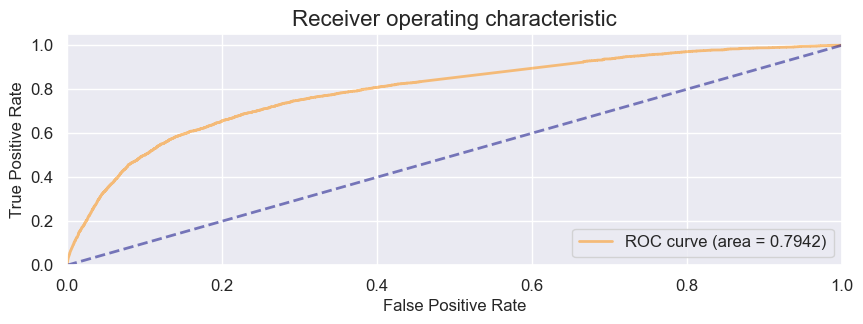

ROC-AUC: 0.7942209362818075, Gini: 0.5884418725636149


In [204]:
# Делаем предсказание на тестовых данных
y_pred_default = model_target_1.predict_proba(X_test)[:,1]
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_default)
print(f"ROC-AUC: {roc_auc}, Gini: {calc_gini(roc_auc)}")

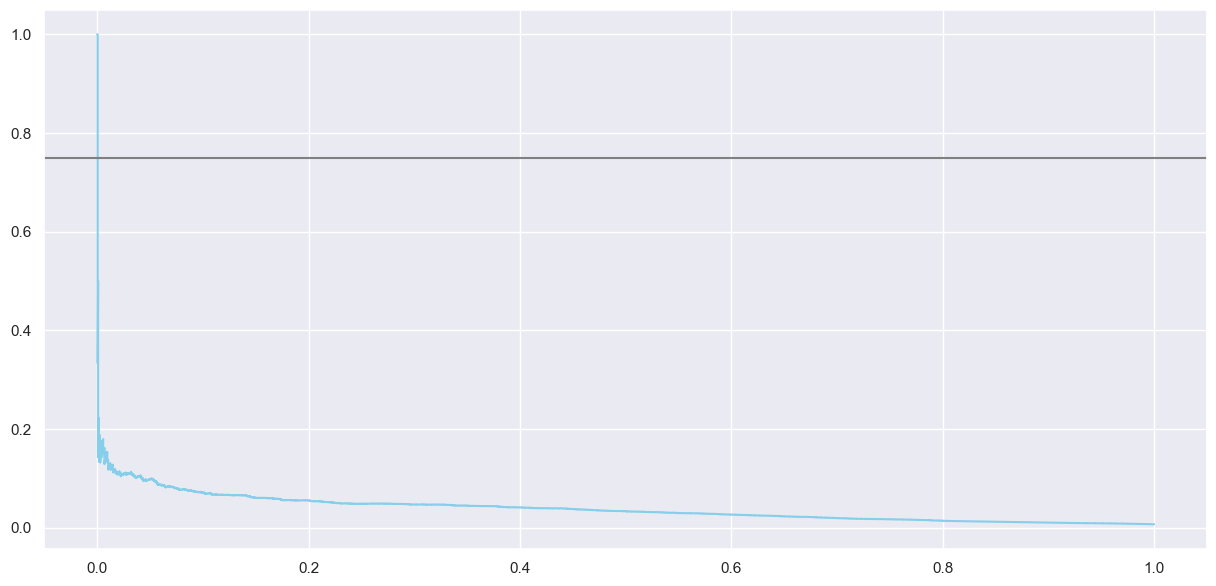

In [188]:
from sklearn.metrics import precision_recall_curve, auc
precision, recall, thrs = precision_recall_curve(y_test, y_pred_default)
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

Распределение исходного таргета: 0.006802721088435374
Распределение предсказанного таргета: 0.029344807543270474


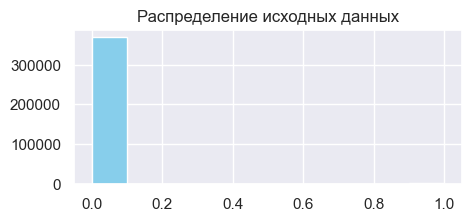

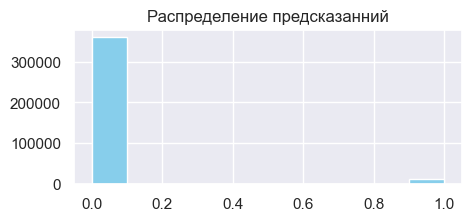

In [189]:
# Переводим вероятностные предсказания в класс
threshold = 0.5
y_pred_default_class = (y_pred_default > threshold).astype(int) 

print(f"Распределение исходного таргета: {sum(y_test)/len(y_test)}")
print(f"Распределение предсказанного таргета: {sum(y_pred_default_class)/len(y_pred_default_class)}")

fig = plt.figure(figsize=(5,2))
pd.DataFrame(y_test).hist(ax=fig.gca())
plt.title("Распределение исходных данных")

fig = plt.figure(figsize=(5,2))
pd.DataFrame(y_pred_default_class).hist(ax=fig.gca())
plt.title("Распределение предсказанний")

plt.show()

In [172]:
tmp_df = pd.DataFrame([y_test, y_pred_default]).T

In [190]:
tmp_df[tmp_df[target_col] == 0]['Unnamed 0'].median()

0.078333199407492

In [191]:
tmp_df[tmp_df[target_col] == 1]['Unnamed 0'].median()

0.28515470373025853

In [192]:
print(tmp_df.sort_values(by=['Unnamed 0'], ascending=False)[:1000][target_col].sum())
print(tmp_df.sort_values(by=['Unnamed 0'], ascending=False)[:10_000][target_col].sum())
print(tmp_df.sort_values(by=['Unnamed 0'], ascending=False)[-1000:][target_col].sum())
print(tmp_df.sort_values(by=['Unnamed 0'], ascending=False)[-10_000:][target_col].sum())
tmp_df.sort_values(by=['Unnamed 0'], ascending=False)[:200]

104.0
532.0
1.0
8.0


target_4  Unnamed 0
55864        1.0   0.953545
299895       0.0   0.951818
309325       0.0   0.945767
216421       1.0   0.945372
72590        0.0   0.937051
314371       0.0   0.937003
251176       0.0   0.934122
85194        0.0   0.933386
189140       0.0   0.931288
282044       0.0   0.929936
96236        0.0   0.927927
123517       0.0   0.927803
63544        0.0   0.925685
301970       0.0   0.925580
156448       1.0   0.923083
92549        0.0   0.921095
114203       0.0   0.919741
269043       1.0   0.914827
209066       0.0   0.914496
300011       0.0   0.911841
134526       0.0   0.911601
207107       0.0   0.911461
185453       0.0   0.909572
320797       0.0   0.905230
127304       0.0   0.904302
30613        0.0   0.902647
258861       0.0   0.900118
1608         0.0   0.895589
282144       0.0   0.895322
271002       0.0   0.893299
22066        1.0   0.891654
295477       1.0   0.889746
220208       0.0   0.888706
96336        0.0   0.888530
103558       0.0   0.888307
227893       0.0   0.887925
158172       0.0   0.886758
289856       0.0   0.886375
94512        0.0   0.885717
256539       1.0   0.885329
278357       0.0   0.881497
178098       0.0   0.881416
10654        0.0   0.881043
184068       0.0   0.877248
11117        0.0   0.876204
329860       0.0   0.876191
275141       0.0   0.875076
73053        0.0   0.873784
158272       0.0   0.873633
104021       0.0   0.871624
21183        0.0   0.870928
218384       0.0   0.870268
271532       0.0   0.870112
32576        1.0   0.869602
189240       1.0   0.869135
134989       0.0   0.867556
165957       1.0   0.867351
196925       0.0   0.867327
82671        0.0   0.866796
79624        0.0   0.865983
89333        0.0   0.865529
58121        0.0   0.864398
23764        0.0   0.864328
3332         0.0   0.863588
30255        0.0   0.862371
97185        0.0   0.862226
249352       0.0   0.861739
201621       0.0   0.861162
179736       0.0   0.859878
231546       0.0   0.859455
207874       1.0   0.858699
117800       0.0   0.857160
289829       0.0   0.856455
60196        0.0   0.854911
65268        0.0   0.853936
281485       1.0   0.853443
176906       1.0   0.853111
84002        1.0   0.852713
14770        0.0   0.851559
184116       0.0   0.850948
276972       0.0   0.850818
39190        0.0   0.850697
42085        0.0   0.850510
86832        0.0   0.850358
94056        0.0   0.849397
247389       0.0   0.849300
138642       0.0   0.847916
318767       0.0   0.847148
81359        0.0   0.846948
307940       0.0   0.846898
295334       0.0   0.843966
246004       0.0   0.843798
251555       0.0   0.843135
135016       0.0   0.841826
300778       1.0   0.841611
313112       0.0   0.840397
217178       0.0   0.839958
101991       0.0   0.839832
240540       0.0   0.839816
203799       0.0   0.839279
145938       1.0   0.839190
160533       0.0   0.838666
187416       0.0   0.838576
328583       0.0   0.838480
262514       1.0   0.838260
16210        0.0   0.837670
311288       0.0   0.837488
268479       0.0   0.836531
122132       0.0   0.836408
165494       0.0   0.836094
125480       0.0   0.835951
291351       0.0   0.835443
154127       0.0   0.835252
170653       0.0   0.835210
293580       0.0   0.834711
85700        0.0   0.834446
271053       0.0   0.834330
237959       0.0   0.833842
315373       0.0   0.833798
271508       0.0   0.833613
323244       0.0   0.833578
8795         0.0   0.832773
225863       0.0   0.832103
287799       0.0   0.831478
232321       0.0   0.831240
127683       0.0   0.829851
41622        0.0   0.829625
251076       0.0   0.828780
250705       0.0   0.828772
280320       0.0   0.828004
84675        0.0   0.827874
320599       0.0   0.827343
269810       1.0   0.826977
66449        0.0   0.826920
338908       0.0   0.826850
158651       0.0   0.825651
215036       1.0   0.825420
65747        1.0   0.825108
351971       1.0   0.824695
35427        0.0   0.824360
153100       0.0   0.823887
298135       0.0   0.823485
2875

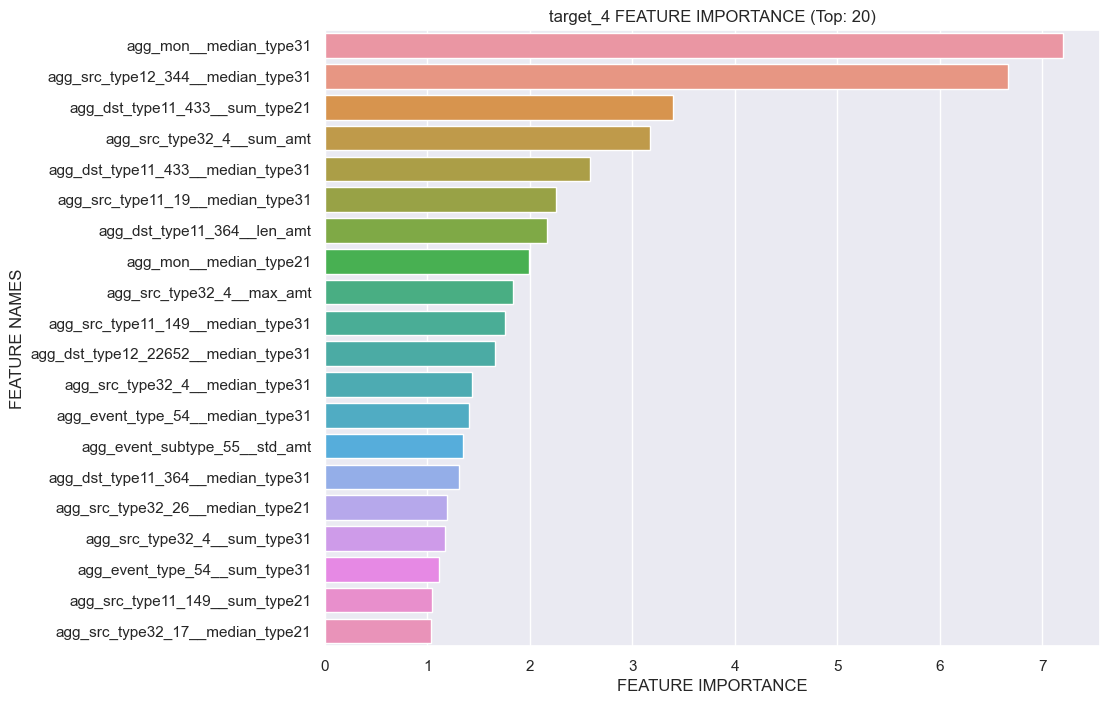

In [176]:
# Важность признаков
fi_df = plot_feature_importance(model_target_1.get_feature_importance(), X_test.columns, model_name=target_col, top_n=20)  

In [166]:
# X_train_df[X_train_df['target_1'] == 1]['client_id'][:1].item()

In [167]:
# X_train_df[X_train_df['client_id'] == '44649bc6f086b70512b12c44c466528d6a8324880c3dcb83e7a99ed277485cd9'].shape
# train_target_df[train_target_df['client_id'] == '44649bc6f086b70512b12c44c466528d6a8324880c3dcb83e7a99ed277485cd9'].shape

In [177]:
fi_target_4 = list(fi_df.sort_values(by='feature_importance', ascending=False)['feature_names'][:20])
# fi_target_4

In [178]:
fi_target_4

['agg_mon__median_type31',
 'agg_src_type12_344__median_type31',
 'agg_dst_type11_433__sum_type21',
 'agg_src_type32_4__sum_amt',
 'agg_dst_type11_433__median_type31',
 'agg_src_type11_19__median_type31',
 'agg_dst_type11_364__len_amt',
 'agg_mon__median_type21',
 'agg_src_type32_4__max_amt',
 'agg_src_type11_149__median_type31',
 'agg_dst_type12_22652__median_type31',
 'agg_src_type32_4__median_type31',
 'agg_event_type_54__median_type31',
 'agg_event_subtype_55__std_amt',
 'agg_dst_type11_364__median_type31',
 'agg_src_type32_26__median_type21',
 'agg_src_type32_4__sum_type31',
 'agg_event_type_54__sum_type31',
 'agg_src_type11_149__sum_type21',
 'agg_src_type32_17__median_type21']

In [149]:
fi_target_3

['agg_event_type_37__median_amt',
 'agg_src_type11_19__sum_amt',
 'agg_event_type_37__median_type21',
 'agg_mon__min_amt',
 'agg_src_type11_149__sum_amt',
 'agg_dst_type11_1166__sum_amt',
 'agg_event_type_37__max_amt',
 'agg_src_type12_344__len_amt',
 'agg_mon_rur__sum_amt',
 'agg_dst_type11_852__len_amt',
 'agg_dst_type11_852__max_amt',
 'agg_event_type_38__max_amt',
 'agg_dst_type11_1166__median_type31',
 'agg_src_type12_344__sum_type21',
 'agg_src_type11_19__min_amt',
 'agg_event_subtype_49__sum_amt',
 'agg_event_subtype_49__len_amt',
 'agg_dst_type11_869__median_type21',
 'agg_src_type11_149__median_type31',
 'agg_src_type12_344__min_amt']

In [130]:
fi_target_2

['agg_mon__median_type31',
 'agg_src_type12_344__median_type31',
 'agg_src_type11_19__sum_amt',
 'agg_src_type12_344__max_amt',
 'agg_src_type12_902__max_amt',
 'agg_src_type12_344__median_amt',
 'agg_src_type32_26__max_amt',
 'agg_src_type11_19__sum_type21',
 'agg_dst_type11_852__median_type31',
 'agg_event_type_37__sum_amt',
 'agg_src_type12_1081__median_type21',
 'agg_mon__sum_amt',
 'agg_dst_type11_364__std_amt',
 'agg_src_type12_344__sum_amt',
 'agg_mon__min_amt',
 'agg_src_type12_344__std_amt',
 'agg_dst_type12_10049__max_amt',
 'agg_dst_type12_22652__sum_amt',
 'agg_dst_type11_433__median_type31',
 'agg_src_type22_70__median_amt']

In [110]:
# fi_target_1 = list(fi_df.sort_values(by='feature_importance', ascending=False)['feature_names'][:20])
fi_target_1

['agg_event_subtype_18__sum_type21',
 'agg_mon__median_amt',
 'agg_src_type11_149__len_amt',
 'agg_src_type12_344__median_type31',
 'agg_src_type11_149__max_amt',
 'agg_mon__min_amt',
 'agg_src_type11_149__median_type21',
 'agg_src_type11_149__sum_type31',
 'agg_mon__median_type31',
 'agg_dst_type11_852__len_amt',
 'agg_src_type11_19__sum_type21',
 'agg_event_subtype_18__median_type31',
 'agg_dst_type11_433__min_amt',
 'agg_dst_type11_852__max_amt',
 'agg_event_subtype_18__median_amt',
 'agg_src_type12_344__sum_amt',
 'agg_dst_type11_852__min_amt',
 'agg_dst_type11_988__min_amt',
 'agg_src_type12_1081__median_type31',
 'agg_dst_type11_852__median_type21']

In [193]:
fi_union = list(set(fi_target_1)|set(fi_target_2)|set(fi_target_3)|set(fi_target_4))
len(fi_union)

67

In [120]:
# fi_target_1 = list(fi_df.sort_values(by='feature_importance', ascending=False)['feature_names'][:20])

In [54]:
74695/6637433*100

1.1253597588103714

In [56]:
4125/367491*100

1.1224764688114812

In [ ]:
# tmp_df_2 = train_target_df.merge(tmp_df, how='right', left_on=['client_id','mon'], right_on = ['client_id','report_next_end'])
tmp_df_2

In [45]:
target = 

report_end  \
client_id                                          report_next_end              
525d7d67676e10d799a40762ab92594ce21beabd42541a1... 2022-02-28      2022-01-31   
5490ef403cfcd5e5b18fd0e766aad66eddbedfa4778802c... 2022-02-28      2022-01-31   
578a56523cd29b8d364d78fc45e412a0e88881fe8ef0dd2... 2022-02-28      2022-01-31   
5846e036da7d4bb6cdc58f6797aa2e392026b3e363d78a2... 2022-02-28      2022-01-31   
5995d4d18fe1741de664c0da6516a5c7b1d69d55fc8c39e... 2022-02-28      2022-01-31   
...                                                                       ...   
29726add8c716714b38fee061b4e10e1246bd967cc5b662... 2023-01-31      2022-12-31   
29cccf949e896ac63a0885145a5856e000db61aaa3f89e4... 2023-01-31      2022-12-31   
2b03ca47360f29c588a9cf029015a18bf2a78f0c8fe7af7... 2023-01-31      2022-12-31   
2b4ec53aeafb2edd8ef4e9f556cf658c4db65f57b8f0505... 2023-01-31      2022-12-31   
2ebbf36f56a4f76605b21b76abc0bc0b57cd6d0008436f1... 2023-01-31      2022-12-31   

                                                                    agg_mon__len_amt  \
client_id                                          report_next_end                     
525d7d67676e10d799a40762ab92594ce21beabd42541a1... 2022-02-28                    0.0   
5490ef403cfcd5e5b18fd0e766aad66eddbedfa4778802c... 2022-02-28                   18.0   
578a56523cd29b8d364d78fc45e412a0e88881fe8ef0dd2... 2022-02-28                    1.0   
5846e036da7d4bb6cdc58f6797aa2e392026b3e363d78a2... 2022-02-28                    6.0   
5995d4d18fe1741de664c0da6516a5c7b1d69d55fc8c39e... 2022-02-28                   55.0   
...                                                                              ...   
29726add8c716714b38fee061b4e10e1246bd967cc5b662... 2023-01-31                    4.0   
29cccf949e896ac63a0885145a5856e000db61aaa3f89e4... 2023-01-31                    6.0   
2b03ca47360f29c588a9cf029015a18bf2a78f0c8fe7af7... 2023-01-31                    6.0   
2b4ec53aeafb2edd8ef4e9f556cf658c4db65f57b8f0505... 2023-01-31                    4.0   
2ebbf36f56a4f76605b21b76abc0bc0b57cd6d0008436f1... 2023-01-31                    0.0   

                                                                    agg_mon__sum_amt  \
client_id                                          report_next_end                     
525d7d67676e10d799a40762ab92594ce21beabd42541a1... 2022-02-28           0.000000e+00   
5490ef403cfcd5e5b18fd0e766aad66eddbedfa4778802c... 2022-02-28           4.237578e+06   
578a56523cd29b8d364d78fc45e412a0e88881fe8ef0dd2... 2022-02-28           2.438350e+04   
5846e036da7d4bb6cdc58f6797aa2e392026b3e363d78a2... 2022-02-28           1.010672e+06   
5995d4d18fe1741de664c0da6516a5c7b1d69d55fc8c39e... 2022-02-28           3.182164e+06   
...                                                                              ...   
29726add8c716714b38fee061b4e10e1246bd967cc5b662... 2023-01-31           1.300916e+06   
29cccf949e896ac63a0885145a5856e000db61aaa3f89e4... 2023-01-31           3.599063e+04   
2b03ca47360f29c588a9cf029015a18bf2a78f0c8fe7af7... 2023-01-31           2.667568e+05   
2b4ec53aeafb2edd8ef4e9f556cf658c4db65f57b8f0505... 2023-01-31           3.723796e+06   
2ebbf36f56a4f76605b21b76abc0bc0b57cd6d0008436f1... 2023-01-31           0.000000e+00   

                                                                    agg_mon__median_amt  \
client_id                                          report_next_end                        
525d7d67676e10d799a40762ab92594ce21beabd42541a1... 2022-02-28                  0.000000   
5490ef403cfcd5e5b18fd0e766aad66eddbedfa4778802c... 2022-02-28              30493.016602   
578a56523cd29b8d364d78fc45e412a0e88881fe8ef0dd2... 2022-02-28              24383.498047   
5846e036da7d4bb6cdc58f6797aa2e392026b3e363d78a2... 2022-02-28              61305.812500   
5995d4d18fe1741de664c0da6516a5c7b1d69d55fc8c39e... 2022-02-28              10592.847656   
...                                                                                 ..

In [60]:
X_test_df[
    (X_test_df['client_id'] == '525d7d67676e10d799a40762ab92594ce21beabd42541a14ce5dfecab344bc8c')&
    (X_test_df['report_next_end'] == '2022-02-28')
]

client_id report_next_end  \
0  525d7d67676e10d799a40762ab92594ce21beabd42541a...      2022-02-28   

  report_end  agg_mon__len_amt  agg_mon__sum_amt  agg_mon__median_amt  \
0 2022-01-31               0.0               0.0                  0.0   

   agg_mon__std_amt  agg_mon__min_amt  agg_mon__max_amt  agg_mon__sum_type21  \
0               0.0               0.0               0.0                  0.0   

   agg_mon__sum_type31  agg_mon__median_type21  agg_mon__median_type31  \
0                  0.0                     0.0                     0.0   

   agg_mon_rur__len_amt  agg_mon_rur__sum_amt  agg_mon_rur__sum_type21  \
0                   0.0                   0.0                      0.0   

   agg_mon_rur__sum_type31  prc_rur__len_amt  prc_rur__sum_amt  \
0                      0.0               0.0               0.0   

   prc_rur__sum_type21  prc_rur__sum_type31  agg_event_type_54__len_amt  \
0                  0.0                  0.0                         0.0   

   agg_event_type_54__sum_amt  agg_event_type_54__median_amt  \
0                         0.0                            0.0   

   agg_event_type_54__std_amt  agg_event_type_54__min_amt  \
0                         0.0                         0.0   

   agg_event_type_54__max_amt  agg_event_type_54__sum_type21  \
0                         0.0                            0.0   

   agg_event_type_54__sum_type31  agg_event_type_54__median_type21  \
0                            0.0                               0.0   

   agg_event_type_54__median_type31  agg_event_type_38__len_amt  \
0                               0.0                         0.0   

   agg_event_type_38__sum_amt  agg_event_type_38__median_amt  \
0                         0.0                            0.0   

   agg_event_type_38__std_amt  agg_event_type_38__min_amt  \
0                         0.0                         0.0   

   agg_event_type_38__max_amt  agg_event_type_38__sum_type21  \
0                         0.0                            0.0   

   agg_event_type_38__sum_type31  agg_event_type_38__median_type21  \
0                            0.0                               0.0   

   agg_event_type_38__median_type31  agg_event_type_37__len_amt  \
0                               0.0                         0.0   

   agg_event_type_37__sum_amt  agg_event_type_37__median_amt  \
0                         0.0                            0.0   

   agg_event_type_37__std_amt  agg_event_type_37__min_amt  \
0                         0.0                         0.0   

   agg_event_type_37__max_amt  agg_event_type_37__sum_type21  \
0                         0.0                            0.0   

   agg_event_type_37__sum_type31  agg_event_type_37__median_type21  \
0                            0.0                               0.0   

   agg_event_type_37__median_type31  agg_event_type_51__len_amt  \
0                               0.0                         0.0   

   agg_event_type_51__sum_amt  agg_event_type_51__median_amt  \
0                         0.0                            0.0   

   agg_event_type_51__std_amt  agg_event_type_51__min_amt  \
0                         0.0                         0.0   

   agg_event_type_51__max_amt  agg_event_type_51__sum_type21  \
0                         0.0                            0.0   

   agg_event_type_51__sum_type31  agg_event_type_51__median_type21  \
0                            0.0                               0.0   

   agg_event_type_51__median_type31  agg_event_type_25__len_amt  \
0                               0.0                         0.0   

   agg_event_type_25__sum_amt  agg_event_type_25__median_amt  \
0                         0.0                            0.0   

   agg_event_type_25__std_amt  agg_event_type_25__min_amt  \
0                         0.0                         0.0   

   agg_event_type_25__max_amt  agg_event_type_25__sum_type21  \
0                         0.0                            0.0   


In [36]:
# union_client_agg_df

In [181]:
# tmp_df['report_next_end']

In [ ]:
# new_df = pd.merge(A_df, B_df,  how='left', left_on=['A_c1','c2'], right_on = ['B_c1','c2'])

In [ ]:
from catboost import CatBoostClassifier, Pool

In [175]:
tmp_df = union_client_agg_df[:1000]
tmp_df.shape

(1000, 371)

In [184]:
# tmp_df_2 = train_target_df.merge(tmp_df, how='right', left_on=['client_id','mon'], right_on = ['client_id','report_next_end'])
tmp_df_2

mon  target_1  target_2  target_3  target_4  \
0   2022-02-28         0         0         0         0   
1   2022-02-28         0         0         0         0   
2   2022-02-28         0         0         0         0   
3   2022-02-28         0         0         0         0   
4   2022-02-28         0         0         0         0   
..         ...       ...       ...       ...       ...   
995 2022-02-28         0         0         0         0   
996 2022-02-28         0         0         0         0   
997 2022-02-28         1         0         0         0   
998 2022-02-28         0         0         0         0   
999 2022-02-28         0         0         0         0   

                                             client_id report_end  \
0    51f88b707d9c8766cdbdfe799ba0fafd8f5b8034b08c46... 2022-01-31   
1    522256f58adeaf13fbf098859fe5627f663ab586cb71e7... 2022-01-31   
2    522ff0793af20dff019519fddea3117f8858c9823ba364... 2022-01-31   
3    523bbf480e65912fac332549b46d5ccec8a17ddc65b85f... 2022-01-31   
4    5247a0d6e2ebcfb51b2bd2d3dbcf2706dd4d372189bf0a... 2022-01-31   
..                                                 ...        ...   
995  a29db29da8c92ad726884ab7b2d49cb755142c345952c5... 2022-01-31   
996  a2a21a109baca75d4d13576baabb120dfeb4953022e0b5... 2022-01-31   
997  a2b2f13a6ab840c519e3d59c4ecc8c0efe7ea975c54015... 2022-01-31   
998  a2b365a5d637971702d4c4fdf95c6c10c1f3ff6bf5a18c... 2022-01-31   
999  a2bd098c04d96dc59d42b9c20c572454bd07f660f9da15... 2022-01-31   

    report_next_end  agg_mon__len_amt  agg_mon__sum_amt  agg_mon__median_amt  \
0        2022-02-28               2.0      6.660388e+04         33301.937500   
1        2022-02-28               8.0      6.852730e+04          4163.892456   
2        2022-02-28               0.0      0.000000e+00             0.000000   
3        2022-02-28               1.0      9.647572e+04         96475.718750   
4        2022-02-28              22.0      1.345999e+06         45354.976562   
..              ...               ...               ...                  ...   
995      2022-02-28              27.0      3.303033e+06         49190.687500   
996      2022-02-28               5.0      1.112106e+05         14838.105469   
997      2022-02-28               9.0      1.269987e+06          3606.834961   
998      2022-02-28              64.0      7.662128e+06         27202.854492   
999      2022-02-28              25.0      1.204812e+06         20849.910156   

     agg_mon__std_amt  agg_mon__min_amt  agg_mon__max_amt  \
0        42159.529304       3490.648438      6.311323e+04   
1        11297.509734          1.222030      3.168263e+04   
2            0.000000          0.000000      0.000000e+00   
3            0.000000      96475.718750      9.647572e+04   
4        65826.651270          9.290074      3.145582e+05   
..                ...               ...               ...   
995     327572.559728        237.454285      1.747881e+06   
996      19867.906678       2219.706787      4.389385e+04   
997     407136.221630          2.522250      1.226717e+06   
998     273354.469574        166.432053      1.787496e+06   
999      94800.228157         89.021240      4.304040e+05   

     agg_mon__sum_type21  agg_mon__sum_type31  agg_mon__median_type21  \
0                92678.0               4846.0                 46339.0   
1               237720.0               6512.0                 29715.0   
2                    0.0                  0.0                     0.0   
3                 3191.0               2240.0                  3191.0   
4               486618.0              28512.0                 22119.0   
..                   ...                  ...                     ...   
995             893511.0               7884.0                 33093.0   
996             213610.0              10160.0                 42722.0   
997             229464.0               1332.0                 25496.0   
998             767424.0              86080.0                

In [163]:
# client_agg_df['prc_rur__len_amt'] = client_agg_df['agg_mon_rur__len_amt'] / (client_agg_df['agg_mon__len_amt'] + eps)
# client_agg_df['prc_rur__sum_amt'] = client_agg_df['agg_mon_rur__sum_amt'] / (client_agg_df['agg_mon__sum_amt'] + eps)
# client_agg_df['prc_rur__sum_type21'] = client_agg_df['agg_mon_rur__sum_type21'] / (client_agg_df['agg_mon__sum_type21'] + eps)
# client_agg_df['prc_rur__sum_type31'] = client_agg_df['agg_mon_rur__sum_type31'] / (client_agg_df['agg_mon__sum_type31'] + eps)
# client_agg_df

In [165]:
# %%time

# client_sub_cat_agg_df = select_mon_trx_df.groupby('client_id').agg(
#                     len_amt = ('amount', len), 
#                     sum_amt = ('amount', sum), 
#                     median_amt = ('amount', np.median), 
#                     std_amt = ('amount', np.std),
#                     min_amt = ('amount', min),
#                     max_amt = ('amount', max),            
#                     sum_type21 = ('src_type21', sum), 
#                     sum_type31 = ('src_type31', sum), 
#                     median_type21 = ('src_type21', np.median), 
#                     median_type31 = ('src_type31', np.median),      

# ).add_prefix(f'agg_mon__')

# client_sub_cat_agg_df_2 = select_mon_trx_df[select_mon_trx_df['currency'] == 11].groupby('client_id').agg(
#                     len_amt = ('amount', len), 
#                     sum_amt = ('amount', sum), 
#                     sum_type21 = ('src_type21', sum), 
#                     sum_type31 = ('src_type31', sum), 
# ).add_prefix(f'agg_mon_rur__')

# client_sub_cat_agg_df.shape, client_sub_cat_agg_df_2.shape

In [140]:
client_sub_cat_agg_df_2

agg_mon_rur__len_amt  \
client_id                                                                  
000006265d27d1166ed67506682be7380007a5bead4362f...                    13   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...                     2   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...                    36   
000030a4067420da425d21ea72d5e647d26cf279e551796...                     4   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...                     8   
...                                                                  ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...                    18   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...                    14   
ffffc7318bcad1435917639e46013c340756d54474a1027...                    22   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...                     2   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...                    12   

                                                    agg_mon_rur__sum_amt  \
client_id                                                                  
000006265d27d1166ed67506682be7380007a5bead4362f...          1.187614e+07   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...          1.166523e+05   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...          1.955276e+06   
000030a4067420da425d21ea72d5e647d26cf279e551796...          5.480235e+05   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...          1.511786e+06   
...                                                                  ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...          2.442391e+06   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...          8.131472e+05   
ffffc7318bcad1435917639e46013c340756d54474a1027...          8.890092e+06   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...          1.463661e+06   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...          1.840474e+07   

                                                    agg_mon_rur__sum_type21  \
client_id                                                                     
000006265d27d1166ed67506682be7380007a5bead4362f...                  21437.0   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...                  93142.0   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...                1020276.0   
000030a4067420da425d21ea72d5e647d26cf279e551796...                  61824.0   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...                 226728.0   
...                                                                     ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...                 449010.0   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...                  36120.0   
ffffc7318bcad1435917639e46013c340756d54474a1027...                 335698.0   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...                  87268.0   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...                 243696.0   

                                                    agg_mon_rur__sum_type31  
client_id                                                                    
000006265d27d1166ed67506682be7380007a5bead4362f...                  15093.0  
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...                   1706.0  
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...                  29880.0  
000030a4067420da425d21ea72d5e647d26cf279e551796...                   9944.0  
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...                  14680.0  
...                                                                     ...  
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...                  44928.0  
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...                  25340.0  
ffffc7318bcad1435917639e46013c340756d54474a1027...                  11000.0  
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...                   1490.0  
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...                  26376.0  

[844291 rows x 4 columns]

In [139]:
# Определение популярной currency у клиента currency = 11 - рубли, остальное не рубли. 
# Можно посчитать долю рублевых платежей относительно других валют, как в кол-ве, так и в сумме  
# select_mon_trx_df['currency'] == 11
client_sub_cat_agg_df


agg_mon__len_amt  \
client_id                                                              
000006265d27d1166ed67506682be7380007a5bead4362f...                13   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...                 2   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...                36   
000030a4067420da425d21ea72d5e647d26cf279e551796...                 4   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...                 8   
...                                                              ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...                18   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...                14   
ffffc7318bcad1435917639e46013c340756d54474a1027...                22   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...                 2   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...                12   

                                                    agg_mon__sum_amt  \
client_id                                                              
000006265d27d1166ed67506682be7380007a5bead4362f...      1.187614e+07   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...      1.166523e+05   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...      1.955276e+06   
000030a4067420da425d21ea72d5e647d26cf279e551796...      5.480235e+05   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...      1.511786e+06   
...                                                              ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...      2.442391e+06   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...      8.131472e+05   
ffffc7318bcad1435917639e46013c340756d54474a1027...      8.890092e+06   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...      1.463661e+06   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...      1.840474e+07   

                                                    agg_mon__median_amt  \
client_id                                                                 
000006265d27d1166ed67506682be7380007a5bead4362f...         10022.515625   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...         58326.169434   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...         41786.011719   
000030a4067420da425d21ea72d5e647d26cf279e551796...        103807.063477   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...        146428.085938   
...                                                                 ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...          3751.878540   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...          6046.936890   
ffffc7318bcad1435917639e46013c340756d54474a1027...         93506.035156   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...        731830.667969   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...        316087.679688   

                                                    agg_mon__std_amt  \
client_id                                                              
000006265d27d1166ed67506682be7380007a5bead4362f...      3.206537e+06   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c...      7.598755e+04   
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...      7.692468e+04   
000030a4067420da425d21ea72d5e647d26cf279e551796...      1.545740e+05   
0000474aa9bf8e794b4a3fe23e3143bb4a794523fddbce1...      2.173190e+05   
...                                                              ...   
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...      3.018217e+05   
ffffab5f6ae1c8d04d83ef12e2ad803298737992698079e...      1.295826e+05   
ffffc7318bcad1435917639e46013c340756d54474a1027...      6.258419e+05   
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...      9.675999e+05   
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...      2.907293e+06   

                                                    agg_mon__min_amt  \
client_id                                                              
000006265d27d1166ed67506682be7380007a5bead4362f...          3.500211   
000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030c..

In [42]:
# cols = ['event_type', 'event_subtype', 'currency', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type21', 'src_type22', 'src_type31', 'src_type32', ]
# length = len(all_trx_train_df)
# for col in cols:
#     print(col)
#     uniq_cnt = len(all_trx_train_df[col].unique())
    
#     print(f'{uniq_cnt} / {length} => {uniq_cnt/length*100}')
# #     break

In [90]:
len([54, 38, 37, 51, 25, 55, 49, 18, 29, 47, 19, 149, 344, 902, 1081, 364, 869, 433, 1166, 988, 852, 22652, 17340, 10049, 30836, 31488, 70, 41, 85, 81, 26, 4, 17, 25, 67])

35

In [75]:
# 19.0     162855385
# 149.0     23611777
(27919376 + 16752123 + 16544471 + 15009397 + 13586532 + 11384002)/len(all_trx_train_df)*100

47.05114989368822

In [82]:
# cat_cols = ['event_type', 'event_subtype', 'currency', 'src_type11', 'src_type12', 'dst_type11', 'dst_type12', 'src_type22', 'src_type32', ]
# # all_trx_train_df['event_subtype'].hist(bins=100)
# all_trx_train_df['src_type32'].value_counts().nlargest(20)

In [48]:
%%time
# 1. Общее количество транзакций клиента
select_mon_trx_df['total_transactions'] = select_mon_trx_df.groupby('client_id')['amount'].transform('count')
# 2. Общая сумма транзакций клиента
select_mon_trx_df['total_amount'] = select_mon_trx_df.groupby('client_id')['amount'].transform('sum')

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


CPU times: total: 5.2 s
Wall time: 5.19 s


<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
%%time

client_sub_cat_agg_df = select_mon_trx_df.groupby('client_id').agg(
                   len_amt = ('amount', len), 
                    sum_amt = ('amount', sum), 
                    median_amt = ('amount', np.median), 
                    std_amt = ('amount', np.std),
                    min_amt = ('amount', min),
                    max_amt = ('amount', max),            
                    sum_type21 = ('src_type21', sum), 
                    sum_type31 = ('src_type31', sum), 
                    median_type21 = ('src_type21', np.median), 
                    median_type31 = ('src_type31', np.median),      
    
).add_prefix(f'agg_mon__')
client_agg_df = client_agg_df.merge(client_sub_cat_agg_df, on='client_id', how='left').fillna(0)
client_agg_df.shape

CPU times: total: 12.5 s
Wall time: 12.4 s


(1081371, 23)

In [113]:
client_agg_df

client_id report_end  \
0        51f88b707d9c8766cdbdfe799ba0fafd8f5b8034b08c46... 2022-01-31   
1        522256f58adeaf13fbf098859fe5627f663ab586cb71e7... 2022-01-31   
2        522ff0793af20dff019519fddea3117f8858c9823ba364... 2022-01-31   
3        523bbf480e65912fac332549b46d5ccec8a17ddc65b85f... 2022-01-31   
4        5247a0d6e2ebcfb51b2bd2d3dbcf2706dd4d372189bf0a... 2022-01-31   
...                                                    ...        ...   
1081366  f41b2858ce384d7d7553ef97ff55a4e4d07e6f4cd9e267... 2022-01-31   
1081367  f7bb22dd3ebf85c89b933100638b3a4270afe3cc62b82b... 2022-01-31   
1081368  f842d320bfc1ab5276d9e39e2e961b2be560d9405f717b... 2022-01-31   
1081369  f84b6af02d3b3f3f79742df549a00c36c347dc3f227bb5... 2022-01-31   
1081370  fba7d41d3a60930e88edc1822a086dab1c4e93e278879b... 2022-01-31   

        report_next_end  agr_event_type_54__len_amt  \
0            2022-02-28                         1.0   
1            2022-02-28                         0.0   
2            2022-02-28                         0.0   
3            2022-02-28                         1.0   
4            2022-02-28                         2.0   
...                 ...                         ...   
1081366      2022-02-28                         4.0   
1081367      2022-02-28                        42.0   
1081368      2022-02-28                         4.0   
1081369      2022-02-28                         0.0   
1081370      2022-02-28                         2.0   

         agr_event_type_54__sum_amt  agr_event_type_54__median_amt  \
0                      6.311323e+04                   63113.226562   
1                      0.000000e+00                       0.000000   
2                      0.000000e+00                       0.000000   
3                      9.647572e+04                   96475.718750   
4                      4.185159e+05                  209257.976562   
...                             ...                            ...   
1081366                2.140642e+04                    3326.920776   
1081367                2.742567e+06                   48997.238281   
1081368                8.743654e+05                  269105.898438   
1081369                0.000000e+00                       0.000000   
1081370                7.781206e+03                    3890.602936   

         agr_event_type_54__std_amt  agr_event_type_54__min_amt  \
0                          0.000000                63113.226562   
1                          0.000000                    0.000000   
2                          0.000000                    0.000000   
3                          0.000000                96475.718750   
4                     148916.986429               103957.765625   
...                             ...                         ...   
1081366                 5700.025017                 1022.791626   
1081367                55385.139316                  493.240814   
1081368               120654.790710                40189.128906   
1081369                    0.000000                    0.000000   
1081370                 4768.385066                  518.845520   

         agr_event_type_54__max_amt  agr_event_type_54__sum_type21  \
0                      63113.226562                        46339.0   
1                          0.000000                            0.0   
2                          0.000000                            0.0   
3                      96475.718750                         3191.0   
4                     314558.187500                        44238.0   
...                             ...                            ...   
1081366                13729.784180                        36320.0   
1081367               223931.656250                      1109934.0   
1081368               295964.406250                        42160.0   
1081369                    0.000000                            0.0   
1081370                 7262.360352                        51442.0   

         agr_event_type_

In [92]:
%%time
# Формируем фичи по транзакциям с группировкой по категориям
for cat_name in tqdm(cat_pop_items):
    for item in tqdm(cat_pop_items[cat_name]):
        # Выбираем данные только с указанным значением для выбранной категории
        sub_cat_df = select_mon_trx_df[select_mon_trx_df[cat_name] == item][['client_id', 'amount', 'src_type21', 'src_type31']]
        print(sub_cat_df.shape)
        # Расчитываем агрегаты по численным значениям 
        tmp_df = sub_cat_df.groupby('client_id').agg(
                len_amt = ('amount', len), 
                sum_amt = ('amount', sum), 
                median_amt = ('amount', np.median), 
                std_amt = ('amount', np.std),
                min_amt = ('amount', min),
                max_amt = ('amount', max),            
                sum_type21 = ('src_type21', sum), 
                sum_type31 = ('src_type31', sum), 
                median_type21 = ('src_type21', np.median), 
                median_type31 = ('src_type31', np.median), 
        ).add_prefix(f'agr_{cat_name}_{item}__')
        break
    break

  0%|          | 0/5 [00:00<?, ?it/s]

(6475074, 4)


  0%|          | 0/8 [00:08<?, ?it/s]

CPU times: total: 8.22 s
Wall time: 8.24 s


In [94]:
tmp_df.reset_index()

client_id  \
0       000006265d27d1166ed67506682be7380007a5bead4362...   
1       000006a0bf17ba6798dfd2d656690c54a9489ffdcdf030...   
2       00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...   
3       00011c01bb22d8f62d9655f32d123dcca5ae55179f8266...   
4       000120ff37fb0179d54e94c6e7266c92f3e3c3c630223f...   
...                                                   ...   
690586  ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cb...   
690587  ffffab5f6ae1c8d04d83ef12e2ad803298737992698079...   
690588  ffffc7318bcad1435917639e46013c340756d54474a102...   
690589  ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878ef...   
690590  ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cb...   

        agr_event_type_54__len_amt  agr_event_type_54__sum_amt  \
0                                4                1.166051e+07   
1                                1                4.594854e+03   
2                               10                5.691508e+05   
3                                5                1.056790e+06   
4                                1                8.233294e+03   
...                            ...                         ...   
690586                           7                2.333109e+06   
690587                           3                1.999243e+05   
690588                          17                5.694862e+06   
690589                           2                1.463661e+06   
690590                           8                1.668454e+07   

        agr_event_type_54__median_amt  agr_event_type_54__std_amt  \
0                        32770.053711                5.779917e+06   
1                         4594.854492                         NaN   
2                        41841.775391                6.759132e+04   
3                         9876.702148                4.554978e+05   
4                         8233.293945                         NaN   
...                               ...                         ...   
690586                   19145.498047                4.278388e+05   
690587                   85907.789062                5.165182e+04   
690588                   48175.414062                5.222197e+05   
690589                  731830.667969                9.675999e+05   
690590                  221104.632812                3.495023e+06   

        agr_event_type_54__min_amt  agr_event_type_54__max_amt  \
0                     10022.515625                1.158495e+07   
1                      4594.854492                4.594854e+03   
2                       344.444153                2.329585e+05   
3                      2001.510986                1.026145e+06   
4                      8233.293945                8.233294e+03   
...                            ...                         ...   
690586                 1108.579590                9.871221e+05   
690587                 8125.599609                1.058910e+05   
690588                 1912.112671                1.819630e+06   
690589                47634.210938                1.416027e+06   
690590                74739.906250                9.818281e+06   

        agr_event_type_54__sum_type21  agr_event_type_54__sum_type31  \
0                              6596.0                         4644.0   
1                             46571.0                          853.0   
2                            283410.0                         8300.0   
3                             20030.0                        12480.0   
4                              7358.0                         1683.0   
...                               ...                            ...   
690586                       174615.0                        17472.0   
690587                         7740.0                         5430.0   
690588                       259403.0                         8500.0   
690589                        87268.0                         1490.0   
690590                       162464.0                        17584.0   

        agr_event_type_54__median_t

In [52]:
%%time
# 18. Количество транзакций по подкатегории 1 для клиента
# transactions_df['event_subtype_transactions'] = transactions_df.groupby(['client_id', 'event_subtype'])['amount'].transform('count')
tmp_df_2 = select_mon_trx_df.groupby(['client_id', 'event_subtype']).agg(
    cnt_trx_event_subtype = ('amount', len), 
    sum_trx_event_subtype = ('amount', sum), 
)
tmp_df_2.shape

<timed exec>:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


CPU times: total: 27.5 s
Wall time: 27.5 s


(3124869, 2)

In [50]:
select_mon_trx_df['client_id'].unique().shape

(844295,)

In [ ]:
# 1. Общее количество транзакций клиента
transactions_df['total_transactions'] = transactions_df.groupby('client_id')['amount'].transform('count')
# 2. Общая сумма транзакций клиента
transactions_df['total_amount'] = transactions_df.groupby('client_id')['amount'].transform('sum')
# 3. Средняя сумма транзакции клиента
transactions_df['average_amount'] = transactions_df.groupby('client_id')['amount'].transform('mean')
# 4. Количество уникальных категорий 1 для клиента
transactions_df['unique_categories_1'] = transactions_df.groupby('client_id')['event_type'].transform('nunique')
# 5. Количество уникальных подкатегорий 1 для клиента
transactions_df['unique_subcategories_1'] = transactions_df.groupby('client_id')['event_subtype'].transform('nunique')

# 6. Количество уникальных категорий 2 для клиента
transactions_df['unique_categories_2'] = transactions_df.groupby('client_id')['src_type11'].transform('nunique')

# 7. Количество уникальных подкатегорий 2 для клиента
transactions_df['unique_subcategories_2'] = transactions_df.groupby('client_id')['src_type12'].transform('nunique')

# 8. Максимальная сумма транзакции клиента
transactions_df['max_amount'] = transactions_df.groupby('client_id')['amount'].transform('max')

# 9. Минимальная сумма транзакции клиента
transactions_df['min_amount'] = transactions_df.groupby('client_id')['amount'].transform('min')

# 10. Количество дней между первой и последней транзакцией клиента
transactions_df['days_between_first_last'] = (transactions_df.groupby('client_id')['event_time'].transform('max') - transactions_df.groupby('client_id')['event_time'].transform('min')).dt.days

# 11. Количество транзакций за последние 7 дней для клиента
transactions_df['last_7_days_transactions'] = transactions_df.groupby('client_id')['event_time'].rolling('7D').count().reset_index(0, drop=True)

# 12. Количество транзакций за последние 30 дней для клиента
transactions_df['last_30_days_transactions'] = transactions_df.groupby('client_id')['event_time'].rolling('30D').count().reset_index(0, drop=True)

# 13. Сумма транзакций за последние 7 дней для клиента
transactions_df['last_7_days_amount'] = transactions_df.groupby('client_id')['amount'].rolling('7D').sum().reset_index(0, drop=True)

# 14. Сумма транзакций за последние 30 дней для клиента
transactions_df['last_30_days_amount'] = transactions_df.groupby('client_id')['amount'].rolling('30D').sum().reset_index(0, drop=True)

# 15. Средняя сумма транзакции за последние 7 дней для клиента
transactions_df['last_7_days_average_amount'] = transactions_df.groupby('client_id')['amount'].rolling('7D').mean().reset_index(0, drop=True)

# 16. Средняя сумма транзакции за последние 30 дней для клиента
transactions_df['last_30_days_average_amount'] = transactions_df.groupby('client_id')['amount'].rolling('30D').mean().reset_index(0, drop=True)

# 17. Количество транзакций по категории 1 для клиента
transactions_df['event_type_transactions'] = transactions_df.groupby(['client_id', 'event_type'])['amount'].transform('count')

# 18. Количество транзакций по подкатегории 1 для клиента
transactions_df['event_subtype_transactions'] = transactions_df.groupby(['client_id', 'event_subtype'])['amount'].transform('count')

# 19. Количество транзакций по категории 2 для клиента
transactions_df['src_type11_transactions'] = transactions_df.groupby(['client_id', 'src_type11'])['amount'].transform('count')

# 20. Количество транзакций по подкатегории 2 для клиента
transactions_df['src_type12_transactions'] = transactions_df.groupby(['client_id', 'src_type12'])['amount'].transform('count')

# 21. Сумма транзакций по категории 1 для клиента
transactions_df['event_type_amount'] = transactions_df.groupby(['client_id', 'event_type'])['amount'].transform('sum')

# 22. Сумма транзакций по подкатегории 1 для клиента
transactions_df['event_subtype_amount'] = transactions_df.groupby(['client_id', 'event_subtype'])['amount'].transform('sum')

# 23. Сумма транзакций по категории 2 для клиента
transactions_df['src_type11_amount'] = transactions_df.groupby(['client_id', 'src_type11'])['amount'].transform('sum')

# 24. Сумма транзакций по подкатегории 2 для клиента
transactions_df['src_type12_amount'] = transactions_df.groupby(['client_id', 'src_type12'])['amount'].transform('sum')

# 25. Средняя сумма транзакции по категории 1 для клиента
transactions_df['event_type_average_amount'] = transactions_df.groupby(['client_id', 'event_type'])['amount'].transform('mean')

# 26. Средняя сумма транзакции по подкатегории 1 для клиента
transactions_df['event_subtype_average_amount'] = transactions_df.groupby(['client_id', 'event_subtype'])['amount'].transform('mean')

# 27. Средняя сумма транзакции по категории 2 для клиента
transactions_df['src_type11_average_amount'] = transactions_df.groupby(['client_id', 'src_type11'])['amount'].transform('mean')

# 28. Средняя сумма транзакции по подкатегории 2 для клиента
transactions_df['src_type12_average_amount'] = transactions_df.groupby(['client_id', 'src_type12'])['amount'].transform('mean')

# 29. День недели с наибольшим количеством транзакций для клиента
transactions_df['busiest_day'] = transactions_df.groupby('client_id')['event_time'].apply(lambda x: x.dt.day_name().mode()[0])


In [ ]:
# # Формируем статистику посещений каждого терминала уникальными клиентами и общее кол-во посещений
# start_date = datetime(2022, 1, 1, 0, 0, 0)
# end_date = datetime(2023, 1, 1, 0, 0, 0)
# union_geohash_4_df = pd.DataFrame()
# union_geohash_5_df = pd.DataFrame()
# union_geohash_6_df = pd.DataFrame()

# for i in trange(13):
#     end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
#     print(f'start: {start_date}, end: {end_date}')
    
#     select_mon_geo_df = all_geo_train_df[all_geo_train_df['event_time'].between(start_date, end_date)]
#     print(select_mon_geo_df.shape)

In [10]:
# %%time
# geo_train_df = load_df_by_files(train_geo_files)
# geo_train_df.shape

In [11]:
# %%time
# geo_test_df = load_df_by_files(test_geo_files)
# geo_test_df.shape

In [12]:
# %%time
# Объединяем все известные данные по геообъектам
# all_geo_train_df = pd.concat([geo_train_df, geo_test_df])
# del geo_train_df
# del geo_test_df
# all_geo_train_df.shape

In [13]:
# min_date = all_geo_train_df['event_time'].min()
# max_date = all_geo_train_df['event_time'].max()
# min_date, max_date

In [15]:
%%time
# Формируем статистику посещений каждого терминала уникальными клиентами и общее кол-во посещений
start_date = datetime(2022, 1, 1, 0, 0, 0)
end_date = datetime(2023, 1, 1, 0, 0, 0)
union_geohash_4_df = pd.DataFrame()
union_geohash_5_df = pd.DataFrame()
union_geohash_6_df = pd.DataFrame()

for i in trange(13):
    end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
    print(f'start: {start_date}, end: {end_date}')
    
    select_mon_geo_df = all_geo_train_df[all_geo_train_df['event_time'].between(start_date, end_date)]
    print(select_mon_geo_df.shape)
    
    def calc_aggregate_by_geohash(geo_index:str='geohash_4'):
        geohash_df = select_mon_geo_df.groupby(geo_index).agg(
                                        count_trx = ('client_id', len),
                                        uniq_clients = ('client_id', pd.Series.nunique),
                                              )
        geohash_df['report_end'] = end_date
        geohash_df['report_next_end'] = start_date + relativedelta(months=2) - relativedelta(days=1)
        
        # Рассчитываем уровень "продоваемости продукта" относительно геопозиции
        train_client_by_cur_mon_df = train_target_df[pd.to_datetime(train_target_df['mon']).between(start_date, start_date + relativedelta(months=1) - relativedelta(days=1))]
        current_mon_train_df = train_client_by_cur_mon_df.rename(columns={'mon':'mon_report'}).add_prefix('cur_mon_')
        
        client_geo_df = select_mon_geo_df[['client_id', geo_index]].drop_duplicates()
        cur_mon_select_geo_target_df = client_geo_df.merge(current_mon_train_df, left_on='client_id', right_on='cur_mon_client_id', how='left').fillna(0)
    
    
        popular_product_by_geohash_df = cur_mon_select_geo_target_df.groupby(geo_index).agg(
                                        cur_sum_target_1 = ('cur_mon_target_1', sum),
                                        cur_sum_target_2 = ('cur_mon_target_2', sum),
                                        cur_sum_target_3 = ('cur_mon_target_3', sum),
                                        cur_sum_target_4 = ('cur_mon_target_4', sum),

                                        cur_median_target_1 = ('cur_mon_target_1', np.median),
                                        cur_median_target_2 = ('cur_mon_target_2', np.median),
                                        cur_median_target_3 = ('cur_mon_target_3', np.median),
                                        cur_median_target_4 = ('cur_mon_target_4', np.median),

                                        cur_var_target_1 = ('cur_mon_target_1', 'var'),
                                        cur_var_target_2 = ('cur_mon_target_2', 'var'),
                                        cur_var_target_3 = ('cur_mon_target_3', 'var'),
                                        cur_var_target_4 = ('cur_mon_target_4', 'var'),

                                        uniq_clients = ('client_id', pd.Series.nunique),
        )
        
        # Расчитываем значение "популярности" геохешей относительно кол-ва клиентов
        columns = ['cur_sum_target_1', 'cur_sum_target_2', 'cur_sum_target_3', 'cur_sum_target_4', 'cur_median_target_1', 'cur_median_target_2', 'cur_median_target_3', 'cur_median_target_4', 'cur_var_target_1', 'cur_var_target_2', 'cur_var_target_3', 'cur_var_target_4', ]
        for col in columns:
            popular_product_by_geohash_df[f'{col}__by_clients'] = popular_product_by_geohash_df[col] / popular_product_by_geohash_df['uniq_clients']

        geohash_df = geohash_df.reset_index().merge(popular_product_by_geohash_df.reset_index(), on=geo_index, how='left')
        return geohash_df
    
    geohash_4_df = calc_aggregate_by_geohash(geo_index='geohash_4').fillna(0)
    union_geohash_4_df = pd.concat([union_geohash_4_df, geohash_4_df])

    geohash_5_df = calc_aggregate_by_geohash(geo_index='geohash_5').fillna(0)
    union_geohash_5_df = pd.concat([union_geohash_5_df, geohash_5_df])

    geohash_6_df = calc_aggregate_by_geohash(geo_index='geohash_6').fillna(0)
    union_geohash_6_df = pd.concat([union_geohash_6_df, geohash_6_df])

    start_date = start_date + relativedelta(months=1)
    
union_geohash_4_df.shape, union_geohash_5_df.shape, union_geohash_6_df.shape

  0%|          | 0/13 [00:00<?, ?it/s]

start: 2022-01-01 00:00:00, end: 2022-01-31 00:00:00
(46236373, 5)


<timed exec>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to

start: 2022-02-01 00:00:00, end: 2022-02-28 00:00:00
(56463257, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-03-01 00:00:00, end: 2022-03-31 00:00:00
(67114247, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-04-01 00:00:00, end: 2022-04-30 00:00:00
(59103493, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-05-01 00:00:00, end: 2022-05-31 00:00:00
(61546843, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-06-01 00:00:00, end: 2022-06-30 00:00:00
(61781089, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-07-01 00:00:00, end: 2022-07-31 00:00:00
(65913203, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-08-01 00:00:00, end: 2022-08-31 00:00:00
(67921454, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-09-01 00:00:00, end: 2022-09-30 00:00:00
(53479282, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-10-01 00:00:00, end: 2022-10-31 00:00:00
(52287223, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-11-01 00:00:00, end: 2022-11-30 00:00:00
(44756291, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2022-12-01 00:00:00, end: 2022-12-31 00:00:00
(9262981, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

start: 2023-01-01 00:00:00, end: 2023-01-31 00:00:00
(0, 5)


<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
<timed exec>:31: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:31: FutureWarning: The provided callable <function median at 0x000001E5D84C4EA0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavio

CPU times: total: 23min 32s
Wall time: 23min 30s


((239479, 30), (1592930, 30), (7865072, 30))

In [18]:
%%time
union_geohash_4_df.to_csv(PATH_DATASET_OUTPUT + 'union_geohash_4_df.csv', index=False)
union_geohash_5_df.to_csv(PATH_DATASET_OUTPUT + 'union_geohash_5_df.csv', index=False)
union_geohash_6_df.to_csv(PATH_DATASET_OUTPUT + 'union_geohash_6_df.csv', index=False)

CPU times: total: 1min 28s
Wall time: 1min 30s


In [110]:
%%time
# Популярные геохеши у клиентов
# Расчет топ-5 популярных хешей для каждого клиента, и также расчет процента посещения этих топ-5 относительно всех посещаемых геохешей (по аналогии с софтмакс)
start_date = datetime(2022, 1, 1, 0, 0, 0)
end_date = datetime(2023, 1, 1, 0, 0, 0)

union_geo_by_clients_4_df = pd.DataFrame()
union_geo_by_clients_5_df = pd.DataFrame()
union_geo_by_clients_6_df = pd.DataFrame()

clients_top_geohash_4_df = pd.DataFrame()
clients_top_geohash_5_df = pd.DataFrame()
clients_top_geohash_6_df = pd.DataFrame()


for i in trange(13):
    end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
    print(f'start: {start_date}, end: {end_date}')
    
    select_mon_geo_df = all_geo_train_df[all_geo_train_df['event_time'].between(start_date, end_date)]
    print(select_mon_geo_df.shape)
    
    def calc_aggregate_client_by_geohash(geo_index:str='geohash_4'):
        client_geo_df = select_mon_geo_df.groupby(['client_id',geo_index]).size().reset_index(name='freq')

        geohash_df = client_geo_df.groupby(['client_id']).agg(
            cnt_geo = ('freq', len),
            sum_geo_trx = ('freq', sum),
        )

        geo_by_clients = geohash_df.reset_index().merge(client_geo_df, on='client_id', how='left')
        geo_by_clients['prc_use'] = geo_by_clients['freq'] / geo_by_clients['sum_geo_trx']

        geo_by_clients['report_end'] = end_date
        geo_by_clients['report_next_end'] = start_date + relativedelta(months=2) - relativedelta(days=1)
        
        popular_geo_by_clients = geo_by_clients.loc[geo_by_clients.groupby('client_id')['prc_use'].transform('max').eq(geo_by_clients['prc_use'])]
        # Могут быть ситуации когда одинаковые геохеши имеют одинаковый вес, тогда выбираем первый
        popular_geo_by_clients = popular_geo_by_clients.drop_duplicates(subset=['client_id', 'prc_use'])
        
        popular_geo_by_clients['report_end'] = end_date
        popular_geo_by_clients['report_next_end'] = start_date + relativedelta(months=2) - relativedelta(days=1)
        
        return geo_by_clients.fillna(0), popular_geo_by_clients.fillna(0)
    
    geo_by_clients_4_df, pop_geo_by_clients_4_df = calc_aggregate_client_by_geohash(geo_index='geohash_4')
    union_geo_by_clients_4_df = pd.concat([union_geo_by_clients_4_df, geo_by_clients_4_df])
    clients_top_geohash_4_df = pd.concat([clients_top_geohash_4_df, pop_geo_by_clients_4_df])

    geo_by_clients_5_df, pop_geo_by_clients_5_df = calc_aggregate_client_by_geohash(geo_index='geohash_5')
    union_geo_by_clients_5_df = pd.concat([union_geo_by_clients_5_df, geo_by_clients_5_df])
    clients_top_geohash_5_df = pd.concat([clients_top_geohash_5_df, pop_geo_by_clients_5_df])

    geo_by_clients_6_df, pop_geo_by_clients_6_df = calc_aggregate_client_by_geohash(geo_index='geohash_6')
    union_geo_by_clients_6_df = pd.concat([union_geo_by_clients_6_df, geo_by_clients_6_df])
    clients_top_geohash_6_df = pd.concat([clients_top_geohash_6_df, pop_geo_by_clients_6_df])

    start_date = start_date + relativedelta(months=1)
    
union_geo_by_clients_4_df.shape, union_geo_by_clients_5_df.shape, union_geo_by_clients_6_df.shape, clients_top_geohash_4_df.shape, clients_top_geohash_5_df.shape, clients_top_geohash_6_df.shape, 

  0%|          | 0/13 [00:00<?, ?it/s]

start: 2022-01-01 00:00:00, end: 2022-01-31 00:00:00
(46236373, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  8%|▊         | 1/13 [00:58<11:46, 58.89s/it]

start: 2022-02-01 00:00:00, end: 2022-02-28 00:00:00
(56463257, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 15%|█▌        | 2/13 [02:04<11:29, 62.70s/it]

start: 2022-03-01 00:00:00, end: 2022-03-31 00:00:00
(67114247, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 23%|██▎       | 3/13 [03:17<11:15, 67.57s/it]

start: 2022-04-01 00:00:00, end: 2022-04-30 00:00:00
(59103493, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 31%|███       | 4/13 [04:28<10:18, 68.69s/it]

start: 2022-05-01 00:00:00, end: 2022-05-31 00:00:00
(61546843, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 38%|███▊      | 5/13 [05:42<09:26, 70.87s/it]

start: 2022-06-01 00:00:00, end: 2022-06-30 00:00:00
(61781089, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 46%|████▌     | 6/13 [06:59<08:29, 72.83s/it]

start: 2022-07-01 00:00:00, end: 2022-07-31 00:00:00
(65913203, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 54%|█████▍    | 7/13 [08:18<07:28, 74.79s/it]

start: 2022-08-01 00:00:00, end: 2022-08-31 00:00:00
(67921454, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 62%|██████▏   | 8/13 [09:39<06:24, 76.83s/it]

start: 2022-09-01 00:00:00, end: 2022-09-30 00:00:00
(53479282, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 69%|██████▉   | 9/13 [10:51<05:01, 75.42s/it]

start: 2022-10-01 00:00:00, end: 2022-10-31 00:00:00
(52287223, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 77%|███████▋  | 10/13 [12:07<03:46, 75.64s/it]

start: 2022-11-01 00:00:00, end: 2022-11-30 00:00:00
(44756291, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 85%|████████▍ | 11/13 [13:12<02:24, 72.19s/it]

start: 2022-12-01 00:00:00, end: 2022-12-31 00:00:00
(9262981, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
 92%|█████████▏| 12/13 [13:47<01:00, 60.88s/it]

start: 2023-01-01 00:00:00, end: 2023-01-31 00:00:00
(0, 5)


<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:25: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
100%|██████████| 13/13 [13:58<00:00, 64.49s/it]

CPU times: total: 13min 59s
Wall time: 13min 58s


((31130494, 8),
 (65577394, 8),
 (130019962, 8),
 (7472391, 8),
 (7472391, 8),
 (7472391, 8))

In [112]:
%%time
union_geo_by_clients_4_df.to_csv(PATH_DATASET_OUTPUT + 'union_geo_by_clients_4_df.csv', index=False)
union_geo_by_clients_5_df.to_csv(PATH_DATASET_OUTPUT + 'union_geo_by_clients_5_df.csv', index=False)
union_geo_by_clients_6_df.to_csv(PATH_DATASET_OUTPUT + 'union_geo_by_clients_6_df.csv', index=False)

clients_top_geohash_4_df.to_csv(PATH_DATASET_OUTPUT + 'clients_top_geohash_4_df.csv', index=False)
clients_top_geohash_5_df.to_csv(PATH_DATASET_OUTPUT + 'clients_top_geohash_5_df.csv', index=False)
clients_top_geohash_6_df.to_csv(PATH_DATASET_OUTPUT + 'clients_top_geohash_6_df.csv', index=False)

CPU times: total: 14min 50s
Wall time: 15min 4s


# Подвал

In [38]:
%%time
# geohash_df = select_mon_geo_df.groupby('client_id').agg(
#                                 count_trx = ('client_id', len),
#                                 uniq_clients = ('client_id', pd.Series.nunique),
#     geohash_4
#                                       )
tmp_df = select_mon_geo_df.groupby(['client_id','geohash_4']).size().reset_index(name='freq')
tmp_df

CPU times: total: 9 s
Wall time: 9.02 s


client_id  geohash_4  freq
0        000006265d27d1166ed67506682be7380007a5bead4362...      36164     1
1        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...       3531    97
2        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      17663     9
3        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      21721     4
4        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      22008     2
...                                                    ...        ...   ...
2452602  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       5038     2
2452603  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       8780     3
2452604  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      13471     7
2452605  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      17708    22
2452606  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      24250   151

[2452607 rows x 3 columns]

In [39]:
# tmp_df['client_id'][-1:].item()
tmp_df[tmp_df['client_id'] == 'fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053ab70fb6c7e740a70300']

client_id  geohash_4  freq
2452601  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       4465     1
2452602  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       5038     2
2452603  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       8780     3
2452604  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      13471     7
2452605  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      17708    22
2452606  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      24250   151

In [47]:
tmp_df_2 = tmp_df.groupby(['client_id']).agg(
    cnt_geo = ('freq', len),
    sum_geo_trx = ('freq', sum),
)
tmp_df_2

C:\Users\Profit77\AppData\Local\Temp\ipykernel_19912\1892987954.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  tmp_df_2 = tmp_df.groupby(['client_id']).agg(


cnt_geo  sum_geo_trx
client_id                                                               
000006265d27d1166ed67506682be7380007a5bead4362f...        1            1
00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c...        8          153
00011c01bb22d8f62d9655f32d123dcca5ae55179f8266b...        4           57
000120ff37fb0179d54e94c6e7266c92f3e3c3c630223fb...        4           55
000128505752a589529a45682553d457fe827dc5250f866...        1            3
...                                                     ...          ...
ffffa99ee602d379ea65e0fbdbfb0c82ed074e28cd3adac...        1           32
ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cbb...        3           28
ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878efd...        1            7
ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cbe...        1            3
fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053ab...        6          186

[661187 rows x 2 columns]

In [54]:
tmp_df_3 = tmp_df.merge(tmp_df_2.reset_index(), on='client_id', how='left')
tmp_df_3['prc_use'] = tmp_df_3['freq'] / tmp_df_3['sum_geo_trx']
tmp_df_3

client_id  geohash_4  freq  \
0        000006265d27d1166ed67506682be7380007a5bead4362...      36164     1   
1        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...       3531    97   
2        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      17663     9   
3        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      21721     4   
4        00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      22008     2   
...                                                    ...        ...   ...   
2452602  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       5038     2   
2452603  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...       8780     3   
2452604  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      13471     7   
2452605  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      17708    22   
2452606  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...      24250   151   

         cnt_geo  sum_geo_trx   prc_use  
0              1            1  1.000000  
1              8          153  0.633987  
2              8          153  0.058824  
3              8          153  0.026144  
4              8          153  0.013072  
...          ...          ...       ...  
2452602        6          186  0.010753  
2452603        6          186  0.016129  
2452604        6          186  0.037634  
2452605        6          186  0.118280  
2452606        6          186  0.811828  

[2452607 rows x 6 columns]

In [55]:
# tmp_df_3.iloc[2]['client_id']
tmp_df_3[tmp_df_3['client_id'] == '00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3c8489fab384184d5ee']

client_id  geohash_4  freq  \
1  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...       3531    97   
2  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      17663     9   
3  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      21721     4   
4  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      22008     2   
5  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      24286     7   
6  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      41582    14   
7  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      46370    13   
8  00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...      50130     7   

   cnt_geo  sum_geo_trx   prc_use  
1        8          153  0.633987  
2        8          153  0.058824  
3        8          153  0.026144  
4        8          153  0.013072  
5        8          153  0.045752  
6        8          153  0.091503  
7        8          153  0.084967  
8        8          153  0.045752

In [106]:
%%time
client_geo_df = select_mon_geo_df.groupby(['client_id','geohash_4']).size().reset_index(name='freq')

geohash_4_df = client_geo_df.groupby(['client_id']).agg(
    cnt_geo = ('freq', len),
    sum_geo_trx = ('freq', sum),
)

geo_4_by_clients = geohash_4_df.reset_index().merge(client_geo_df, on='client_id', how='left')
geo_4_by_clients['prc_use'] = geo_4_by_clients['freq'] / geo_4_by_clients['sum_geo_trx']

popular_geo_4_by_clients = geo_4_by_clients.loc[geo_4_by_clients.groupby('client_id')['prc_use'].transform('max').eq(geo_4_by_clients['prc_use'])]
# Могут быть ситуации когда одинаковые геохеши имеют одинаковый вес, тогда выбираем первый
popular_geo_4_by_clients = popular_geo_4_by_clients.drop_duplicates(subset=['client_id', 'prc_use'])
popular_geo_4_by_clients.shape

<timed exec>:3: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


CPU times: total: 16.6 s
Wall time: 16.6 s


(661187, 6)

In [107]:
# geo_4_by_clients = geohash_4_df.reset_index().merge(client_geo_df, on='client_id', how='left')
# geo_4_by_clients['prc_use'] = geo_4_by_clients['freq'] / geo_4_by_clients['sum_geo_trx']

# popular_geo_4_by_clients = geo_4_by_clients.loc[geo_4_by_clients.groupby('client_id')['prc_use'].transform('max').eq(geo_4_by_clients['prc_use'])]
# # # Могут быть ситуации когда одинаковые геохеши имеют одинаковый вес, тогда выбираем первый
# # popular_geo_4_by_clients = popular_geo_4_by_clients.drop_duplicates(subset=['client_id', 'prc_use'])
# # popular_geo_4_by_clients.shape

In [90]:
# popular_geo_4_by_clients = geo_4_by_clients.loc[geo_4_by_clients.groupby('client_id')['prc_use'].transform('max').eq(geo_4_by_clients['prc_use'])]
# popular_geo_4_by_clients.shape

(678469, 6)

In [65]:
popular_geo_4_by_clients['client_id'].shape, popular_geo_4_by_clients['client_id'].unique().shape

((678469,), (661187,))

In [81]:
# geo_4_by_clients.shape
geo_4_by_clients = geohash_4_df.reset_index().merge(client_geo_df, on='client_id', how='left')
geohash_4_df.shape, client_geo_df.shape, geo_4_by_clients.shape
# geohash_4_df.reset_index()['client_id'].unique().shape

((661187, 2), (2452607, 3), (2452607, 5))

In [75]:
client_geo_df = select_mon_geo_df.groupby(['client_id','geohash_4']).size().reset_index(name='freq')
geohash_4_df = client_geo_df.groupby(['client_id']).agg(
    cnt_geo = ('freq', len),
    sum_geo_trx = ('freq', sum),
)
geohash_4_df.shape

C:\Users\Profit77\AppData\Local\Temp\ipykernel_19912\1311765844.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  geohash_4_df = client_geo_df.groupby(['client_id']).agg(


(661187, 2)

In [98]:
popular_geo_4_by_clients[popular_geo_4_by_clients.duplicated(subset=['client_id', 'prc_use'])]['client_id'][:1].item()

'000336c3931ed18c3f7802910502fc0d5f00b0befa48f47e33c7e04e9a6babde'

In [101]:
popular_geo_4_by_clients[popular_geo_4_by_clients['client_id'] == '000336c3931ed18c3f7802910502fc0d5f00b0befa48f47e33c7e04e9a6babde']

client_id  cnt_geo  sum_geo_trx  \
98  000336c3931ed18c3f7802910502fc0d5f00b0befa48f4...        2            2   
99  000336c3931ed18c3f7802910502fc0d5f00b0befa48f4...        2            2   

    geohash_4  freq  prc_use  
98       3531     1      0.5  
99      16410     1      0.5

In [100]:
ttt = popular_geo_4_by_clients.drop_duplicates(subset=['client_id', 'prc_use'])
ttt[ttt['client_id'] == '000336c3931ed18c3f7802910502fc0d5f00b0befa48f47e33c7e04e9a6babde']

client_id  cnt_geo  sum_geo_trx  \
98  000336c3931ed18c3f7802910502fc0d5f00b0befa48f4...        2            2   

    geohash_4  freq  prc_use  
98       3531     1      0.5

In [40]:
tmp_df_2 = tmp_df.groupby(['client_id']).size().reset_index(name='cnt_geo')
tmp_df_2

client_id  cnt_geo
0       000006265d27d1166ed67506682be7380007a5bead4362...        1
1       00002ba5d2cf0fe2e9ad4a4397f4634f26e84f58ed48e3...        8
2       00011c01bb22d8f62d9655f32d123dcca5ae55179f8266...        4
3       000120ff37fb0179d54e94c6e7266c92f3e3c3c630223f...        4
4       000128505752a589529a45682553d457fe827dc5250f86...        1
...                                                   ...      ...
661182  ffffa99ee602d379ea65e0fbdbfb0c82ed074e28cd3ada...        1
661183  ffffa9af8a057b55b18af946e157391cd9f5a5fd9b61cb...        3
661184  ffffd4051d83a66a3dd0047c4f3c79902a4ef5df0878ef...        1
661185  ffffda41a92ae10c8ae3920828129ef09c1517ba7c74cb...        1
661186  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...        6

[661187 rows x 2 columns]

In [ ]:
tmp_df_2

In [41]:
# tmp_df['client_id'][-1:].item()
tmp_df_2[tmp_df_2['client_id'] == 'fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053ab70fb6c7e740a70300']

client_id  cnt_geo
661186  fffff598cd1a947b8ce0b86d56fd356729ec7bacb7053a...        6

In [43]:
# tmp_df_2[tmp_df_2['cnt_geo'] < 10].hist(bins=100)
tmp_df_2['cnt_geo'].median()

3.0

In [46]:
tmp_df['freq'].median()

5.0

In [101]:
# start_date = start_date + relativedelta(months=1)
# end_date = start_date + relativedelta(months=1) - relativedelta(days=1)
print(f'start: {start_date}, end: {end_date}')
print(f'start: {start_date  + relativedelta(months=1)}, end: {end_date  + relativedelta(months=1)}')

start: 2022-02-01 00:00:00, end: 2022-02-28 00:00:00
start: 2022-03-01 00:00:00, end: 2022-03-28 00:00:00


In [ ]:
select_mon_geo_df

In [108]:
train_client_by_cur_mon_df = train_target_df[pd.to_datetime(train_target_df['mon']).between(start_date, start_date + relativedelta(months=1) - relativedelta(days=1))]
train_client_by_next_mon_df = train_target_df[pd.to_datetime(train_target_df['mon']).between(start_date + relativedelta(months=1) , start_date + relativedelta(months=2) - relativedelta(days=1) )]
current_mon_train_df = train_client_by_cur_mon_df.rename(columns={'mon':'mon_report'}).add_prefix('cur_mon_')
next_mon_train_df = train_client_by_next_mon_df.rename(columns={'mon':'mon_report'}).add_prefix('next_mon_')

train_client_by_cur_mon_df.shape, train_client_by_next_mon_df.shape

((853892, 6), (853892, 6))

In [162]:
start_date, start_date + relativedelta(months=1) - relativedelta(days=1)

(datetime.datetime(2022, 2, 1, 0, 0), datetime.datetime(2022, 2, 28, 0, 0))

In [121]:
# Рассчитываем уровень "продоваемости продукта" относительно геопозиции
# Связываем
client_geo_4_df = select_mon_geo_df[['client_id', 'geohash_4']].drop_duplicates()
cur_mon_select_geo4__target_df = client_geo_4_df.merge(current_mon_train_df, left_on='client_id', right_on='cur_mon_client_id', how='left')
cur_mon_select_geo4__target_df = cur_mon_select_geo4__target_df.fillna(0)
client_geo_4_df.shape, cur_mon_select_geo4__target_df.shape

((2452607, 2), (2452607, 8))

In [169]:
cur_mon_select_geo4__target_df[cur_mon_select_geo4__target_df['geohash_4'] == 50183]['cur_mon_target_1'].sum()

8.0

In [173]:
uniq_list = cur_mon_select_geo4__target_df[cur_mon_select_geo4__target_df['geohash_4'] == 50183]['client_id'].unique()
len(uniq_list)

764

In [183]:
%%time
tmp_df = cur_mon_select_geo4__target_df.groupby('geohash_4').agg(
                                    cur_sum_target_1 = ('cur_mon_target_1', sum),
                                    cur_sum_target_2 = ('cur_mon_target_2', sum),
                                    cur_sum_target_3 = ('cur_mon_target_3', sum),
                                    cur_sum_target_4 = ('cur_mon_target_4', sum),
    
                                    cur_median_target_1 = ('cur_mon_target_1', np.median),
                                    cur_median_target_2 = ('cur_mon_target_2', np.median),
                                    cur_median_target_3 = ('cur_mon_target_3', np.median),
                                    cur_median_target_4 = ('cur_mon_target_4', np.median),
    
                                    cur_var_target_1 = ('cur_mon_target_1', 'var'),
                                    cur_var_target_2 = ('cur_mon_target_2', 'var'),
                                    cur_var_target_3 = ('cur_mon_target_3', 'var'),
                                    cur_var_target_4 = ('cur_mon_target_4', 'var'),
                                    
                                    uniq_clients = ('client_id', pd.Series.nunique),
)
tmp_df = tmp_df.reset_index()
tmp_df = tmp_df.fillna(0)
# Расчитываем значение "популярности" геохешей относительно кол-ва клиентов
columns = ['cur_sum_target_1', 'cur_sum_target_2', 'cur_sum_target_3', 'cur_sum_target_4', 'cur_median_target_1', 'cur_median_target_2', 'cur_median_target_3', 'cur_median_target_4', 'cur_var_target_1', 'cur_var_target_2', 'cur_var_target_3', 'cur_var_target_4', ]
for col in columns:
    tmp_df[f'{col}__by_clients'] = tmp_df[col] / tmp_df['uniq_clients']
    
tmp_df.shape

<timed exec>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
<timed exec>:1: FutureWarning: The provided callable <function median at 0x000001B6A72BD760> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.


CPU times: total: 1.33 s
Wall time: 1.35 s


(19728, 26)

In [191]:
union_geohash_4_df.reset_index().merge(tmp_df, on='geohash_4', how='left')

geohash_4  count_trx  uniq_clients_x report_end report_next_end  \
0              2         26              11 2022-02-28      2022-03-31   
1              3         64              29 2022-02-28      2022-03-31   
2              4         34               3 2022-02-28      2022-03-31   
3              6         17               1 2022-02-28      2022-03-31   
4             11         28               3 2022-02-28      2022-03-31   
...          ...        ...             ...        ...             ...   
19723      50180       1918             123 2022-02-28      2022-03-31   
19724      50183       5135             764 2022-02-28      2022-03-31   
19725      50184          2               1 2022-02-28      2022-03-31   
19726      50185        143               3 2022-02-28      2022-03-31   
19727      50186        322              70 2022-02-28      2022-03-31   

       cur_sum_target_1  cur_sum_target_2  cur_sum_target_3  cur_sum_target_4  \
0                   0.0               0.0               0.0               0.0   
1                   0.0               0.0               0.0               0.0   
2                   0.0               0.0               0.0               0.0   
3                   0.0               0.0               0.0               0.0   
4                   0.0               0.0               0.0               0.0   
...                 ...               ...               ...               ...   
19723               1.0               0.0               0.0               0.0   
19724               8.0               2.0               8.0               2.0   
19725               0.0               0.0               0.0               0.0   
19726               0.0               0.0               0.0               0.0   
19727               0.0               0.0               0.0               0.0   

       cur_median_target_1  cur_median_target_2  cur_median_target_3  \
0                      0.0                  0.0                  0.0   
1                      0.0                  0.0                  0.0   
2                      0.0                  0.0                  0.0   
3                      0.0                  0.0                  0.0   
4                      0.0                  0.0                  0.0   
...                    ...                  ...                  ...   
19723                  0.0                  0.0                  0.0   
19724                  0.0                  0.0                  0.0   
19725                  0.0                  0.0                  0.0   
19726                  0.0                  0.0                  0.0   
19727                  0.0                  0.0                  0.0   

       cur_median_target_4  cur_var_target_1  cur_var_target_2  \
0                      0.0          0.000000          0.000000   
1                      0.0          0.000000          0.000000   
2                      0.0          0.000000          0.000000   
3                      0.0          0.000000          0.000000   
4                      0.0          0.000000          0.000000   
...                    ...               ...               ...   
19723                  0.0          0.008130          0.000000   
19724                  0.0          0.010375          0.002614   
19725                  0.0          0.000000          0.000000   
19726                  0.0          0.000000          0.000000   
19727                  0.0          0.000000          0.000000   

       cur_var_target_3  cur_var_target_4  uniq_clients_y  \
0              0.000000          0.000000              11   
1              0.000000          0.000000              29   
2              0.000000          0.000000               3   
3              0.000000          0.000000               1   
4              0.000000          0.000000               3   
...                 ...               ...             ...   
19723          0.000000          0.000000             123   

In [189]:
tmp_df

geohash_4  cur_sum_target_1  cur_sum_target_2  cur_sum_target_3  \
0              2               0.0               0.0               0.0   
1              3               0.0               0.0               0.0   
2              4               0.0               0.0               0.0   
3              6               0.0               0.0               0.0   
4             11               0.0               0.0               0.0   
...          ...               ...               ...               ...   
19723      50180               1.0               0.0               0.0   
19724      50183               8.0               2.0               8.0   
19725      50184               0.0               0.0               0.0   
19726      50185               0.0               0.0               0.0   
19727      50186               0.0               0.0               0.0   

       cur_sum_target_4  cur_median_target_1  cur_median_target_2  \
0                   0.0                  0.0                  0.0   
1                   0.0                  0.0                  0.0   
2                   0.0                  0.0                  0.0   
3                   0.0                  0.0                  0.0   
4                   0.0                  0.0                  0.0   
...                 ...                  ...                  ...   
19723               0.0                  0.0                  0.0   
19724               2.0                  0.0                  0.0   
19725               0.0                  0.0                  0.0   
19726               0.0                  0.0                  0.0   
19727               0.0                  0.0                  0.0   

       cur_median_target_3  cur_median_target_4  cur_var_target_1  \
0                      0.0                  0.0          0.000000   
1                      0.0                  0.0          0.000000   
2                      0.0                  0.0          0.000000   
3                      0.0                  0.0          0.000000   
4                      0.0                  0.0          0.000000   
...                    ...                  ...               ...   
19723                  0.0                  0.0          0.008130   
19724                  0.0                  0.0          0.010375   
19725                  0.0                  0.0          0.000000   
19726                  0.0                  0.0          0.000000   
19727                  0.0                  0.0          0.000000   

       cur_var_target_2  cur_var_target_3  cur_var_target_4  uniq_clients  \
0              0.000000          0.000000          0.000000            11   
1              0.000000          0.000000          0.000000            29   
2              0.000000          0.000000          0.000000             3   
3              0.000000          0.000000          0.000000             1   
4              0.000000          0.000000          0.000000             3   
...                 ...               ...               ...           ...   
19723          0.000000          0.000000          0.000000           123   
19724          0.002614          0.010375          0.002614           764   
19725          0.000000          0.000000          0.000000             1   
19726          0.000000          0.000000          0.000000             3   
19727          0.000000          0.000000          0.000000            70   

       cur_sum_target_1__by_clients  cur_sum_target_2__by_clients  \
0                          0.000000                      0.000000   
1                          0.000000                      0.000000   
2                          0.000000                      0.000000   
3                          0.000000                      0.000000   
4                          0.000000                      0.000000   
...                             ...                           ...   
19723                      0.008130                 

In [181]:
columns = ['cur_sum_target_1', 'cur_sum_target_2', 'cur_sum_target_3', 'cur_sum_target_4', 'cur_median_target_1', 'cur_median_target_2', 'cur_median_target_3', 'cur_median_target_4', 'cur_var_target_1', 'cur_var_target_2', 'cur_var_target_3', 'cur_var_target_4', ]
for col in columns:
    tmp_df[f'{col}__by_clients'] = tmp_df[col] / tmp_df['uniq_clients']

In [133]:
# client_geo_4_df['geohash_4'].unique()#.shape

array([22879, 39879, 21721, ..., 23719, 30793,  6675])

In [178]:
# tmp_df[tmp_df['geohash_4'] == 21721]
# 50183

select_mon_geo_df.loc[50183]['client_id'].values

array(['b36b56a54f0523659354b074803721616fc4653a0726ca0b2af9b34c5d48ec9d',
       '4470eb7942a777492c724e49d65d43359aa952414d8892f8b0e4e19a5340dc0f',
       'c7d48ecc5c1316a998a4703305d840456d9570ed6a31ca836b5c9aad44bf885a',
       '149e6e0908465d21b5fe7bf91b4716b5503fcd9dec0ae1052d8f865a2af69232',
       'c14c25caab4b5996315ca6c4d0220d2eb461006f43bd462220668be75c341cef',
       'db476883253d903704f932c9be597da3dcbad32871cac2df220b8df6bc6f1833',
       '6dfd8527f394794dd185af835857c5ad39d711ae1542ca5c7f6357ac07d93bb8'],
      dtype=object)

In [176]:
train_target_df[
    (train_target_df['mon'] == '2022-02-28')&
    (train_target_df['client_id'].isin(uniq_list))]['target_1'].sum()

8

In [182]:
tmp_df.fillna(0)

geohash_4  cur_sum_target_1  cur_sum_target_2  cur_sum_target_3  \
0              2               0.0               0.0               0.0   
1              3               0.0               0.0               0.0   
2              4               0.0               0.0               0.0   
3              6               0.0               0.0               0.0   
4             11               0.0               0.0               0.0   
...          ...               ...               ...               ...   
19723      50180               1.0               0.0               0.0   
19724      50183               8.0               2.0               8.0   
19725      50184               0.0               0.0               0.0   
19726      50185               0.0               0.0               0.0   
19727      50186               0.0               0.0               0.0   

       cur_sum_target_4  cur_median_target_1  cur_median_target_2  \
0                   0.0                  0.0                  0.0   
1                   0.0                  0.0                  0.0   
2                   0.0                  0.0                  0.0   
3                   0.0                  0.0                  0.0   
4                   0.0                  0.0                  0.0   
...                 ...                  ...                  ...   
19723               0.0                  0.0                  0.0   
19724               2.0                  0.0                  0.0   
19725               0.0                  0.0                  0.0   
19726               0.0                  0.0                  0.0   
19727               0.0                  0.0                  0.0   

       cur_median_target_3  cur_median_target_4  cur_var_target_1  \
0                      0.0                  0.0          0.000000   
1                      0.0                  0.0          0.000000   
2                      0.0                  0.0          0.000000   
3                      0.0                  0.0          0.000000   
4                      0.0                  0.0          0.000000   
...                    ...                  ...               ...   
19723                  0.0                  0.0          0.008130   
19724                  0.0                  0.0          0.010375   
19725                  0.0                  0.0          0.000000   
19726                  0.0                  0.0          0.000000   
19727                  0.0                  0.0          0.000000   

       cur_var_target_2  cur_var_target_3  cur_var_target_4  count_trx  \
0              0.000000          0.000000          0.000000         11   
1              0.000000          0.000000          0.000000         29   
2              0.000000          0.000000          0.000000          3   
3              0.000000          0.000000          0.000000          1   
4              0.000000          0.000000          0.000000          3   
...                 ...               ...               ...        ...   
19723          0.000000          0.000000          0.000000        123   
19724          0.002614          0.010375          0.002614        764   
19725          0.000000          0.000000          0.000000          1   
19726          0.000000          0.000000          0.000000          3   
19727          0.000000          0.000000          0.000000         70   

       uniq_clients  cur_sum_target_1__by_clients  \
0                11                      0.000000   
1                29                      0.000000   
2                 3                      0.000000   
3                 1                      0.000000   
4                 3                      0.000000   
...             ...                           ...   
19723           123                      0.008130   
19724           764                      0.010471   
19725             1                      0.000000   
19726             3                      

In [93]:
train_client_by_mon_df

mon  target_1  target_2  target_3  target_4  \
8        2022-02-28         0         0         0         0   
20       2022-02-28         0         0         0         0   
32       2022-02-28         0         0         0         0   
44       2022-02-28         0         0         0         0   
56       2022-02-28         0         0         0         0   
...             ...       ...       ...       ...       ...   
1024614  2022-02-28         0         0         0         0   
1024626  2022-02-28         0         0         0         0   
1024638  2022-02-28         0         0         0         0   
1024650  2022-02-28         0         0         0         0   
1024662  2022-02-28         0         0         0         0   

                                                 client_id  
8        1d55174bce3ef488233380aca206ca2fb51661b1c46495...  
20       1d5d052f87d6bd22a30b5df160fffdcdd11014feffe75c...  
32       1d68b588164639d64879b33da867818ea7401b6eb7caff...  
44       1d817e82e1cc594e32e10217b716faa3ad079261975097...  
56       1d87528929da4c0107c498bbac5bec8bf43d0b99440097...  
...                                                    ...  
1024614  ffade23e54114463d2271842ab88b38c0225cbe934f365...  
1024626  ffbba08772b67a2a7b057a3f616f90b0601c34d5032757...  
1024638  ffc09c3decd0f53763e4737accf686bade81f1fc86da94...  
1024650  ffc0a010061b30747ae785141ba9cba2f149f331a48f7f...  
1024662  fff788a41d760a38d02f13cb0f3e872144e071500f2dbe...  

[853892 rows x 6 columns]

In [92]:
geohash_4_df

count_trx  uniq_clients report_end report_next_end
geohash_4                                                    
2                 10             8 2022-01-31      2022-02-28
3                 58            26 2022-01-31      2022-02-28
4                 80             2 2022-01-31      2022-02-28
5                  1             1 2022-01-31      2022-02-28
6                 12             2 2022-01-31      2022-02-28
...              ...           ...        ...             ...
50180           1345           143 2022-01-31      2022-02-28
50183           4472           734 2022-01-31      2022-02-28
50185            160             2 2022-01-31      2022-02-28
50186            290            66 2022-01-31      2022-02-28
50188             11             3 2022-01-31      2022-02-28

[19642 rows x 4 columns]

In [ ]:
train_target_df

In [214]:
union_geohash_4_df.to_csv('union_geohash_4_df.csv')
union_geohash_5_df.to_csv('union_geohash_5_df.csv')
union_geohash_6_df.to_csv('union_geohash_6_df.csv')

In [209]:
%%time
# select_mon_geo_df.shape


CPU times: total: 9.25 s
Wall time: 9.26 s


In [210]:
geohash_4

count_trx  uniq_clients report_end report_next_end
geohash_4                                                    
2                 10             8 2022-01-31      2022-03-31
3                 58            26 2022-01-31      2022-03-31
4                 80             2 2022-01-31      2022-03-31
5                  1             1 2022-01-31      2022-03-31
6                 12             2 2022-01-31      2022-03-31
...              ...           ...        ...             ...
50180           1345           143 2022-01-31      2022-03-31
50183           4472           734 2022-01-31      2022-03-31
50185            160             2 2022-01-31      2022-03-31
50186            290            66 2022-01-31      2022-03-31
50188             11             3 2022-01-31      2022-03-31

[19642 rows x 4 columns]

In [ ]:
19642 

In [207]:
select_mon_geo_df['geohash_4'].unique().shape

(19642,)

In [205]:
select_mon_geo_df

client_id  \
62       309c0e909835757db908884e80f28f2fc76b803904b4b5...   
198      309c0e909835757db908884e80f28f2fc76b803904b4b5...   
199      309c0e909835757db908884e80f28f2fc76b803904b4b5...   
202      309c0e909835757db908884e80f28f2fc76b803904b4b5...   
203      309c0e909835757db908884e80f28f2fc76b803904b4b5...   
...                                                    ...   
3523308  6957505c29fb2ad50eec3512e9fc416527a3b1844d6d39...   
3523381  6957505c29fb2ad50eec3512e9fc416527a3b1844d6d39...   
3523382  6957505c29fb2ad50eec3512e9fc416527a3b1844d6d39...   
3523568  6957505c29fb2ad50eec3512e9fc416527a3b1844d6d39...   
3523570  6957505c29fb2ad50eec3512e9fc416527a3b1844d6d39...   

                        event_time  geohash_4  geohash_5  geohash_6  
62      2022-01-28 06:43:46.598910      39879     144891    1959174  
198     2022-01-17 18:54:27.214346      21721     317754     616291  
199     2022-01-13 19:48:49.476810      21721     317754     616291  
202     2022-01-16 14:17:40.073260      21721     317754     616291  
203     2022-01-29 13:29:11.601840      21721     317754     616291  
...                            ...        ...        ...        ...  
3523308 2022-01-24 10:31:17.144302      22879      88678    1466484  
3523381 2022-01-18 12:14:23.198445      21721     365300       9079  
3523382 2022-01-21 14:48:50.397522      22879      88678    1466484  
3523568 2022-01-24 11:12:30.132430      22879      88678    1466484  
3523570 2022-01-26 12:43:11.709682      22879      88678    1466484  

[46236373 rows x 5 columns]

In [121]:
len(set(test_target_df['client_id']) & set(train_target_df['client_id']))

0

In [123]:
test_target_df['mon'].min(), test_target_df['mon'].max()

('2022-02-28', '2022-12-31')

In [124]:
train_target_df['mon'].min(), train_target_df['mon'].max()

('2022-02-28', '2023-01-31')

In [132]:
# train_0_df

In [126]:
train_0_df = pq.read_table(train_geo_files[0]).to_pandas()
train_1_df = pq.read_table(train_geo_files[1]).to_pandas()
train_0_df.shape, train_1_df.shape

((17331967, 5), (17331967, 5))

In [135]:
set(train_0_df['client_id'].values) & set(train_1_df['client_id'].values)

{'154eb088f55cad189cb2e1ef24cd37b5948e18da74fba9693f5282659a90975f',
 'b0b0254cbf57319bf956e9c1fee69f21e8be624876305f7b99decb51d528bb3c',
 'c973ab601639ae5abca8140ca1ed7db84138c43e3bdf3c8b37e76951e2e5ef59'}

In [145]:
# %%time
# geo_target_test_df = load_df_by_files(train_geo_files)
# geo_target_test_df.shape

In [88]:
528_278_383
geo_target_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528278383 entries, 0 to 17331966
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   client_id   object        
 1   event_time  datetime64[us]
 2   geohash_4   int32         
 3   geohash_5   int32         
 4   geohash_6   int32         
dtypes: datetime64[us](1), int32(3), object(1)
memory usage: 17.7+ GB


In [89]:
geo_target_df

client_id  \
0         309c0e909835757db908884e80f28f2fc76b803904b4b5...   
1         309c0e909835757db908884e80f28f2fc76b803904b4b5...   
2         309c0e909835757db908884e80f28f2fc76b803904b4b5...   
3         309c0e909835757db908884e80f28f2fc76b803904b4b5...   
4         309c0e909835757db908884e80f28f2fc76b803904b4b5...   
...                                                     ...   
17331962  3ec6d4ae2429af5415106045c48d0794bb28980167260c...   
17331963  3ec6d4ae2429af5415106045c48d0794bb28980167260c...   
17331964  3ec6d4ae2429af5415106045c48d0794bb28980167260c...   
17331965  3ec6d4ae2429af5415106045c48d0794bb28980167260c...   
17331966  3ec6d4ae2429af5415106045c48d0794bb28980167260c...   

                         event_time  geohash_4  geohash_5  geohash_6  
0        2022-08-27 09:56:36.271169      39879     144891    1959174  
1        2022-08-14 07:13:23.011804      39879     144891    1959174  
2        2022-08-02 07:46:18.278369      39879     144891    1959174  
3        2022-08-19 08:47:39.973788      39879     144891    1959174  
4        2022-08-19 10:15:14.676360      39879     144891    1959174  
...                             ...        ...        ...        ...  
17331962 2022-03-14 16:55:11.458273      14052     217129     363467  
17331963 2022-02-28 14:11:40.768307      14052     217129     363467  
17331964 2022-03-18 17:35:14.064008      14052     217129     363467  
17331965 2022-09-20 14:15:09.265986      14052     217129     363467  
17331966 2022-09-28 14:11:57.944461      14052     217129     363467  

[528278383 rows x 5 columns]

In [90]:
geo_target_df['geohash_4'].unique().shape

(35302,)

In [86]:
train_target_df['mon'].min()

'2022-02-28'

In [ ]:
train_0_df

In [ ]:
# target_df


In [11]:
train_0_df = pq.read_table(train_geo_files[0]).to_pandas()
train_1_df = pq.read_table(train_geo_files[1]).to_pandas()
train_0_df.shape, train_1_df.shape

((17331967, 5), (17331967, 5))

In [13]:
train_0_df['client_id'].unique().shape, train_1_df['client_id'].unique().shape

((20393,), (20324,))

In [32]:
select_client_geo_df = train_0_df[train_0_df['client_id'] == '309c0e909835757db908884e80f28f2fc76b803904b4b57299b5a5c1bed2c572']
# int('309c0e909835757db908884e80f28f2fc76b803904b4b5', 16)
# train_0_df[0:1]['client_id'].item()
select_client_geo_df['geohash_4'].value_counts()

geohash_4
21721    2513
39879     312
22879     186
25679     152
17663      87
13692      61
7289       52
3531       44
46512      42
25447      25
8026       18
22008      17
23039      17
41370      16
20350      13
21434      13
38599      11
49191      10
31142       9
15361       8
3162        8
11163       7
45178       6
33405       6
46370       4
28756       4
29254       3
41797       2
8119        2
14950       2
29025       2
25933       1
6632        1
Name: count, dtype: int64

In [41]:
select_client_geo_df['geohash_4'].value_counts()

geohash_4
21721    2513
39879     312
22879     186
25679     152
17663      87
13692      61
7289       52
3531       44
46512      42
25447      25
8026       18
22008      17
23039      17
41370      16
20350      13
21434      13
38599      11
49191      10
31142       9
15361       8
3162        8
11163       7
45178       6
33405       6
46370       4
28756       4
29254       3
41797       2
8119        2
14950       2
29025       2
25933       1
6632        1
Name: count, dtype: int64

In [46]:
select_client_geo_df[select_client_geo_df['geohash_5'] == 257065].sort_values(by='event_time')

client_id  \
292753  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292751  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292380  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292757  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292755  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292785  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292807  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292801  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292805  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292797  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292775  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292781  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292773  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292799  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292803  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292791  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292787  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292777  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292783  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292767  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292761  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292771  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292779  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292747  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292382  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292769  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292789  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292793  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292759  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292378  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292765  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292795  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
291699  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292745  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292376  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292749  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
291697  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
292763  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
291695  309c0e909835757db908884e80f28f2fc76b803904b4b5...   
291701  309c0e909835757db908884e80f28f2fc76b803904b4b5...   

                       event_time  geohash_4  geohash_5  geohash_6  
292753 2022-01-12 12:19:29.404373       7289     257065     991114  
292751 2022-01-17 13:11:31.912387       7289     257065     991114  
292380 2022-01-23 12:27:04.631470       7289     257065    1162282  
292757 2022-01-25 14:53:16.784231       7289     257065     991114  
292755 2022-02-03 14:30:49.753075       7289     257065     991114  
292785 2022-03-10 08:14:59.524077       7289     257065     991114  
292807 2022-03-24 10:23:01.589790       7289     257065     991114  
292801 2022-03-29 10:06:25.562505       7289     257065     991114  
292805 2022-04-06 09:29:14.411359       7289     257065     991114  
292797 2022-04-06 10:00:46.380238       7289     257065     991114  
292775 2022-04-10 14:01:35.694262       7289     257065     991114  
292781 2022-04-15 15:42:55.953669       7289     257065     991114  
292773 2022-04-16 13:37:35.844115       7289     257065     991114  
292799 2022-04-17 09:27:28.158697       7289     257065     991114  
292803 2022-04-19 10:49:36.001139       7289     257065     991114  
292791 2022-04-23 17:43:35.232895       7289     257065     991114  
292787 2022-04-27 17:32:55.352184       7289     257065     991114  
292777 2022-04-28 14:11:52.908090       7289     257065     991114  
292783 2022-05-02 18:45:50.447752       7289     257065     991114  
292767 2022-05-03 17:25:30.389611       7289     257065     991114  
292761 2022-05-04 16:13:40.662338       7289     257065     991114  
292771 2022-05-06 12:29:40.7

In [19]:
select_client_geo_df['geohash_4'].hist()

NameError: name 'select_client_geo_df' is not defined

In [ ]:
select_client_geo_df['geohash_5'].hist()

In [ ]:
select_client_geo_df['geohash_6'].hist()

In [34]:
select_client_geo_df['geohash_6'].value_counts()

geohash_6
159536     894
444951     438
2746097    164
1959174    115
1445334    113
          ... 
605872       1
2233635      1
1272303      1
2159809      1
625622       1
Name: count, Length: 251, dtype: int64

In [15]:
import Geohash

ModuleNotFoundError: No module named 'Geohash'

In [ ]:
print 'Geohash for 42.6, -5.6:', Geohash.encode(42.6, -5.6)